In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, ranksums
from scipy.stats import mode, wilcoxon, ranksums, spearmanr, pearsonr
from sklearn.metrics import f1_score, confusion_matrix, classification_report 
from os import listdir

#plot a performance heatmap
def plot_heatmap(df,vmin=0,vmax=1,colour=None):
    if colour == None:
        colour = sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, 
                                        reverse=False, as_cmap=True)
        colour = sns.color_palette("Greens",as_cmap=True)
    fig, ax = plt.subplots(1,1,dpi=100)
    hm = sns.heatmap(df, vmin=vmin, vmax=vmax, annot=True, cmap=colour, 
                     ax=ax, yticklabels=True)
    hm.set_xticklabels(hm.get_xticklabels(),rotation=45,
                       horizontalalignment='right')
    fig.set_figwidth(25)
    fig.set_figheight(len(df.index))
    hm.set_facecolor('silver')
    plt.show()

#make the heatmap dataframe for input to sns.heatmap
def make_hmdf(performance, hmdf_rows=None):
    hmdf = pd.DataFrame(columns=list(set(performance['class'])))
    for method in list(set(performance['method'])):
        mdf = performance[performance.method == method].copy()
        datalist = []
        for celltype in hmdf.columns:
            f1_score = mdf[mdf['class']==celltype]['f1_score'].values
            if len(f1_score) != 0:
                datalist.append(f1_score[0])
            elif len(f1_score)>1:
                print(f"somehow you got more than one f1 score for {method},{celltype}")
            else:
                datalist.append(np.nan)
                
        dataseries = pd.Series(datalist,index=hmdf.columns,name=method)
        hmdf = hmdf.append(dataseries)
    
    if hmdf_rows == None:
        hmdf = hmdf.drop(columns=['UNLABELED','UNAVAILABLE'],errors='ignore')
        hmdf = hmdf[['weighted avg']+\
                    [x for x in hmdf if x not in ['weighted avg']]]
    else:
        hmdf = hmdf[hmdf_rows]
    hmdf = hmdf.reindex(['scPred','CaSTLe','scVI','SVM','ACTINN',
                         'SingleCellNet','SVMrej','singleR','LDArej','LDA','RF',
                         'CHETAH','LAmbDA','kNN9','scmapcell','NMC',
                         'Cell_BLAST','scID','scmapcluster'
                        ])
    hmdf = hmdf.T
    
    return hmdf

#score a provided set of predictions
def score_predictions(predictions, remap={}):
    performance = pd.DataFrame(columns=['method','class','support','f1_score'])
    for method in predictions.columns:
        if method in ['truth','cell','Unnamed: 0']:
            continue
        predictions[method]=predictions.apply(lambda row: remap[row[method]] \
                                                   if row[method] in remap.keys()\
                                                   else row[method],
                                               axis=1
                                              )
        report = classification_report(y_true=predictions.truth,
                                       y_pred=predictions[method],
                                       output_dict = True,
                                       zero_division=0,
                                      )
        for key,val in report.items():
            if (key =='accuracy') or (key=='macro avg'):
                continue
            perflist = []
            perflist.append(method)
            perflist.append(key)
            perflist.append(val['support'])
            perflist.append(val['f1-score'])
            performance=performance.append(pd.Series(perflist, 
                                                     index=performance.columns),
                                           ignore_index=True)
    
    return performance

def process_altfile(altfile,remap):
    # have to re-score this with the labels remapped because of the t cell differences
    predictions = pd.read_csv(altfile,sep='\t')
    predictions = predictions[['truth', 'SVM', 'SVMrej', 'RF', 'LDA', 'LDArej', 'NMC', 'kNN9', 
                               'ACTINN', 'SingleCellNet', 'LAmbDA', 'CaSTLe', 'CHETAH', 'scID', 
                               'scmapcell', 'scmapcluster', 'singleR', 'Cell_BLAST', 'scVI', 
                               'scPred']]
    predictions = predictions.apply(lambda x: x.str.strip('"'))
    predictions['truth']=predictions.apply(lambda row: remap[row['truth']] \
                                               if row['truth'] in remap.keys()\
                                               else row['truth'],
                                           axis=1
                                          )
    performance = score_predictions(predictions,remap)
    hmdf = make_hmdf(performance)
    
    return hmdf, performance

#Score a patient group
def process_group(group):
    performance = score_predictions(group)
    hmdf = make_hmdf(performance)    
    plot_heatmap(hmdf)
    
    return hmdf, performance

#analyse performance when training and testing on different patients
def analyse(filename,altfile,remap,test_groups,patients,
            write=False,hmdf_rows=None):
    # read the predictions
    predictions = pd.read_csv(filename,sep='\t')
    predictions = predictions.apply(lambda x: x.str.strip('"'))
    
    # remap possibly weird cell names 
    predictions['truth']=predictions.apply(lambda row: remap[row['truth']] \
                                               if row['truth'] in remap.keys()\
                                               else row['truth'],
                                           axis=1
                                          )
    # score each method
    performance = score_predictions(predictions,remap)

    # write performance to disk    
    #performance.to_csv(f"{filename.split('.')[0]}_performance.tsv",
    #                   sep='\t',index=False)
    hmdf = make_hmdf(performance,hmdf_rows)
    
    plot_heatmap(hmdf)
    
    #Read in the original scores and plot the difference
    alt_hmdf, alt_perf = process_altfile(altfile,remap)
    alt_perf = alt_perf[['method','class','f1_score']]
    alt_perf = alt_perf.rename(columns={'f1_score':'og_f1'})
    alt_perf = performance.merge(alt_perf, on=['method','class'])
    alt_perf.to_csv(f"{filename.split('.')[0]}_performance.tsv",
                       sep='\t',index=False)
    
    #FILTER MISSING METHODS FROM THE SCATTERPLOT
    alt_perf = alt_perf[~alt_perf['method'].isin(
        ['SingleCellNet','LDArej','LDA','kNN9','Cell_BLAST'])]
    alt_hmdf = alt_hmdf[hmdf.columns]
    alt_hmdf = alt_hmdf.reindex(list(hmdf.index))
    
    fig,ax = plt.subplots(1,1,dpi=100)
    sctplt = sns.scatterplot(x='og_f1',y='f1_score',data=alt_perf,ax=ax)
    ax.set_aspect(1)
    plt.show()
   
    # plot difference between original and new training set
    #diff_hmdf = alt_hmdf - hmdf
    diff_hmdf = hmdf - alt_hmdf
    print("Red Cells have higher performance when training and testing on the same data.")
    plot_heatmap(diff_hmdf,vmin=-1,vmax=1,colour='coolwarm_r')
    
    # plot new training set
    plot_heatmap(alt_hmdf)
    
    #plot performance for each testing group 
    if test_groups == None:
        return
    patient_df = pd.read_csv(patients,sep='\t')
    found_cells = 0
    naset = {'Unknown','?',np.nan}
    vgset = {'NK', 'Plasma', 'cDC', 'CTL', 'cDC-like', 'ProB', 'T', 
             'earlyEry', 'B', 'lateEry', 'pDC'}
    
    patient_df['patient'] = patient_df['patient'].astype(str)
    counts_file = f'{patients[:-5]}_counts.tsv'
    if 'lung' in patients:
        patient_counts = pd.read_csv('../lung/lung_patient_counts_unique.tsv',
                                     sep='\t',index_col=0
                                    )
        patient_df['cell.name']=patient_df['cell.name'].str.replace('-','_')
    else:
        patient_counts = pd.read_csv(counts_file,sep='\t',index_col=0)
    if 'metastatic' in filename:
        patient_counts.columns = patient_counts.columns.values.astype(float)
        patient_counts.columns = patient_counts.columns.values.astype(int)
        patient_counts.columns = patient_counts.columns.values.astype(str)
    test_hm = pd.DataFrame()
    train_hm = pd.DataFrame()
    
    for group,index in zip(test_groups,range(len(test_groups))):
        patient_set = patient_df[patient_df['patient'].isin(group)].copy()
        #display(patient_set)
        patient_cells = patient_set['cell.name'].values
        ## print(len(patient_cells)) 
        groupdf = predictions[predictions['Unnamed: 0'].isin(patient_cells)].copy()
        tdf = patient_counts[group].copy()
        trdf = patient_counts.drop(columns=group).copy()
        test_hm[str(index)] = tdf.sum(axis=1)
        train_hm[str(index)] = trdf.sum(axis=1)
        print(group)
        print(groupdf.shape)
        _,_ = process_group(groupdf)
        
    # make heatmaps showing the group sizes
    fig, (ax1,ax2) = plt.subplots(1,2,dpi=100)
    hm = sns.heatmap(test_hm,cmap='Blues',annot=True,fmt="d", 
                     yticklabels=True,xticklabels=True,ax=ax2)
    hm.set_yticklabels(hm.get_yticklabels(),rotation=0)
    ax2.set_title('Testing sets')
    
    hm = sns.heatmap(train_hm,cmap='Blues',annot=True,fmt="d", 
                     yticklabels=True,xticklabels=True,ax=ax1)
    hm.set_yticklabels(hm.get_yticklabels(),rotation=0)
    fig.set_figheight(len(patient_counts.index)/2)
    fig.set_figwidth(10)
    ax1.set_title('Training sets')
    plt.tight_layout()
    plt.show()
    
    return hmdf, diff_hmdf

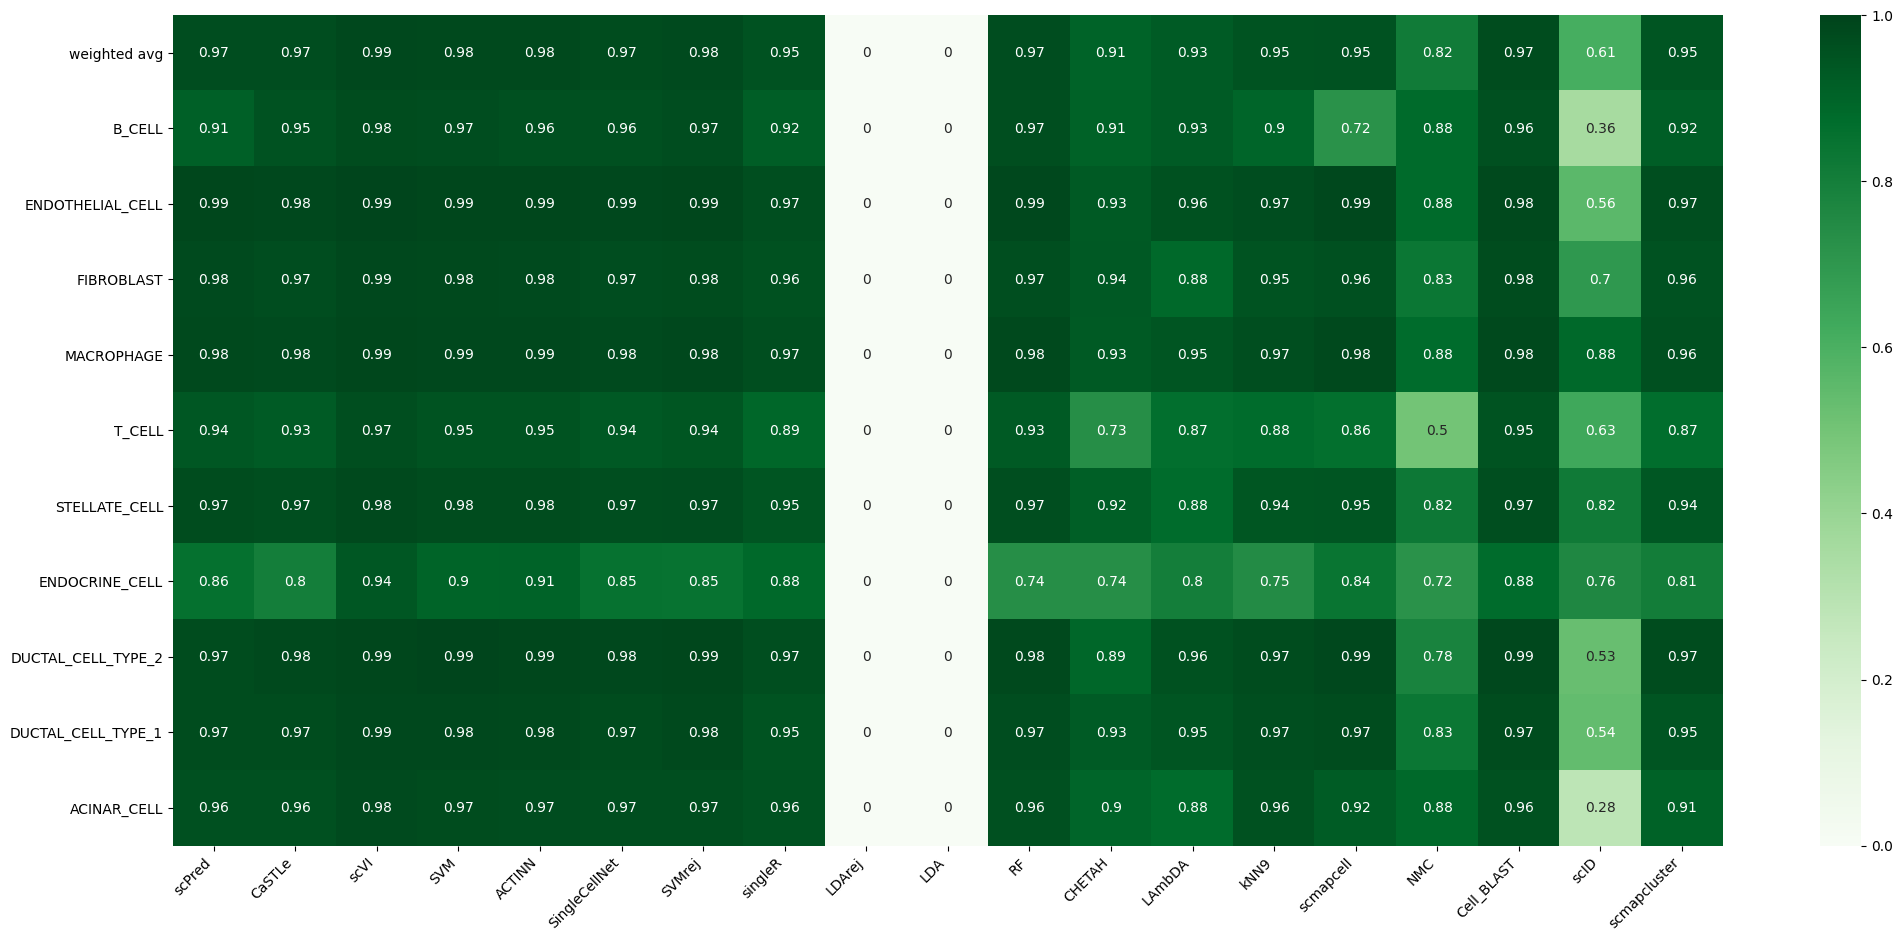

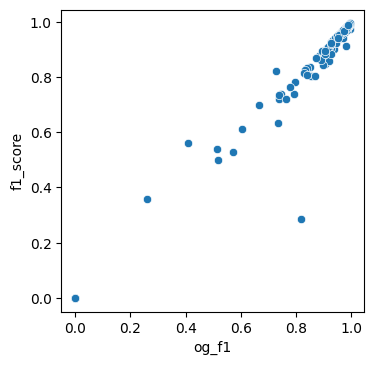

Red Cells have higher performance when training and testing on the same data.


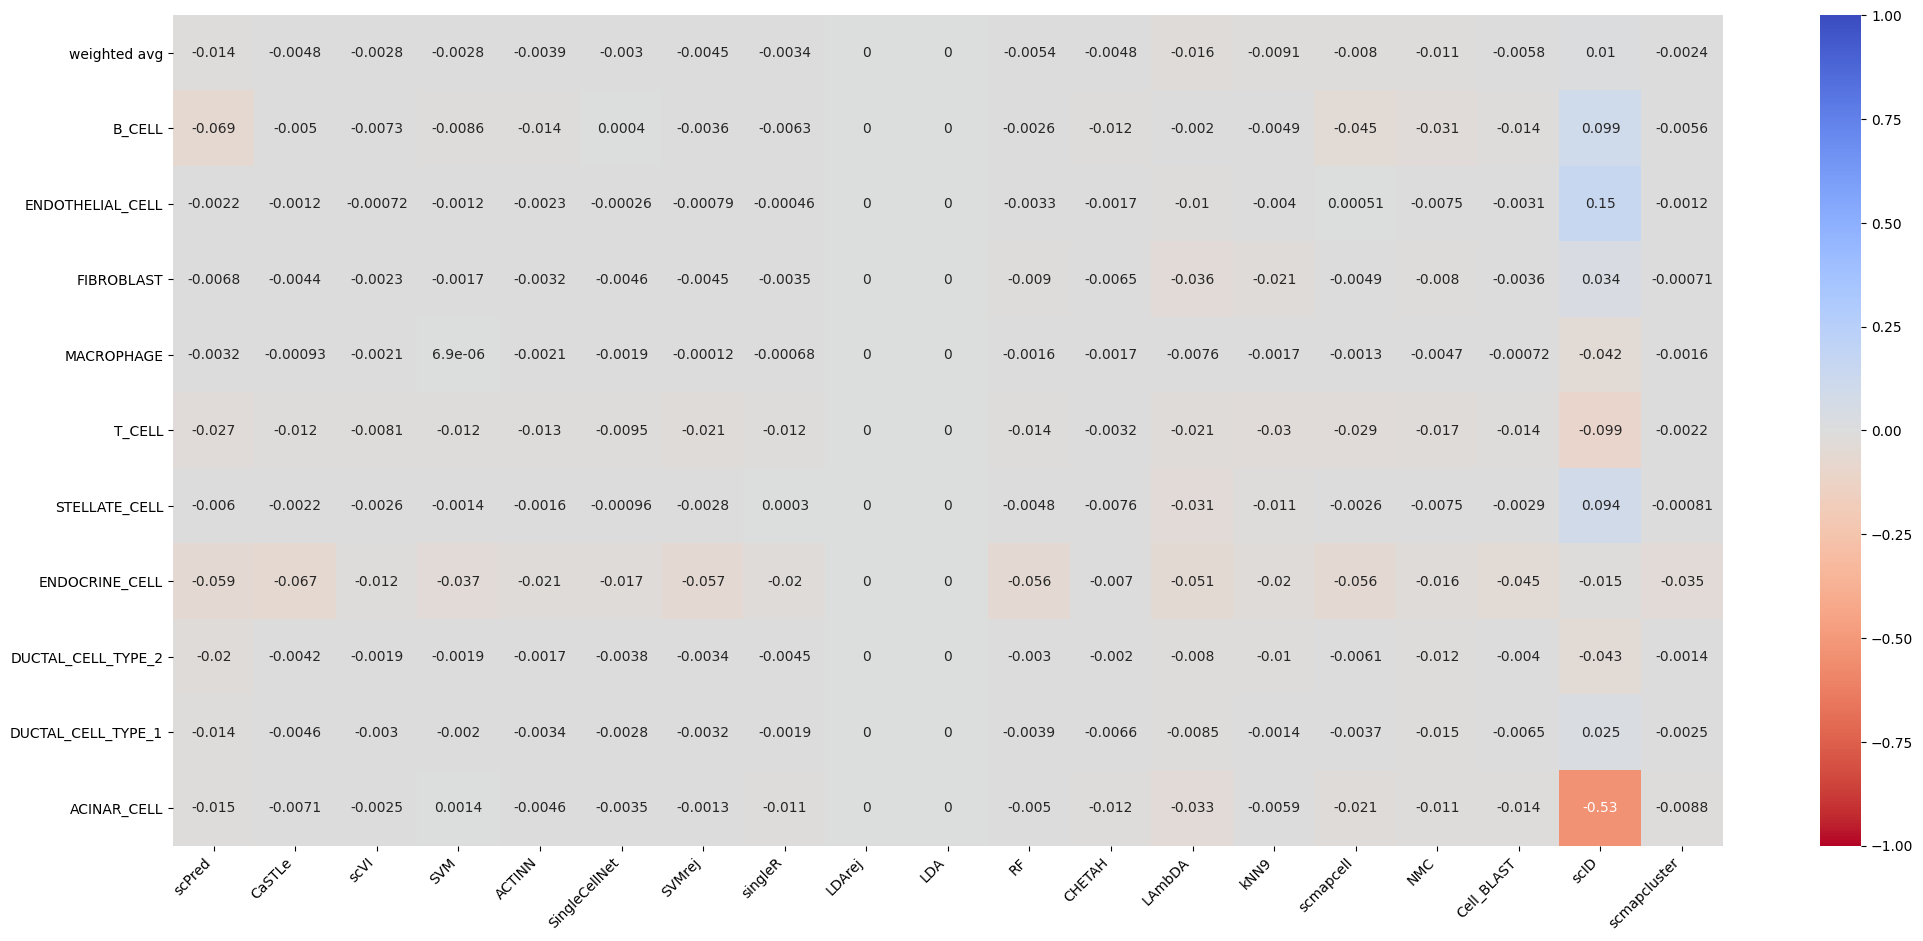

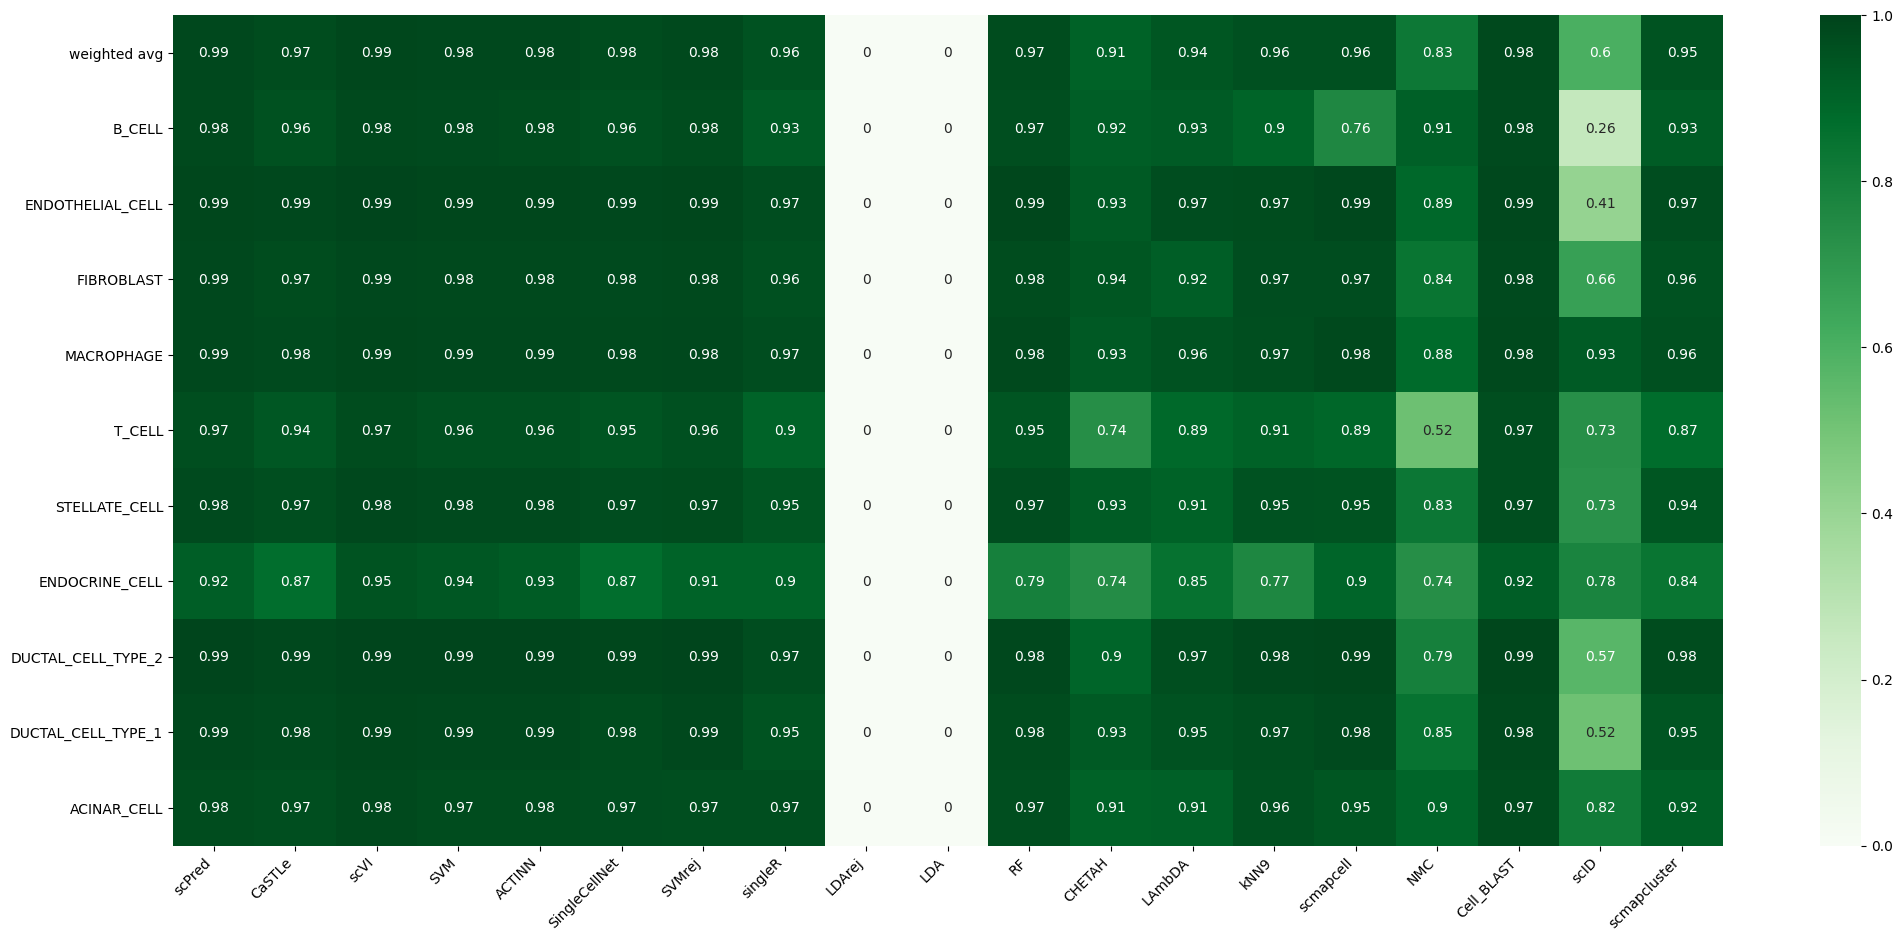

['T11', 'T14', 'N11', 'T1', 'T8', 'T18', 'N4']
(10926, 21)


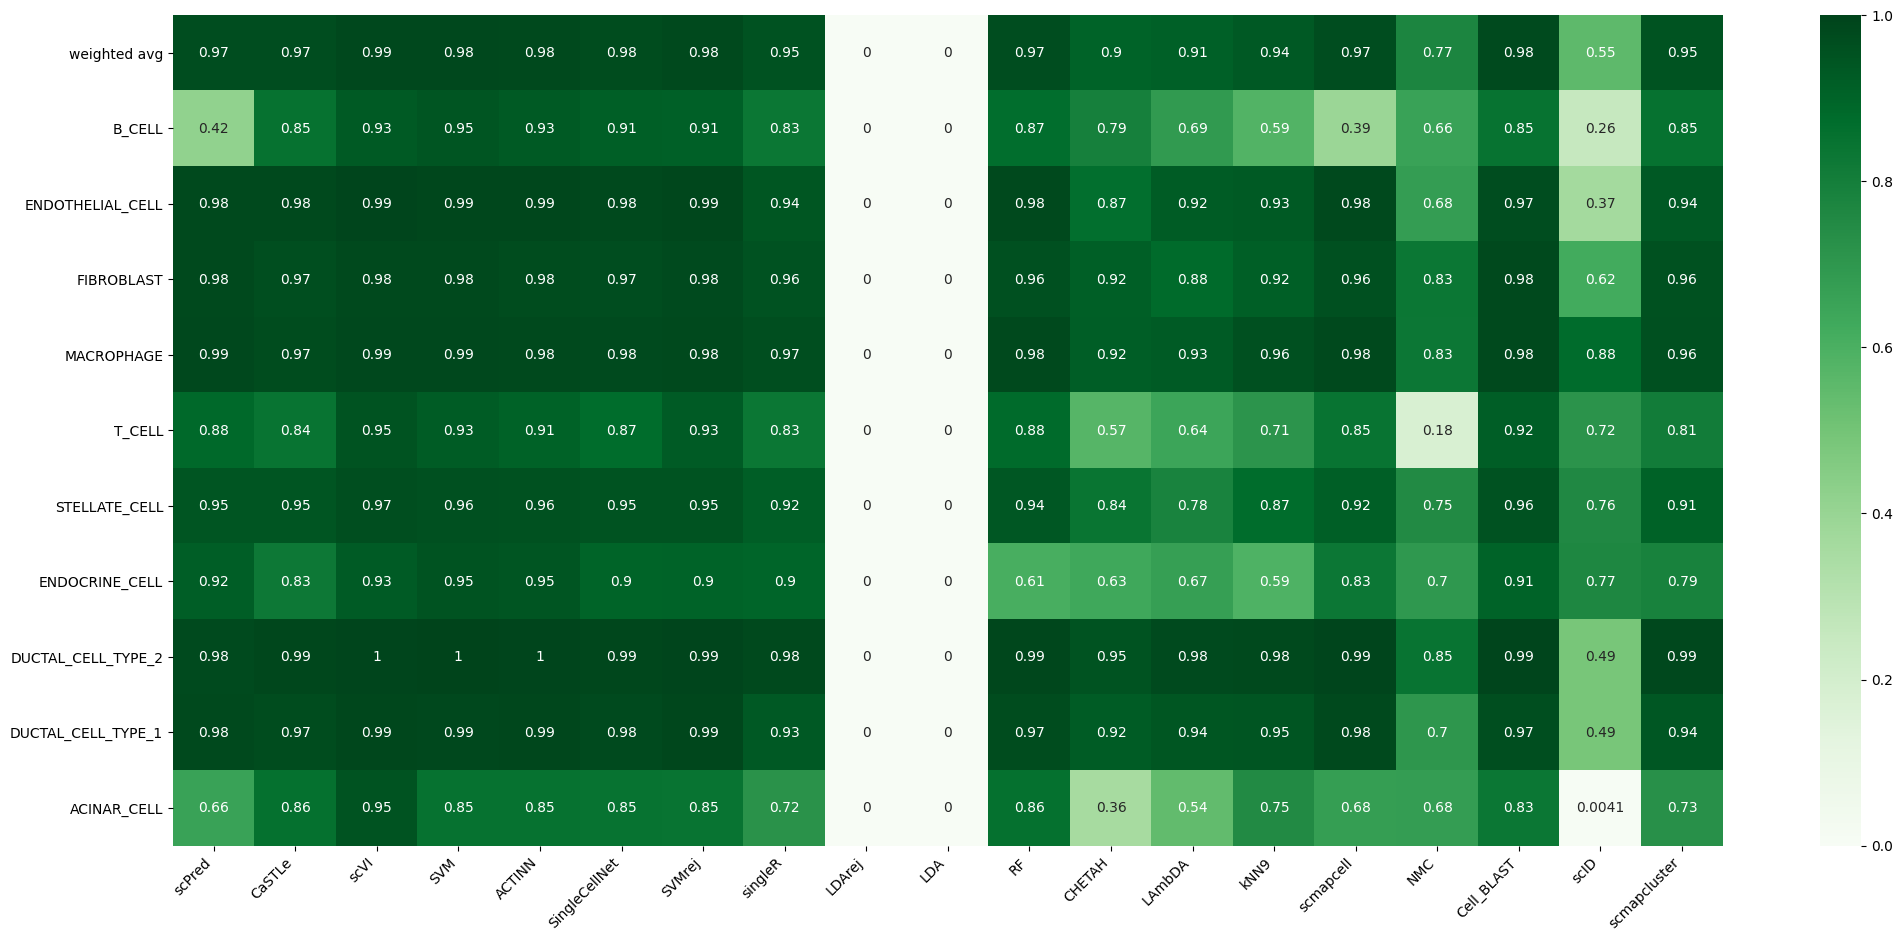

['T12', 'N7', 'T13', 'N1', 'N6', 'T2', 'T16']
(13659, 21)


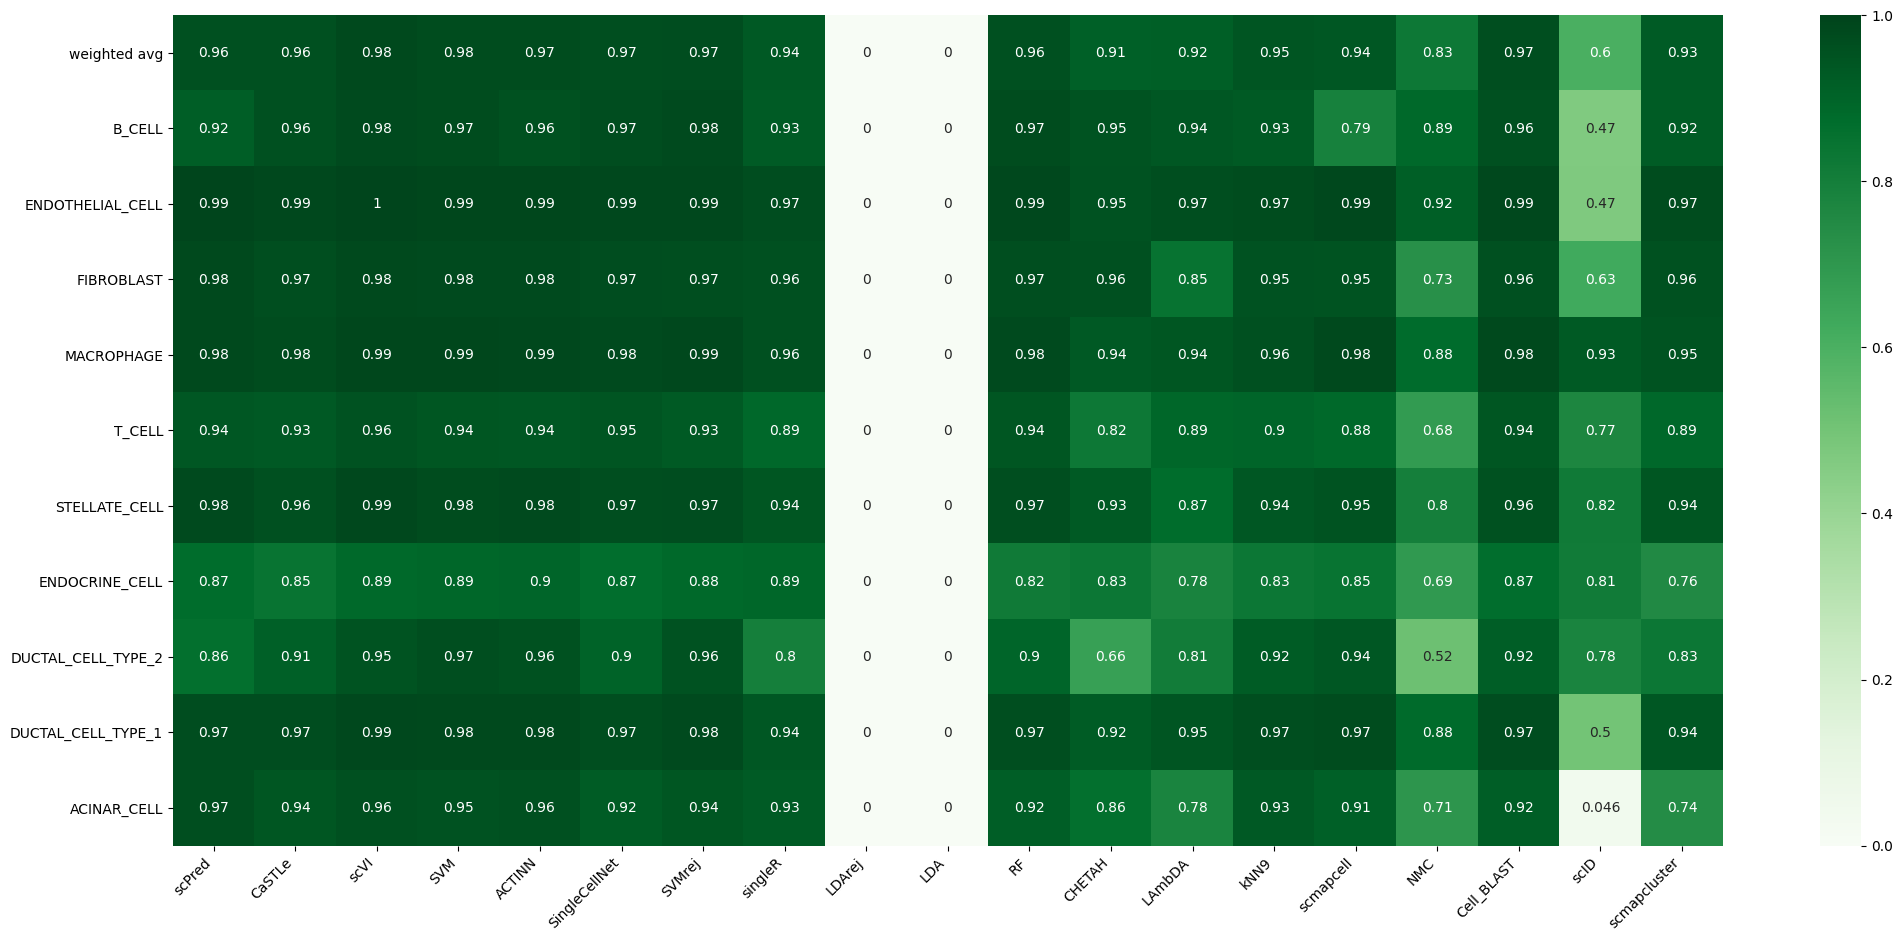

['T7', 'T10', 'T23', 'T9', 'T6', 'T17', 'T15']
(12706, 21)


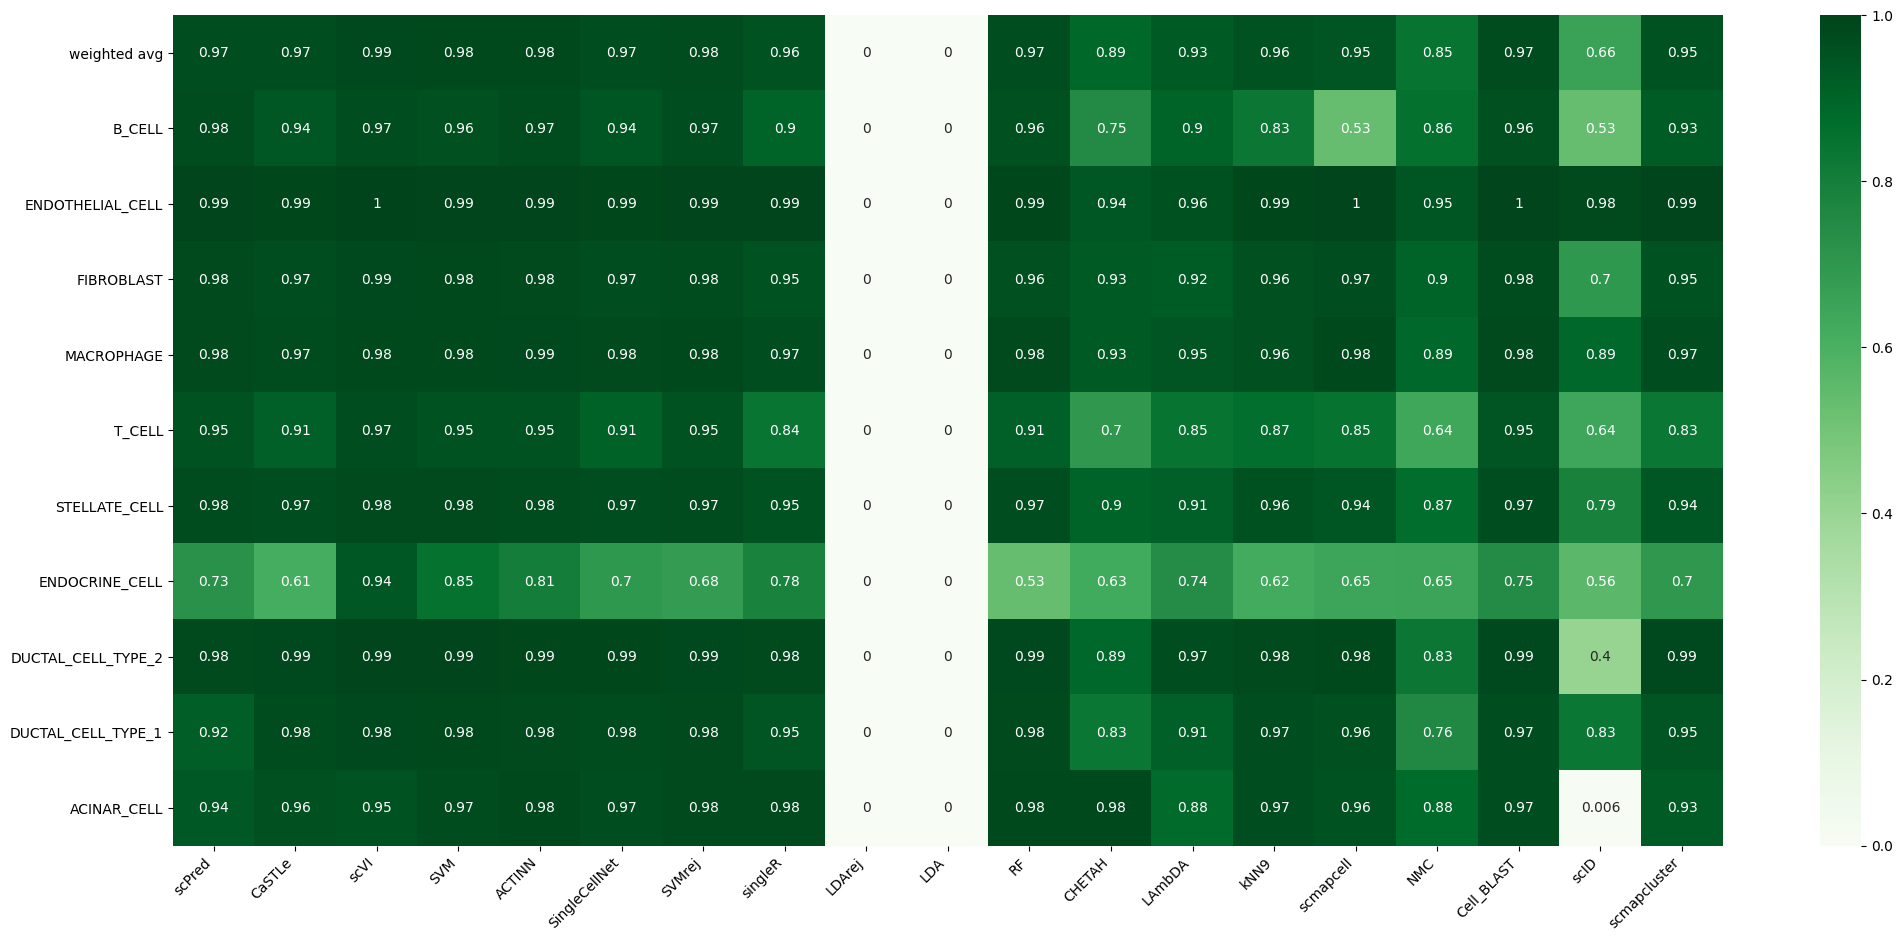

['T21', 'T19', 'T5', 'T20', 'N8', 'T22', 'N2']
(10725, 21)


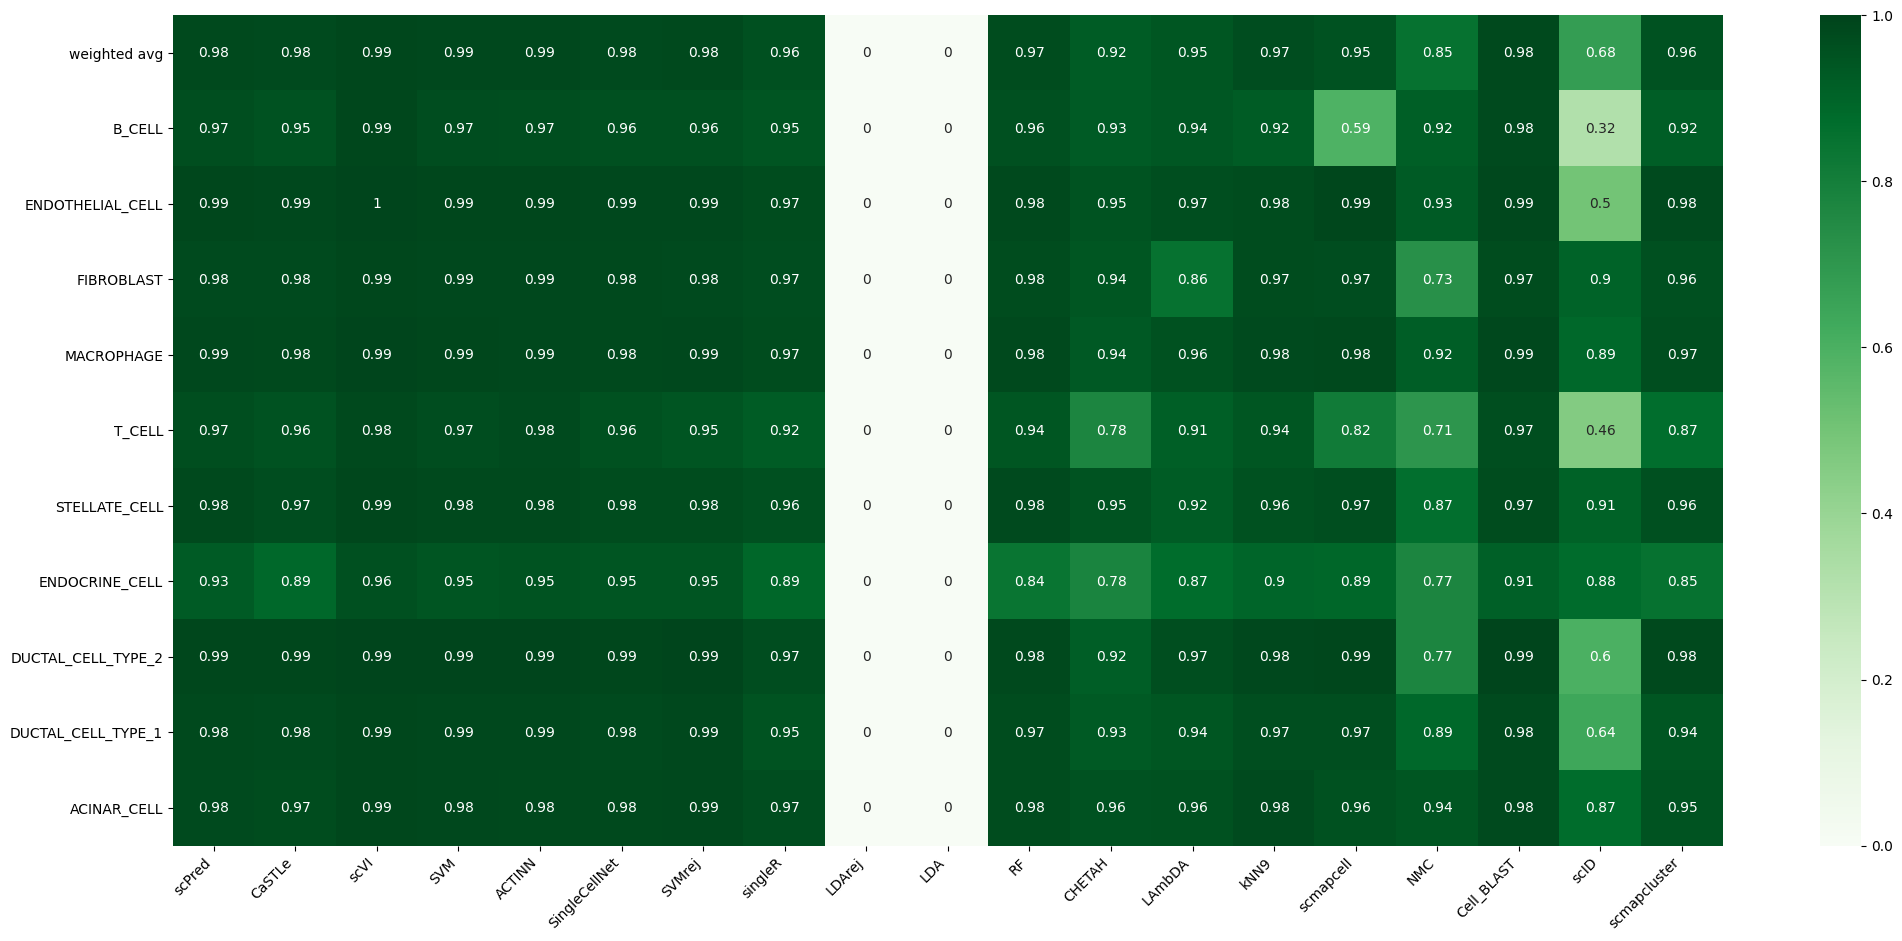

['T24', 'N10', 'N9', 'N5', 'T3', 'N3', 'T4']
(9514, 21)


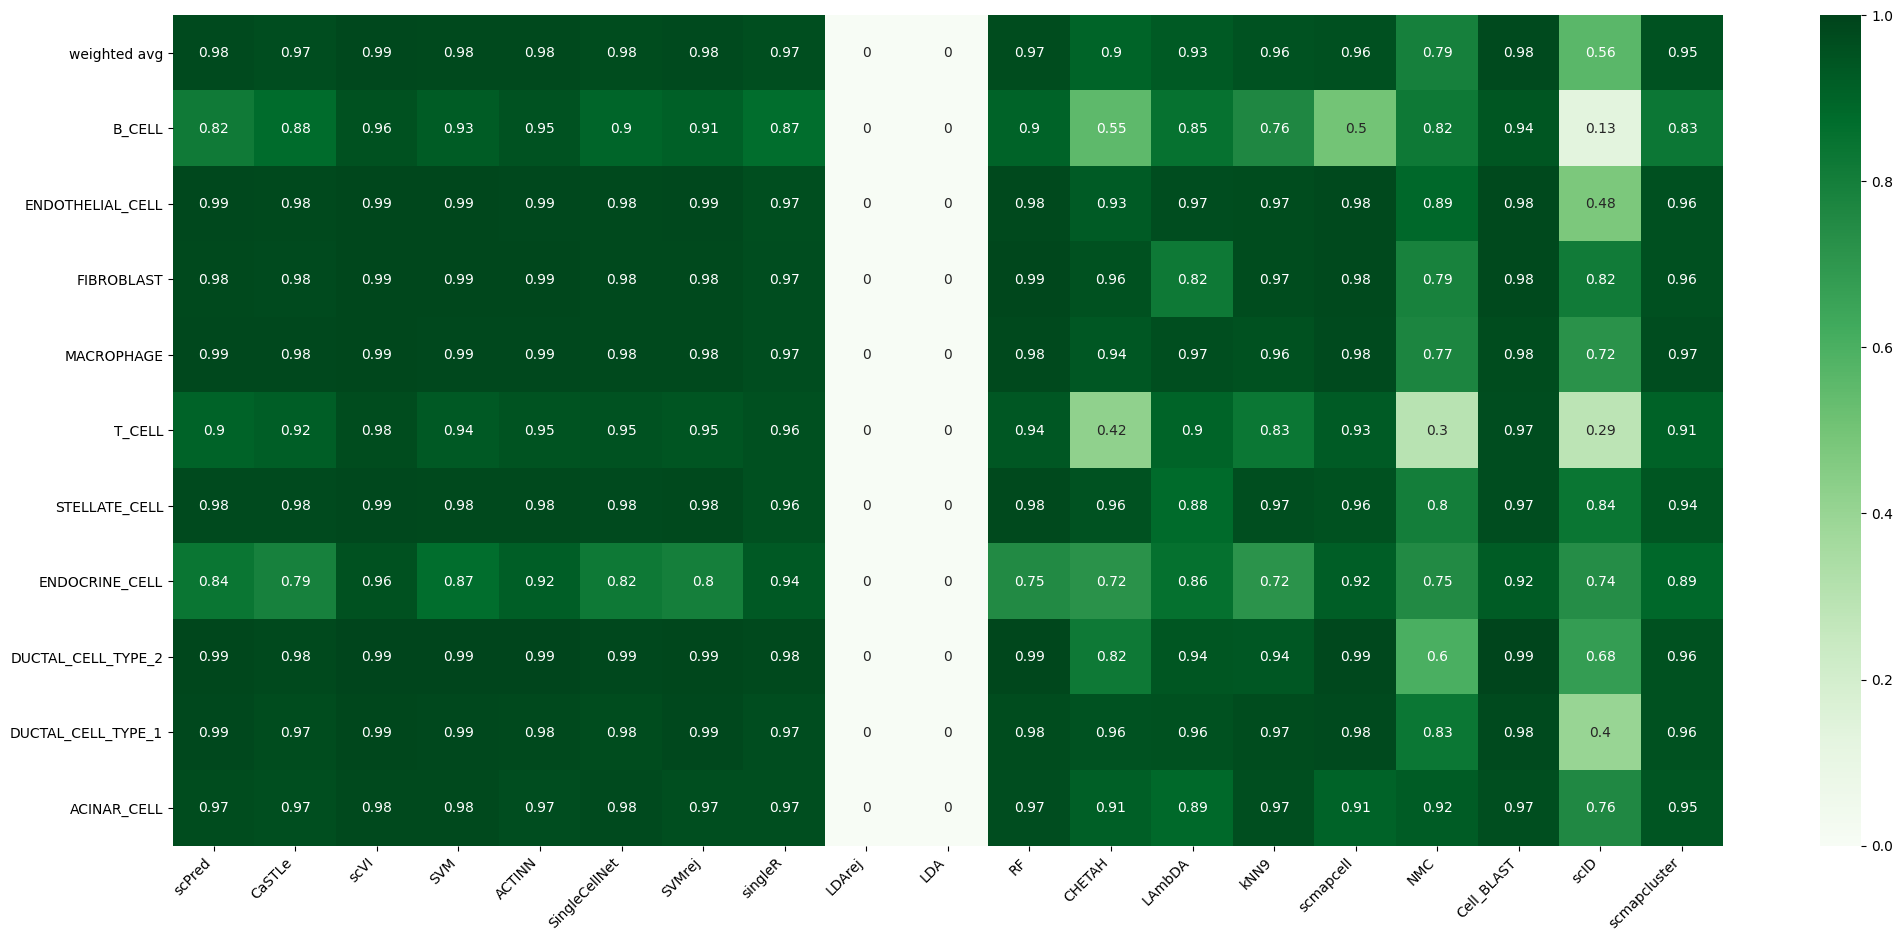

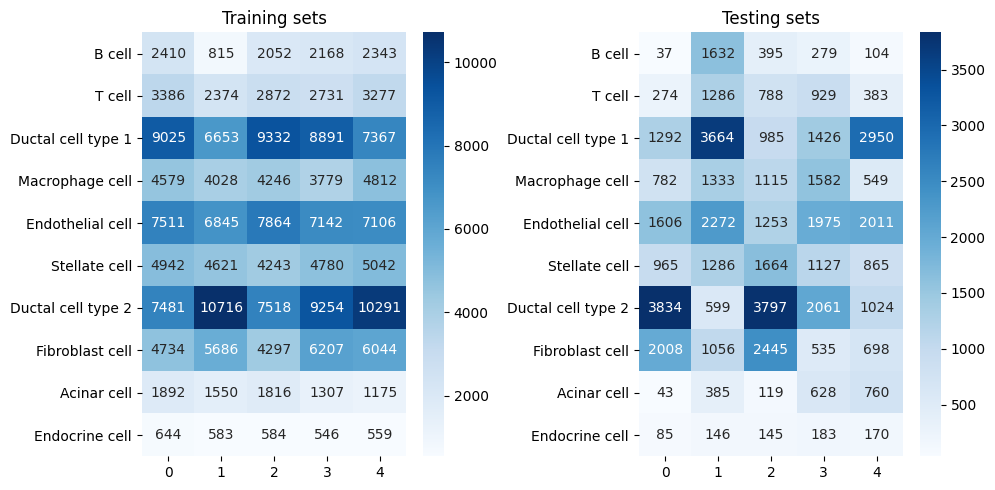

In [4]:
f = open('pancreatic/Peng_patient_test.tsv')
lines = f.readlines()
groups = [line.strip('[]\n').replace("'",'').replace(' ','').split(',')\
          for line in lines]
hmdf,diff = analyse('pancreatic/Peng_PC.tsv','pancreatic/Peng_PC_og_nocell.tsv',
        remap={'FIBROBLAST_CELL':"FIBROBLAST",'MACROPHAGE_CELL':'MACROPHAGE'},
        test_groups=groups,
        patients = '../pancreatic/pancreatic_patients.tsv'
       )

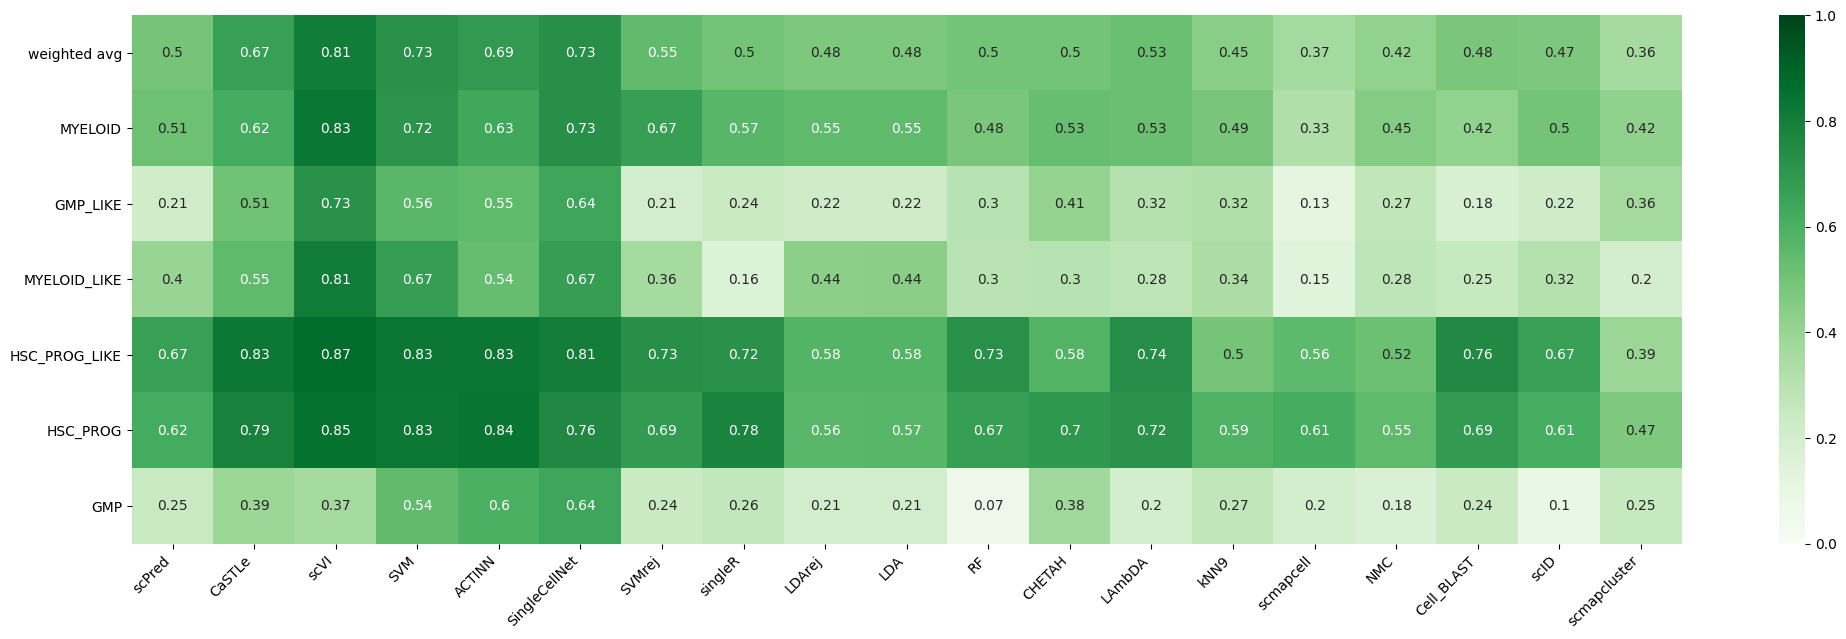

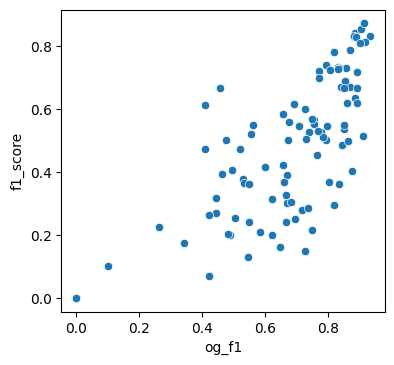

Red Cells have higher performance when training and testing on the same data.


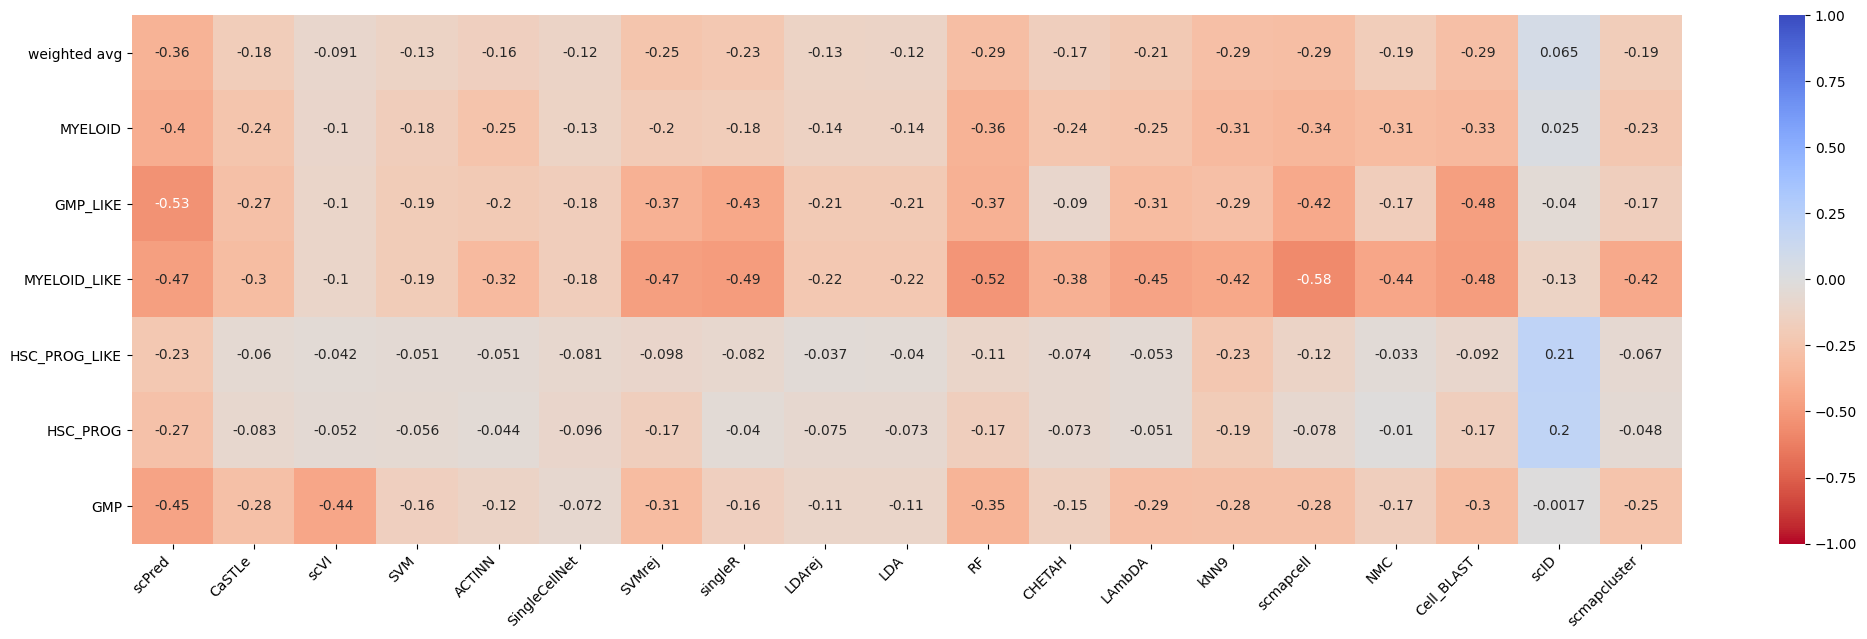

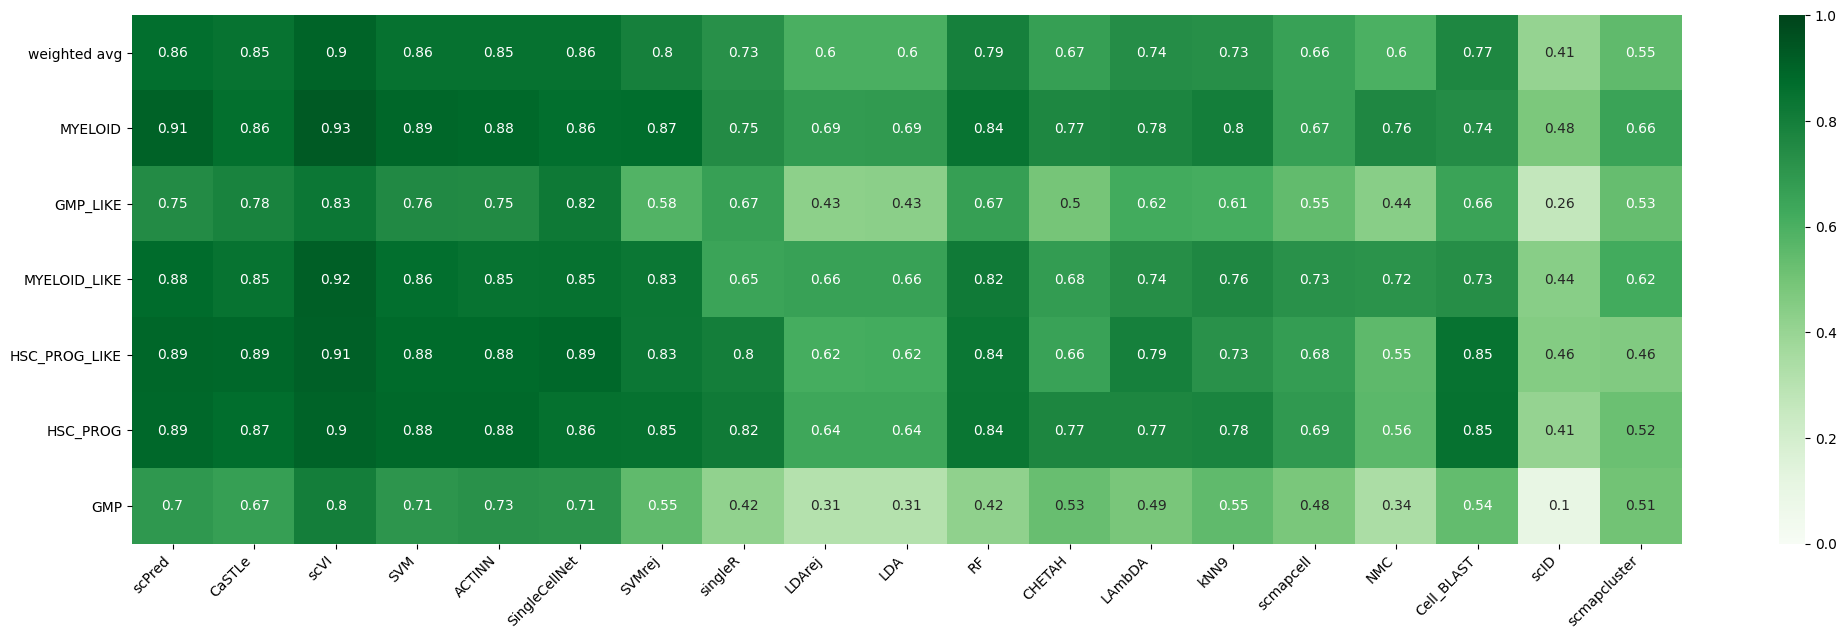

['AML329.D0', 'AML707B.D0', 'AML707B.D97', 'AML371.D0', 'AML420B.D0', 'AML870.D0', 'AML1012.D0', 'AML722B.D0', 'AML420B.D35']
(4361, 21)


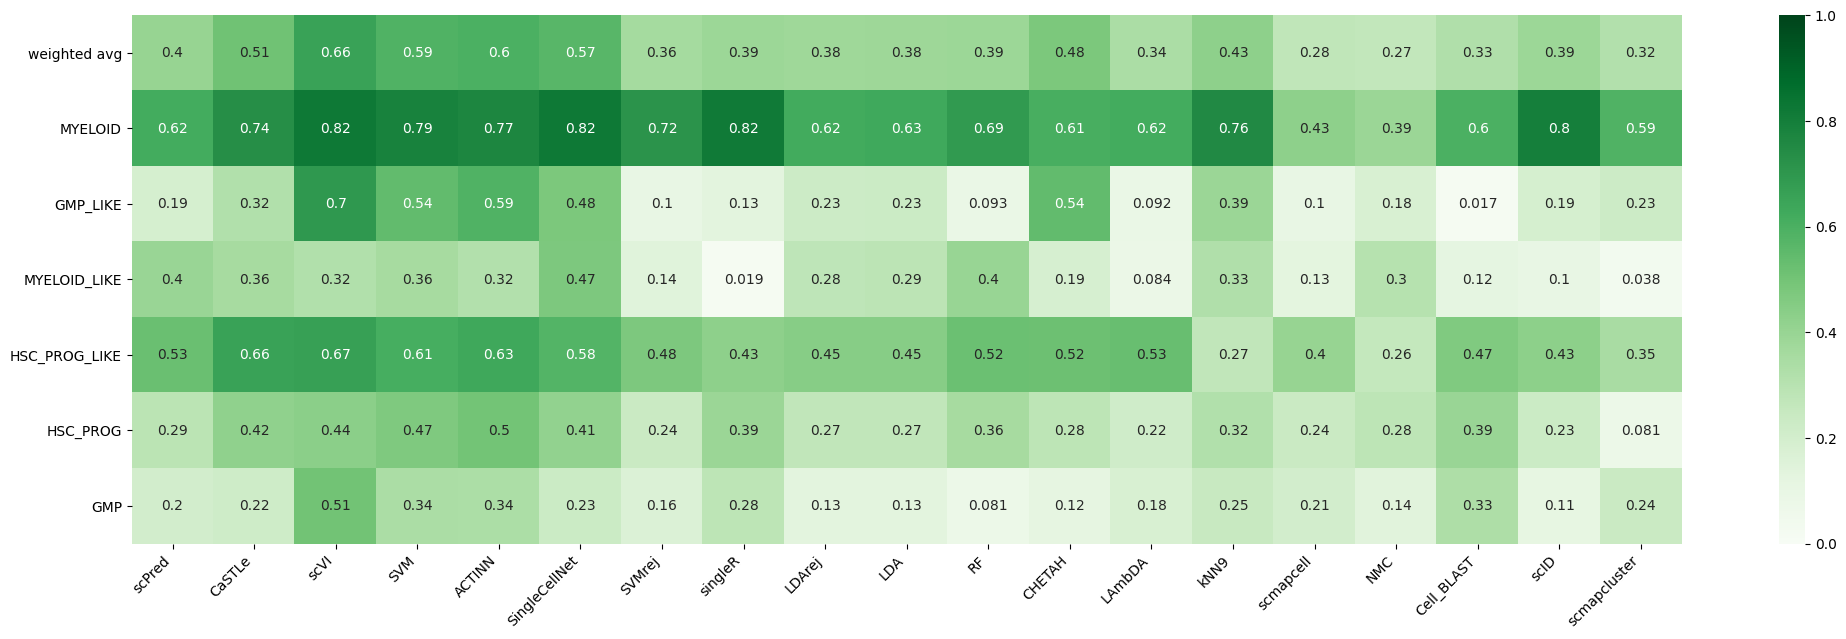

['AML329.D20', 'AML475.D0', 'BM1', 'AML916.D0', 'AML328.D113', 'AML420B.D14', 'AML314.D31', 'AML210A.D0', 'MUTZ3']
(3720, 21)


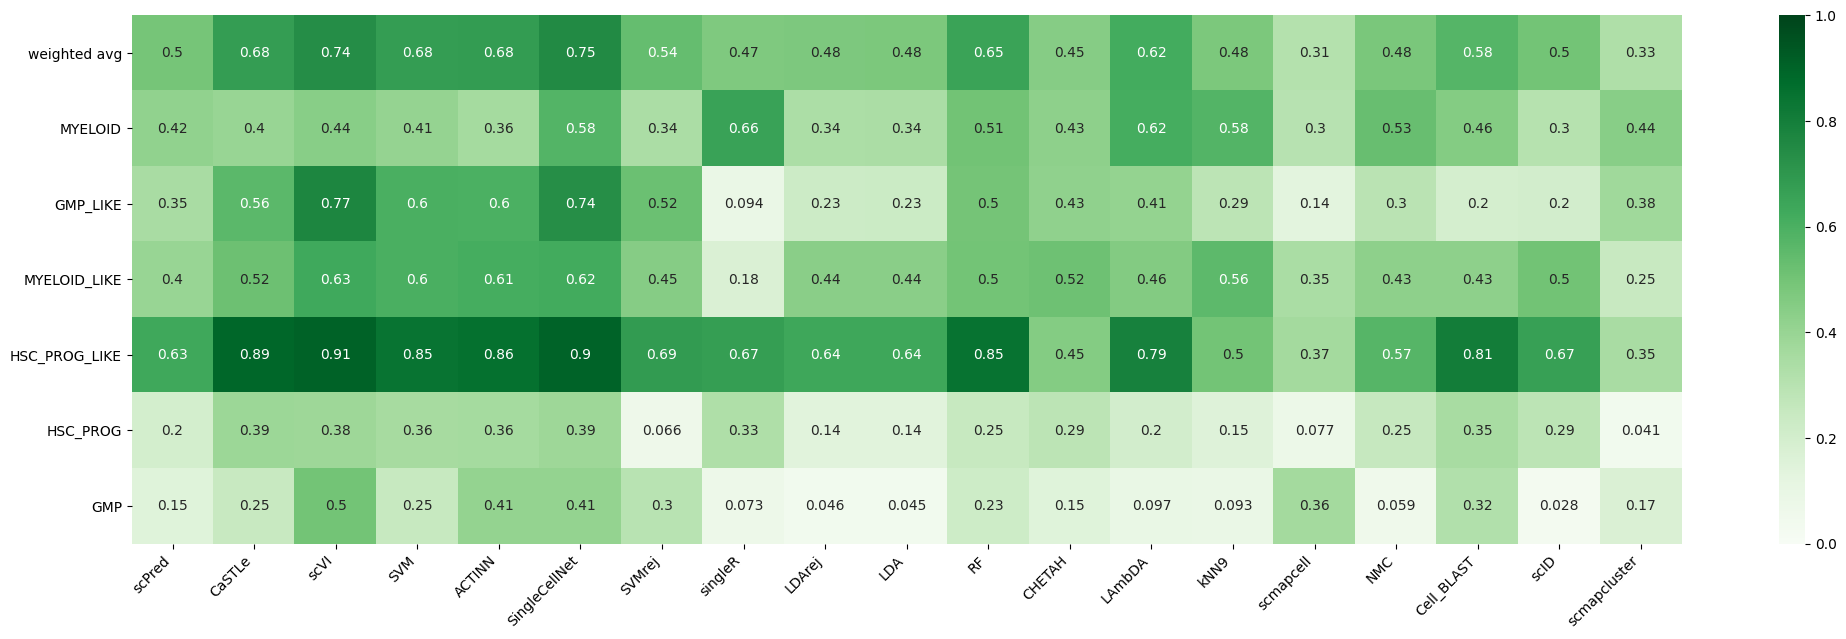

['AML707B.D18', 'AML328.D29', 'BM5.34p', 'BM4', 'AML722B.D49', 'AML997.D0', 'OCI.AML3', 'AML556.D31', 'BM2']
(6219, 21)


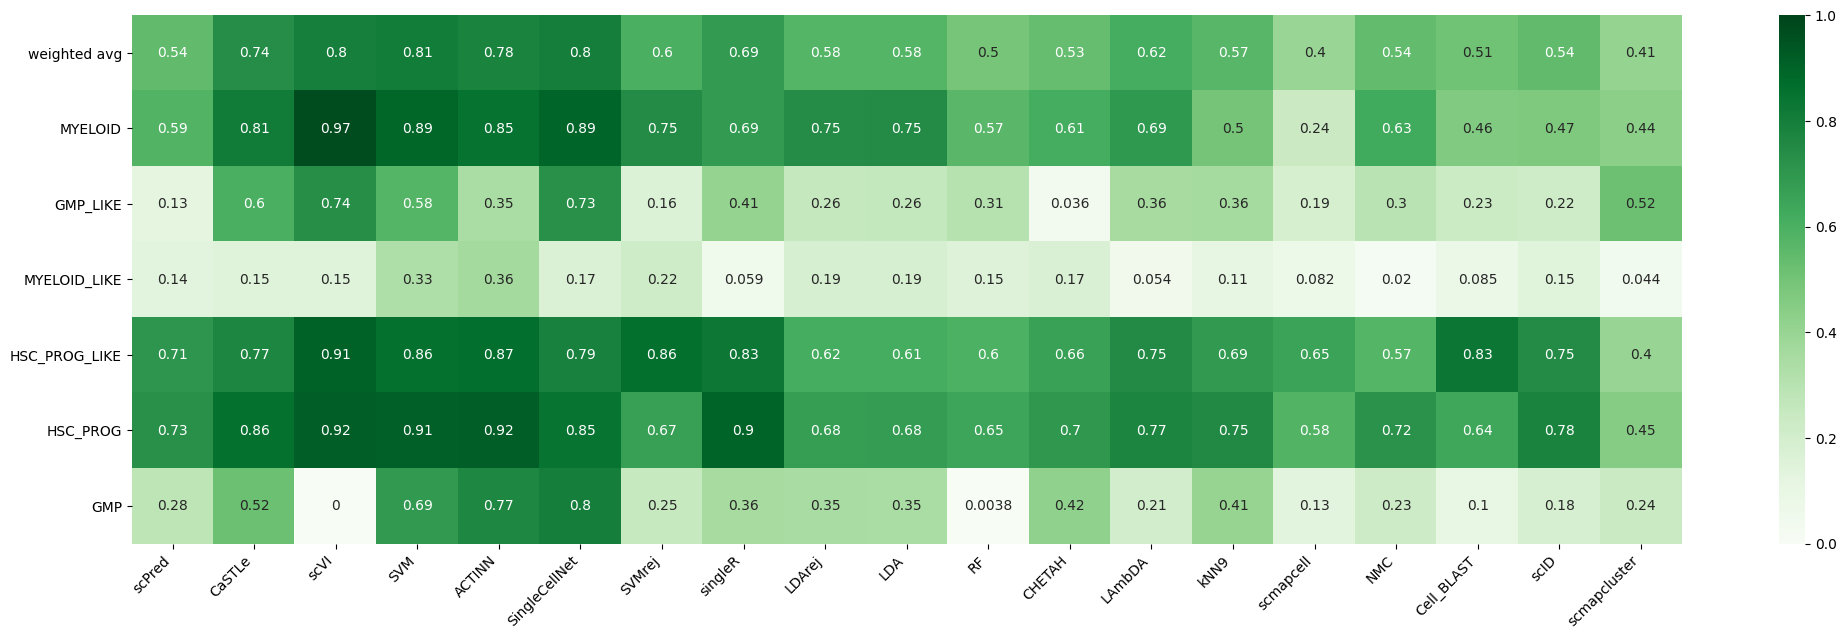

['AML707B.D113', 'AML556.D15', 'AML314.D0', 'AML707B.D41', 'AML997.D35', 'AML475.D29', 'AML921A.D0', 'AML419A.D0']
(3663, 21)


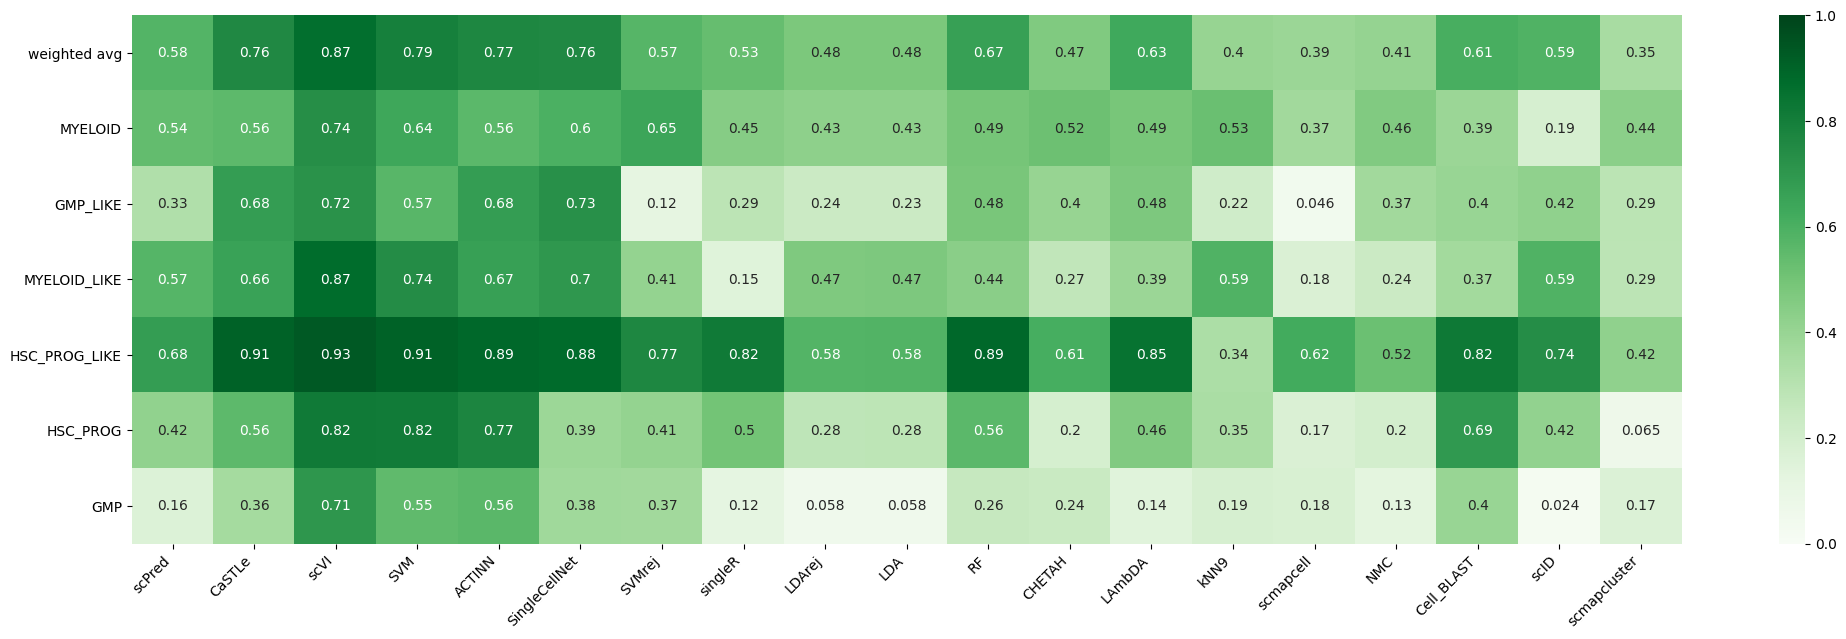

['AML870.D14', 'AML556.D0', 'BM3', 'AML371.D34', 'AML328.D171', 'AML328.D0', 'BM5.34p38n', 'AML329.D37']
(4321, 21)


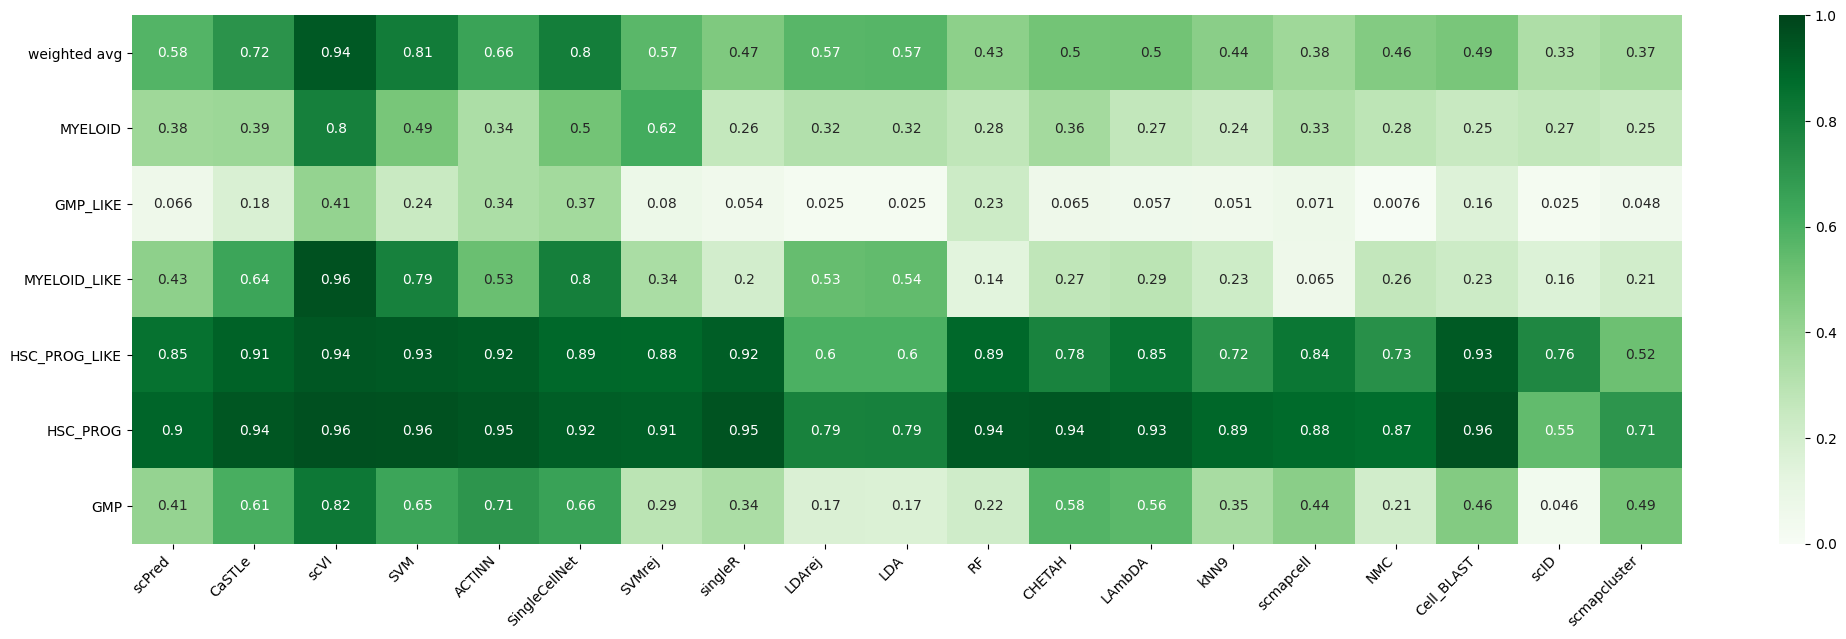

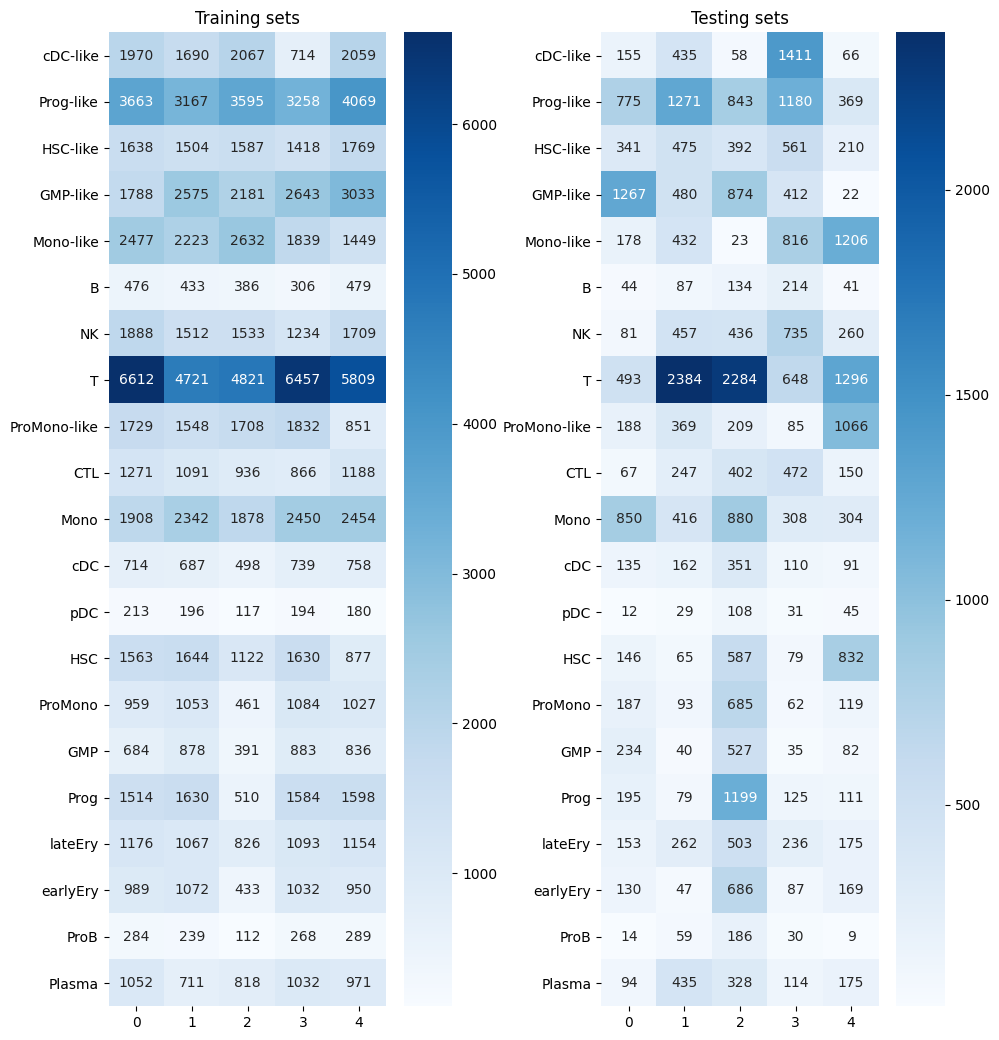

In [5]:
f = open('aml/vanGalan_patient_test.tsv')
lines = f.readlines()
groups = [line.strip('[]\n').replace("'",'').replace(' ','').split(',')\
          for line in lines]
hmdf,diff = analyse('aml/vanGalan_AML.tsv','../../predictions/vg_predictions.tsv',
        remap={},
        #TODO i think i need to remap some of these? can't remember if i changed them
        test_groups = groups,
        patients = '../aml/aml_patients.tsv'
       )

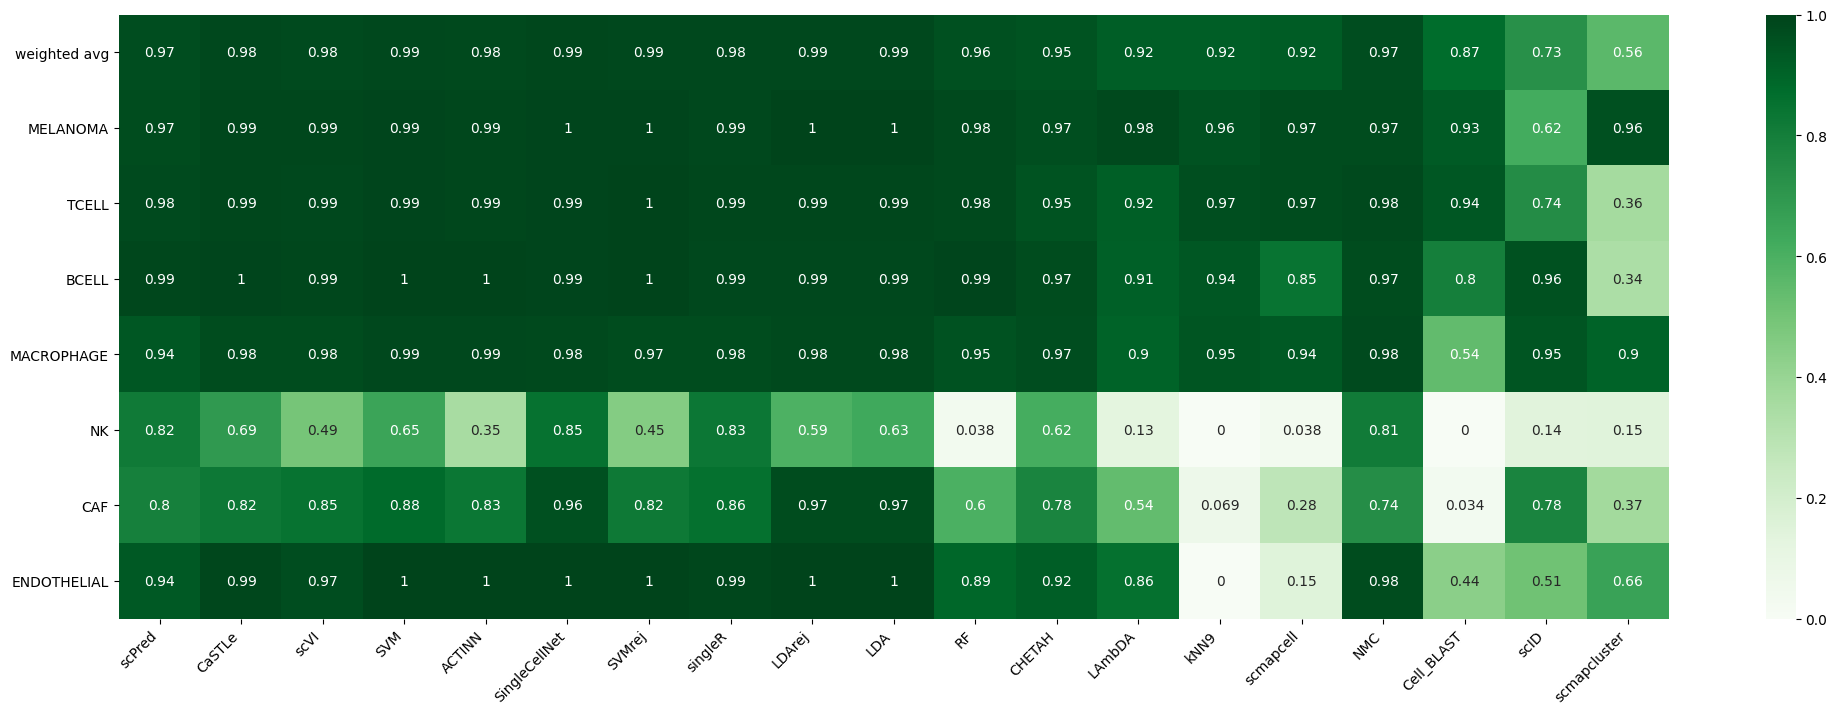

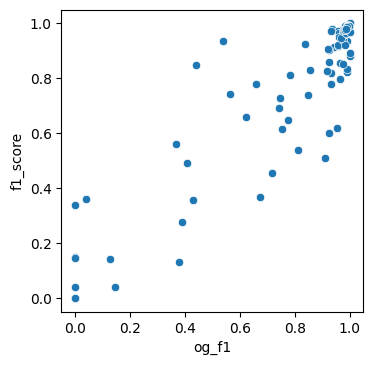

Red Cells have higher performance when training and testing on the same data.


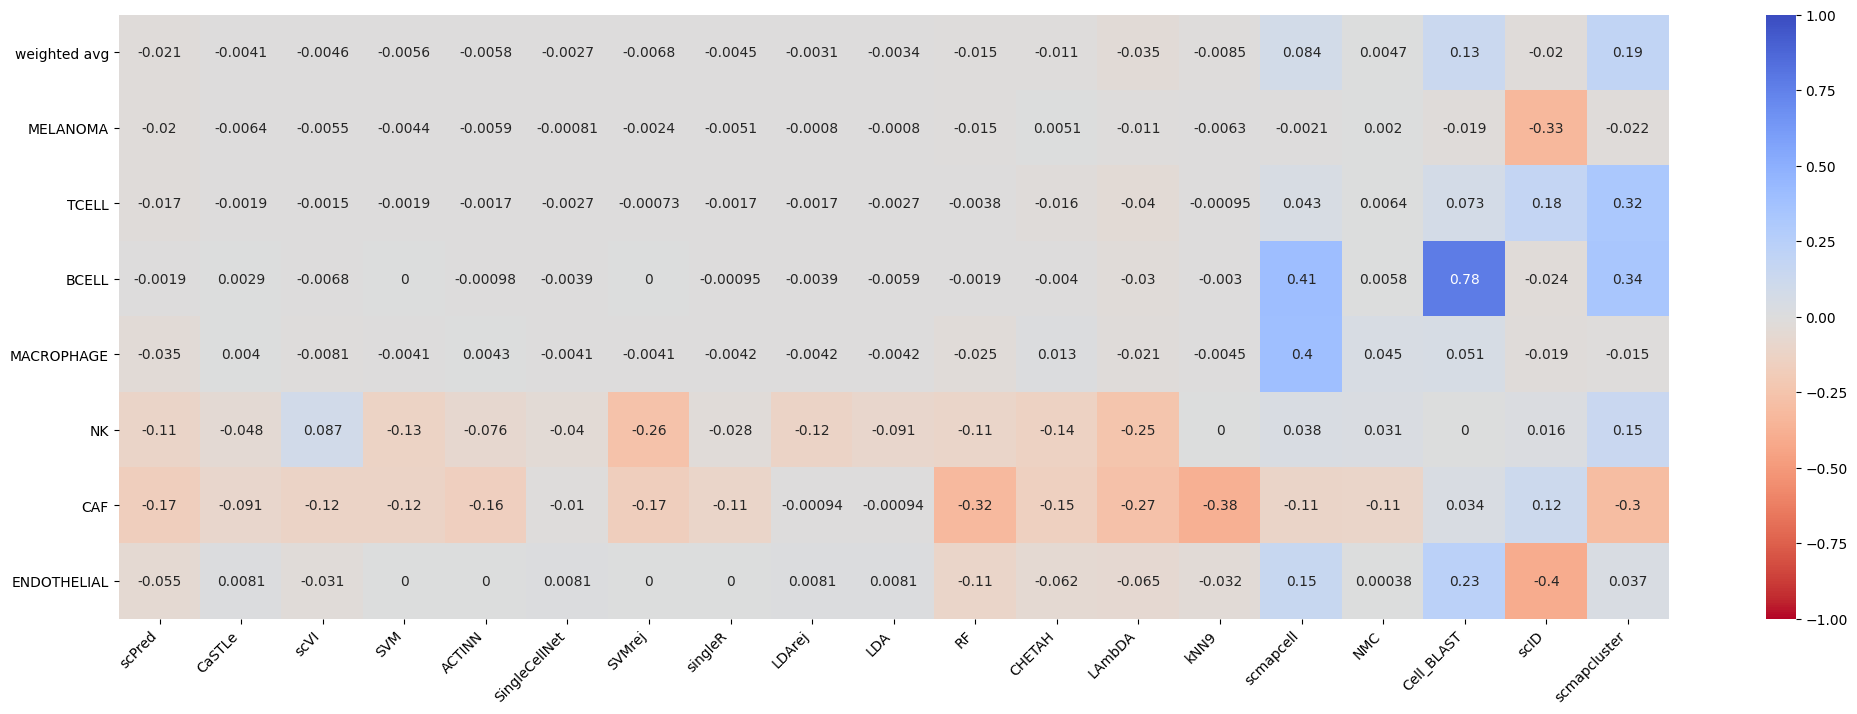

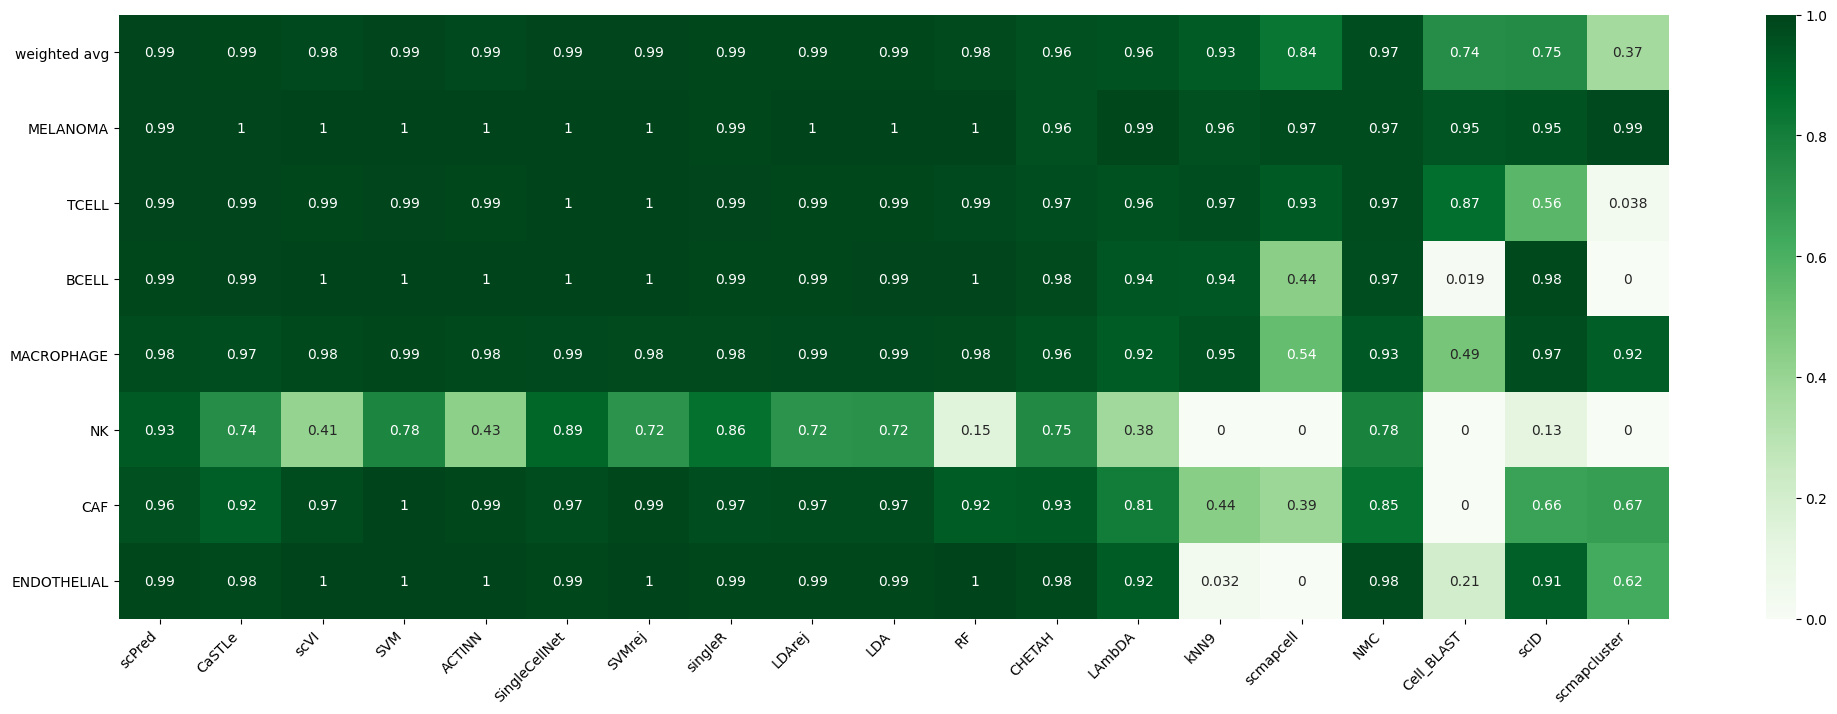

['53', '60', '84', '89']
(882, 21)


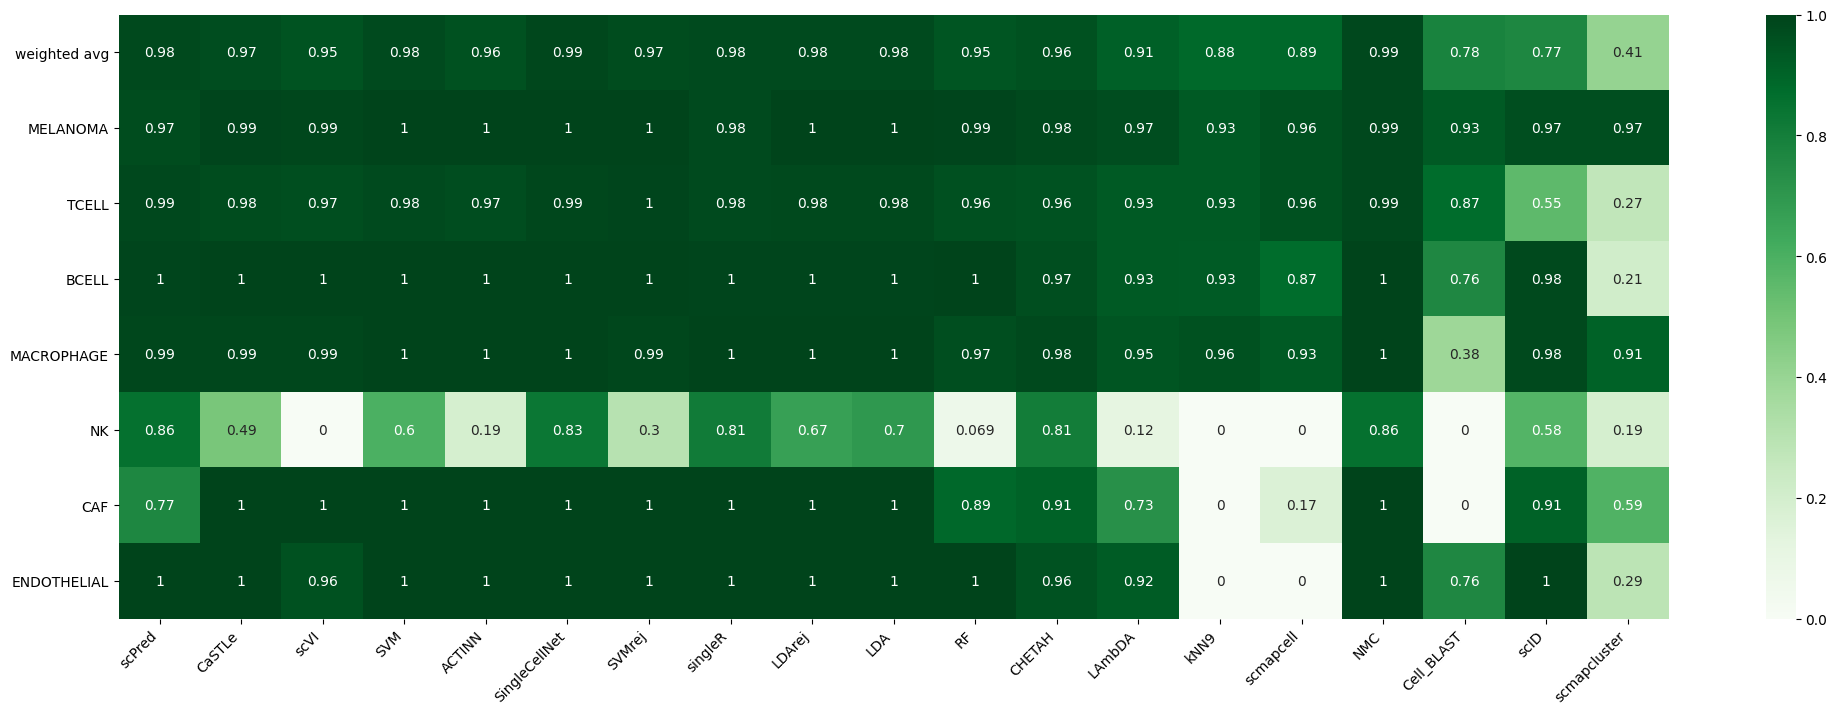

['58', '67', '71', '75']
(631, 21)


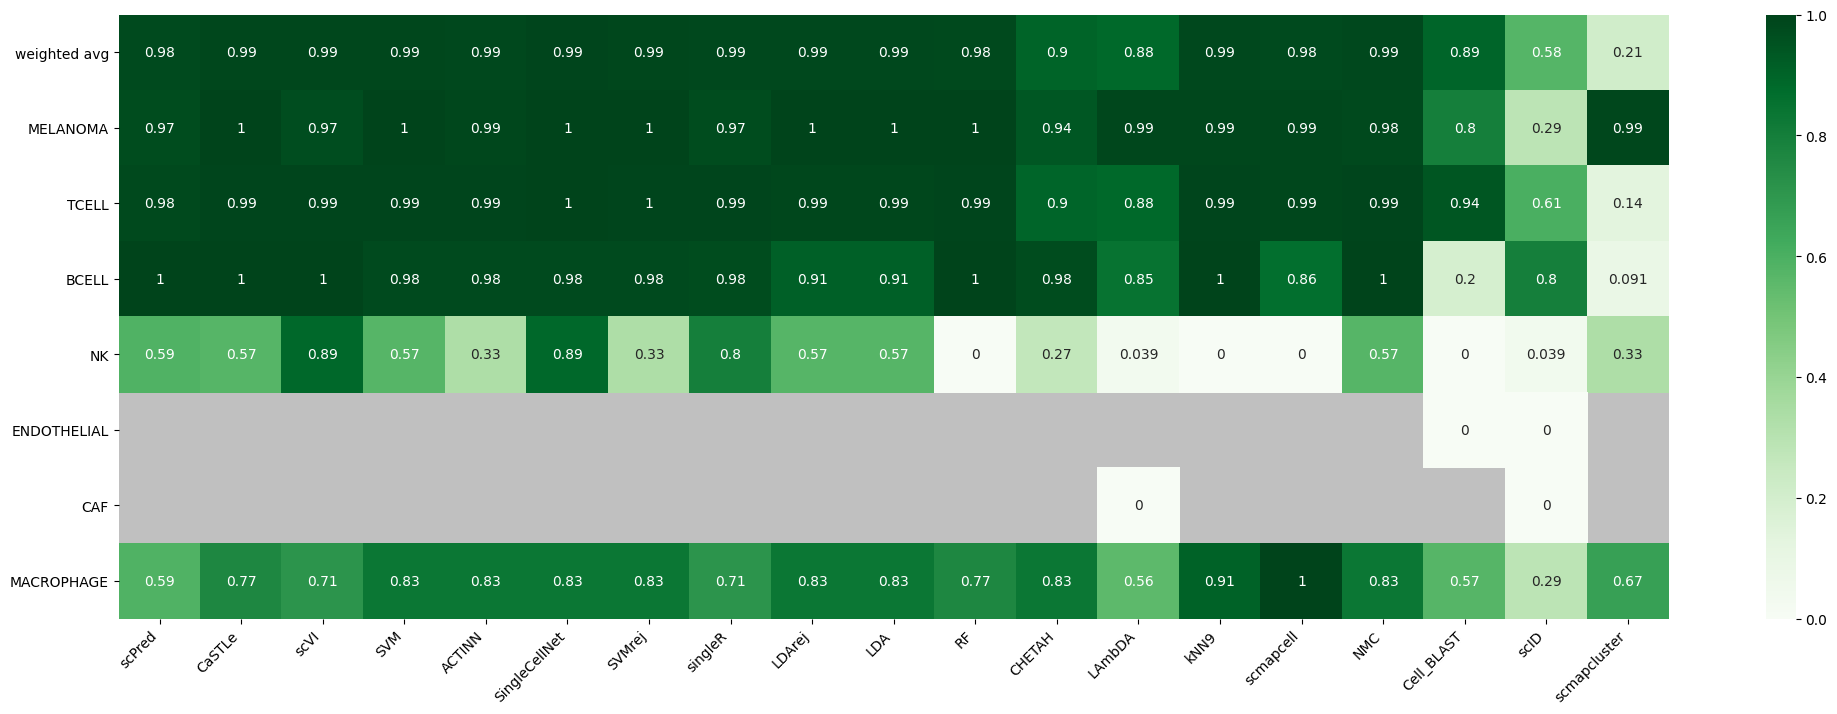

['78', '80', '82', '88']
(918, 21)


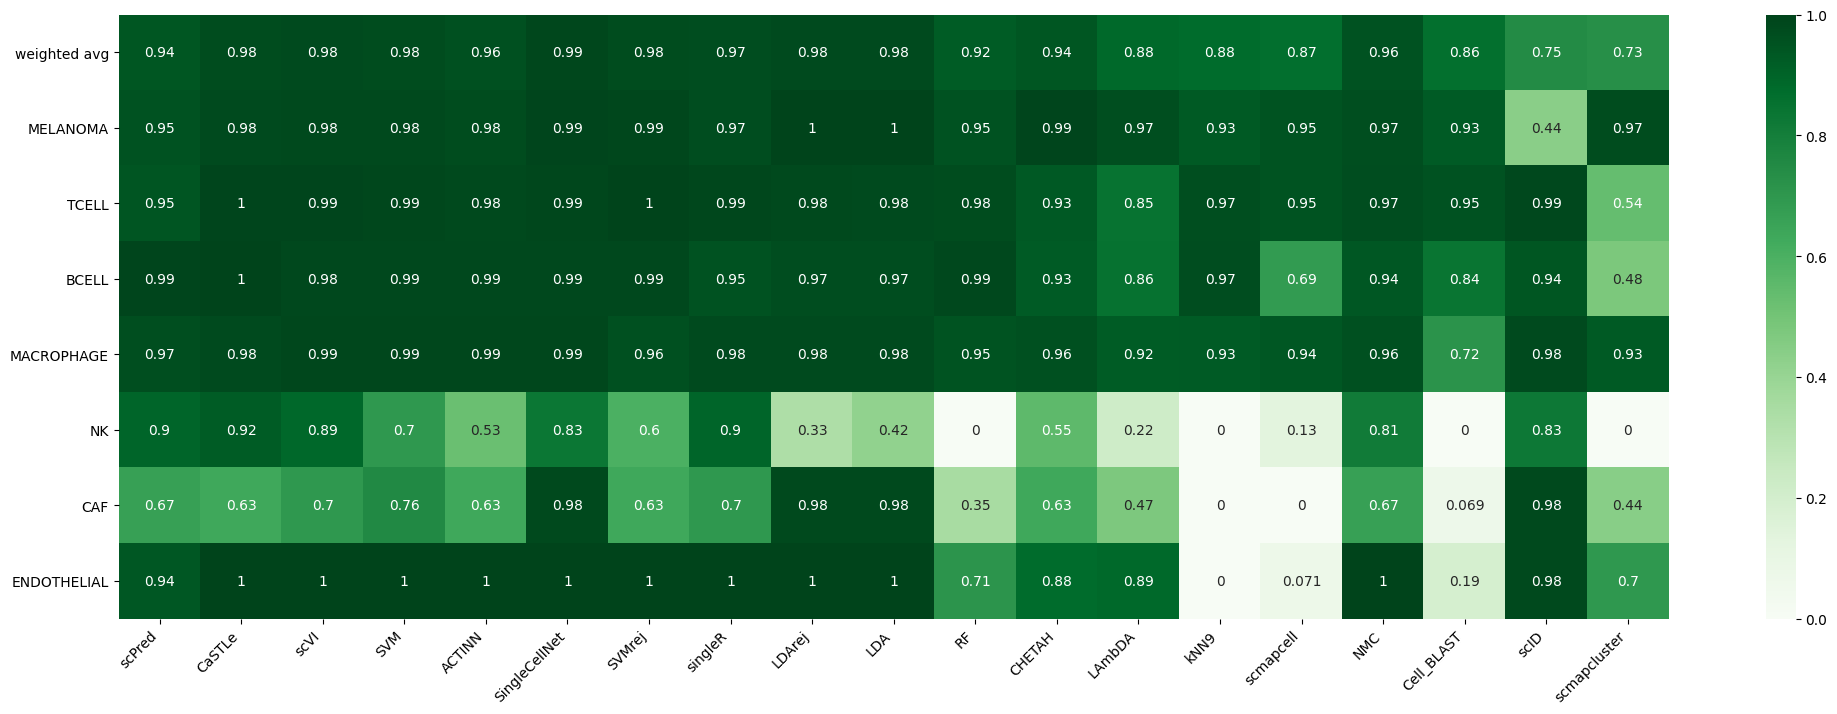

['59', '72', '79', '81']
(1241, 21)


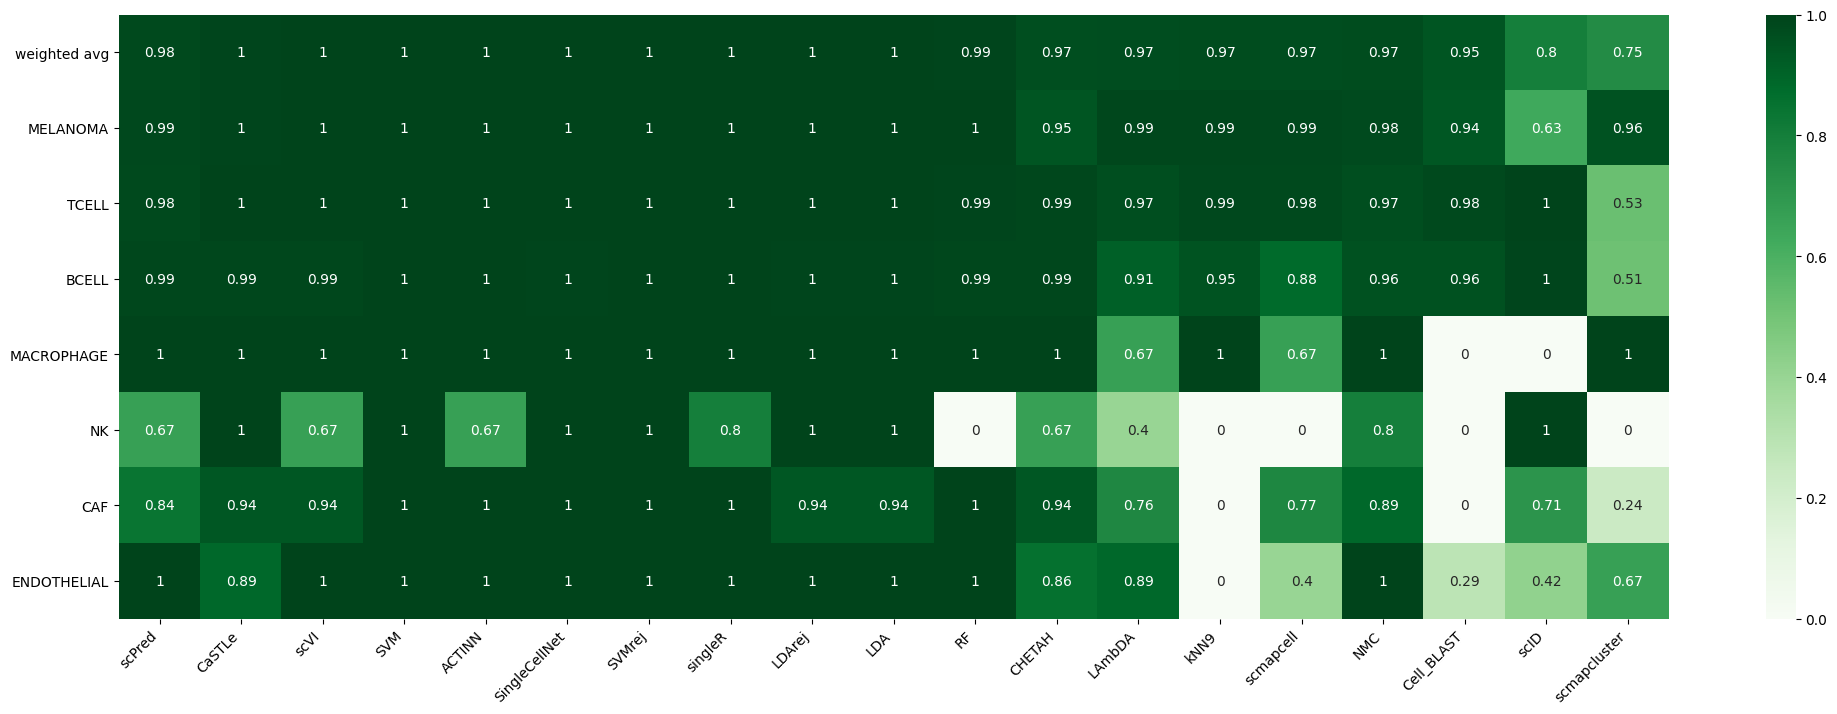

['65', '74', '94']
(425, 21)


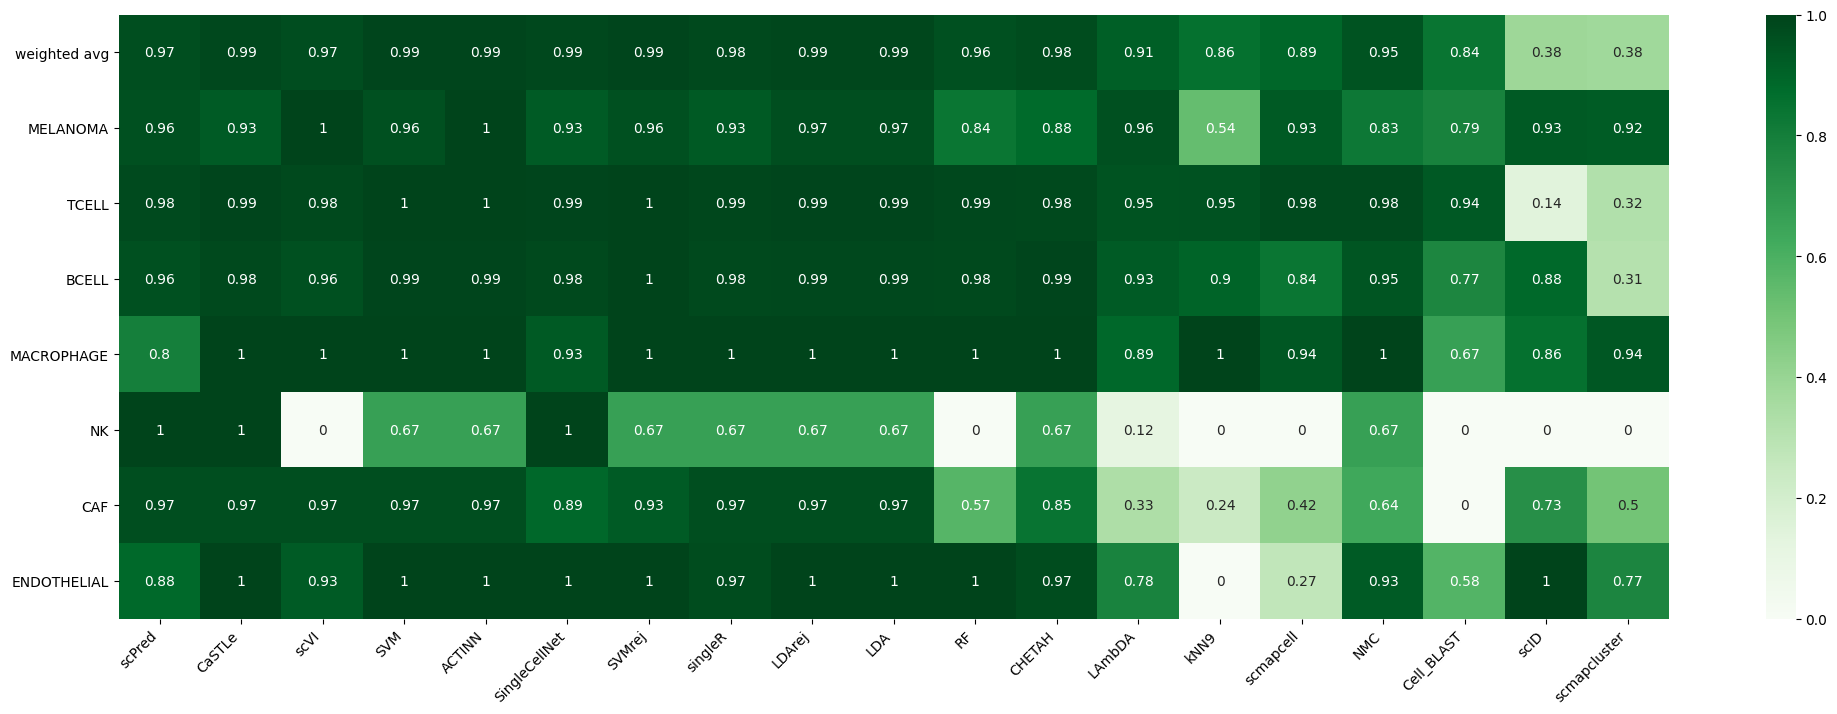

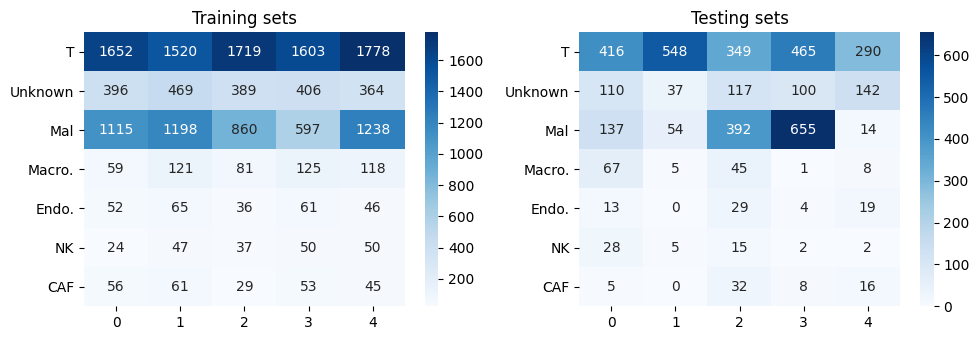

In [6]:
f = open('metastatic_melanoma/Tirosh_patient_test.tsv')
lines = f.readlines()
groups = [line.strip('[]\n').replace("'",'').replace(' ','').split(',')\
          for line in lines]
hmdf,diff = analyse('metastatic_melanoma/Tirosh_metastatic_melanoma.tsv',
        '../../predictions/tm_predictions.tsv',
        remap={'TUMOR':"MELANOMA",'ENDO':'ENDOTHELIAL','MACRO':"MACROPHAGE"},
        test_groups = groups, 
        #TODO this one is being weird and not getting all cells.
        patients = '../metastatic_melanoma/metastatic_melanoma_patients.tsv'
       )

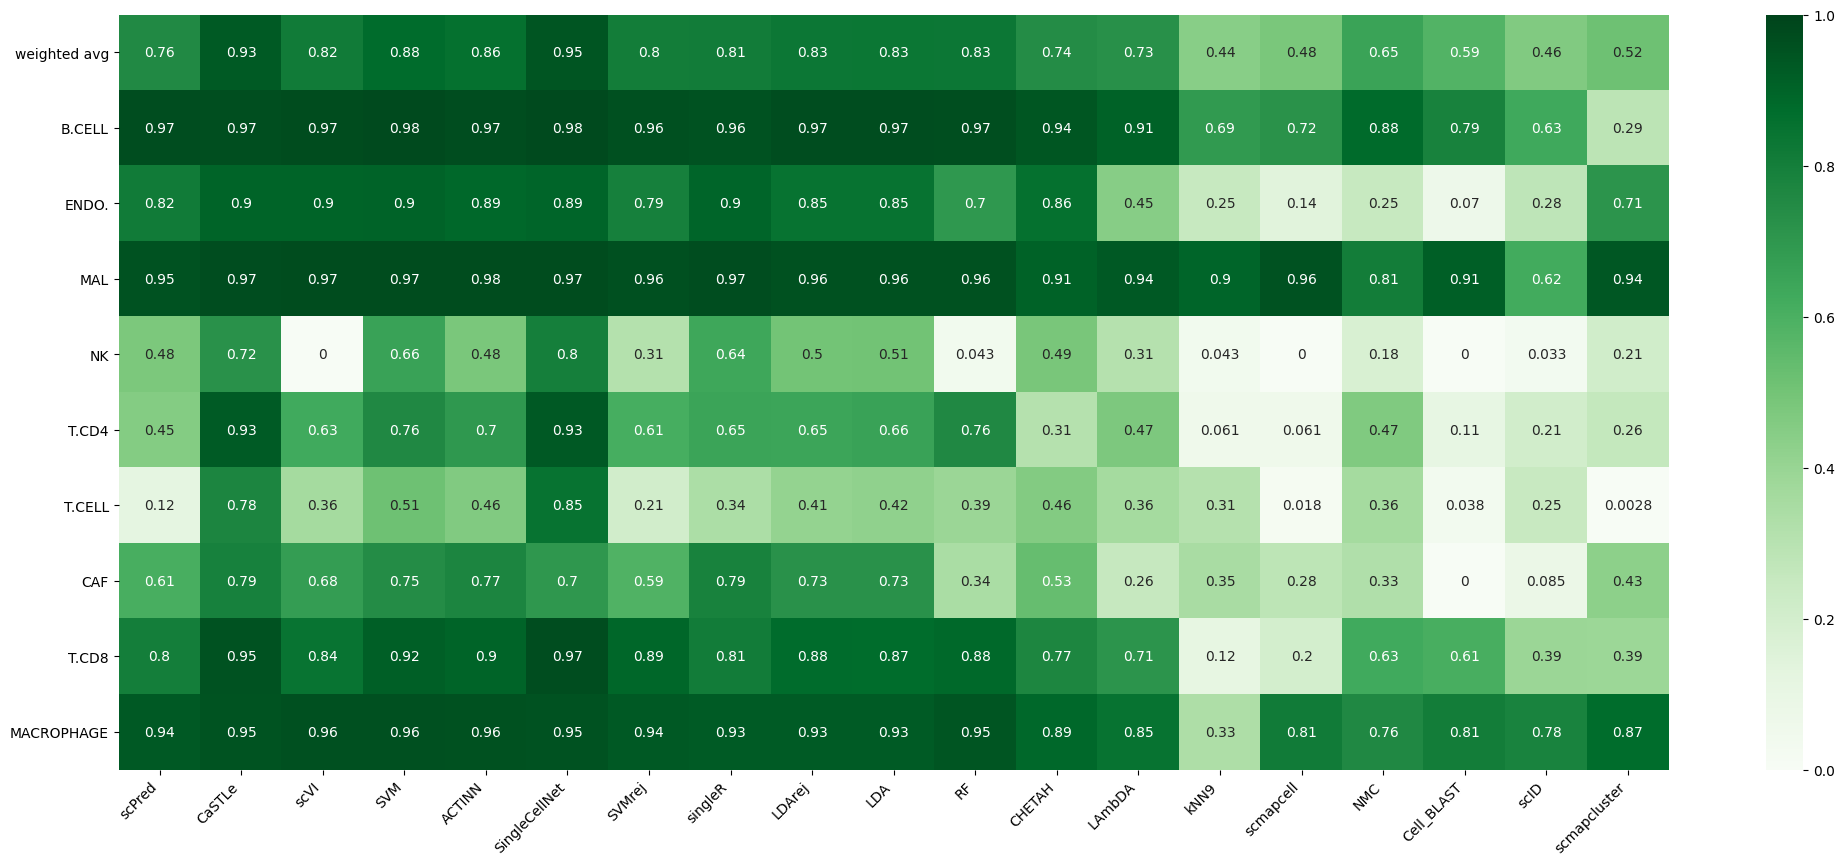

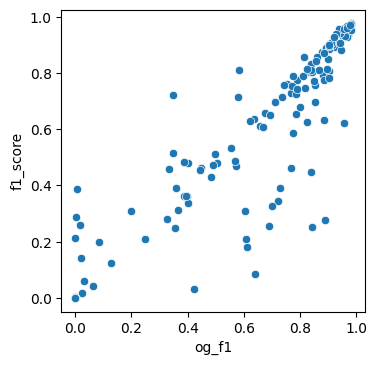

Red Cells have higher performance when training and testing on the same data.


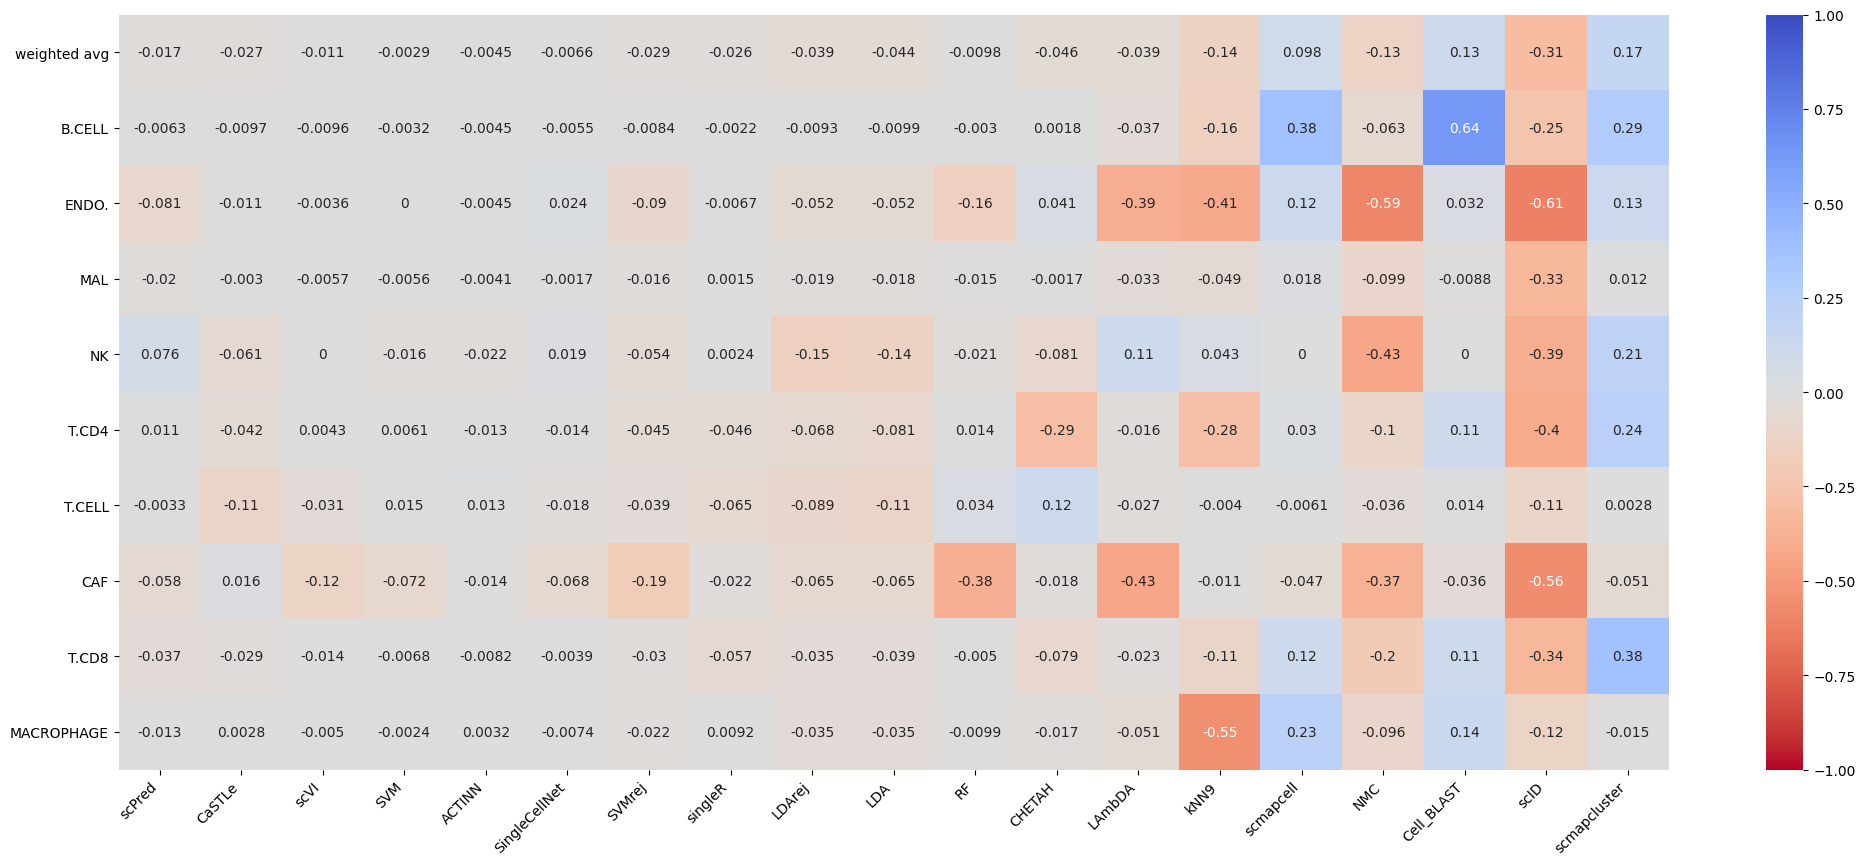

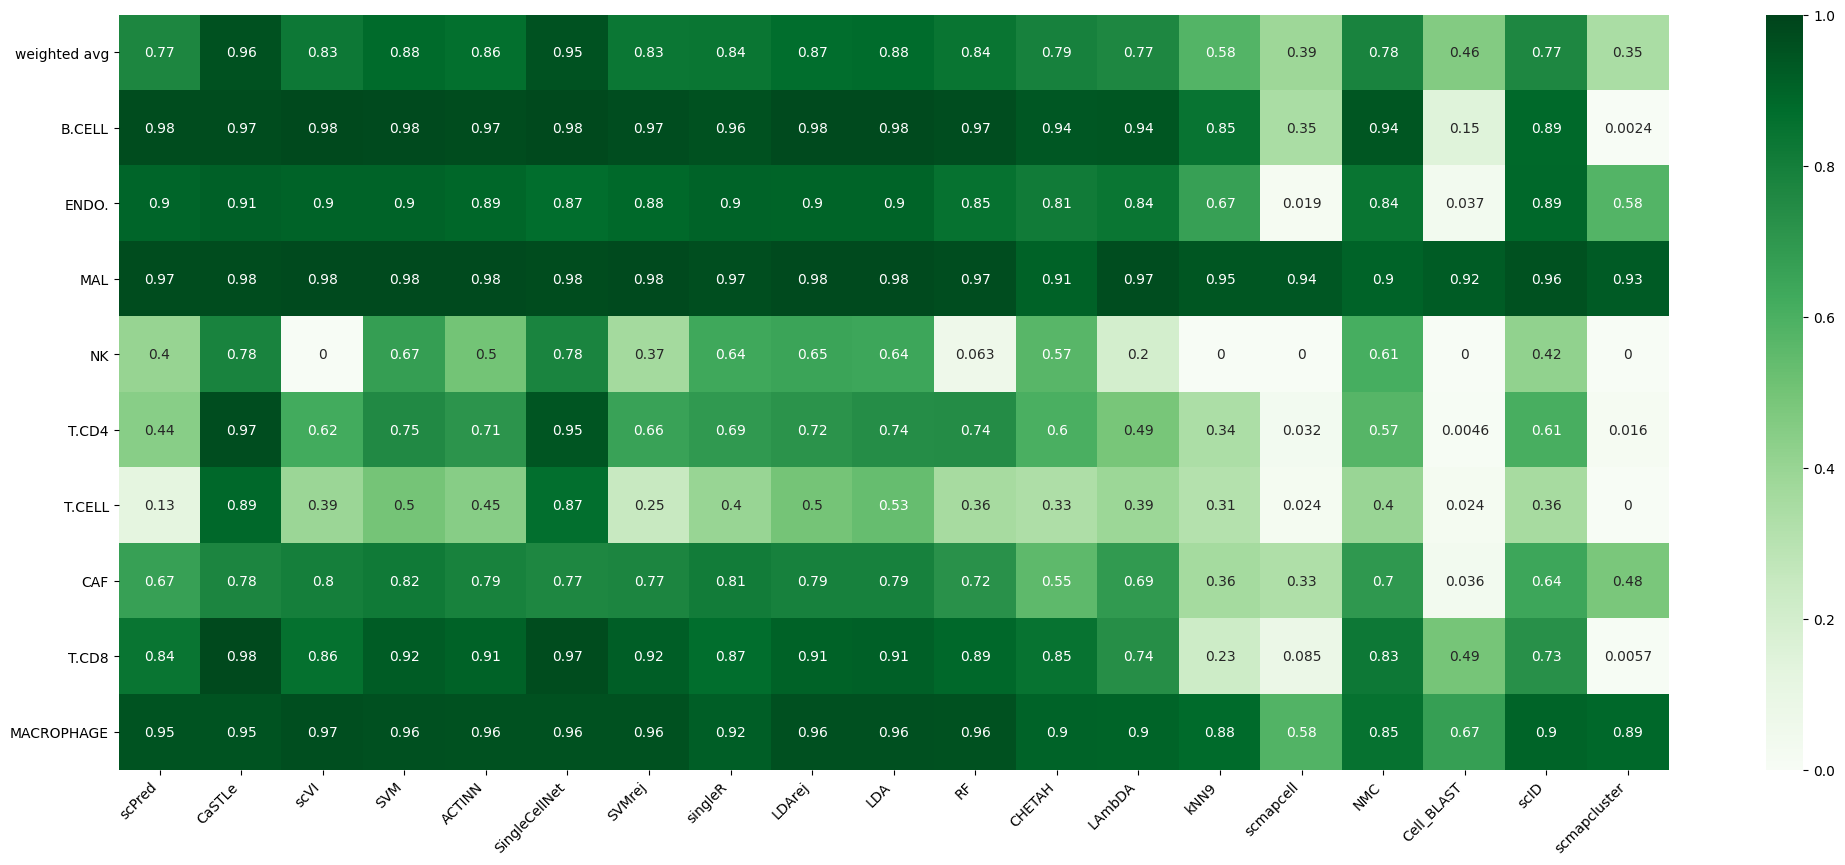

['Mel121.1', 'Mel60', 'Mel128', 'Mel110', 'Mel129pb', 'Mel82', 'Mel112']
(887, 21)


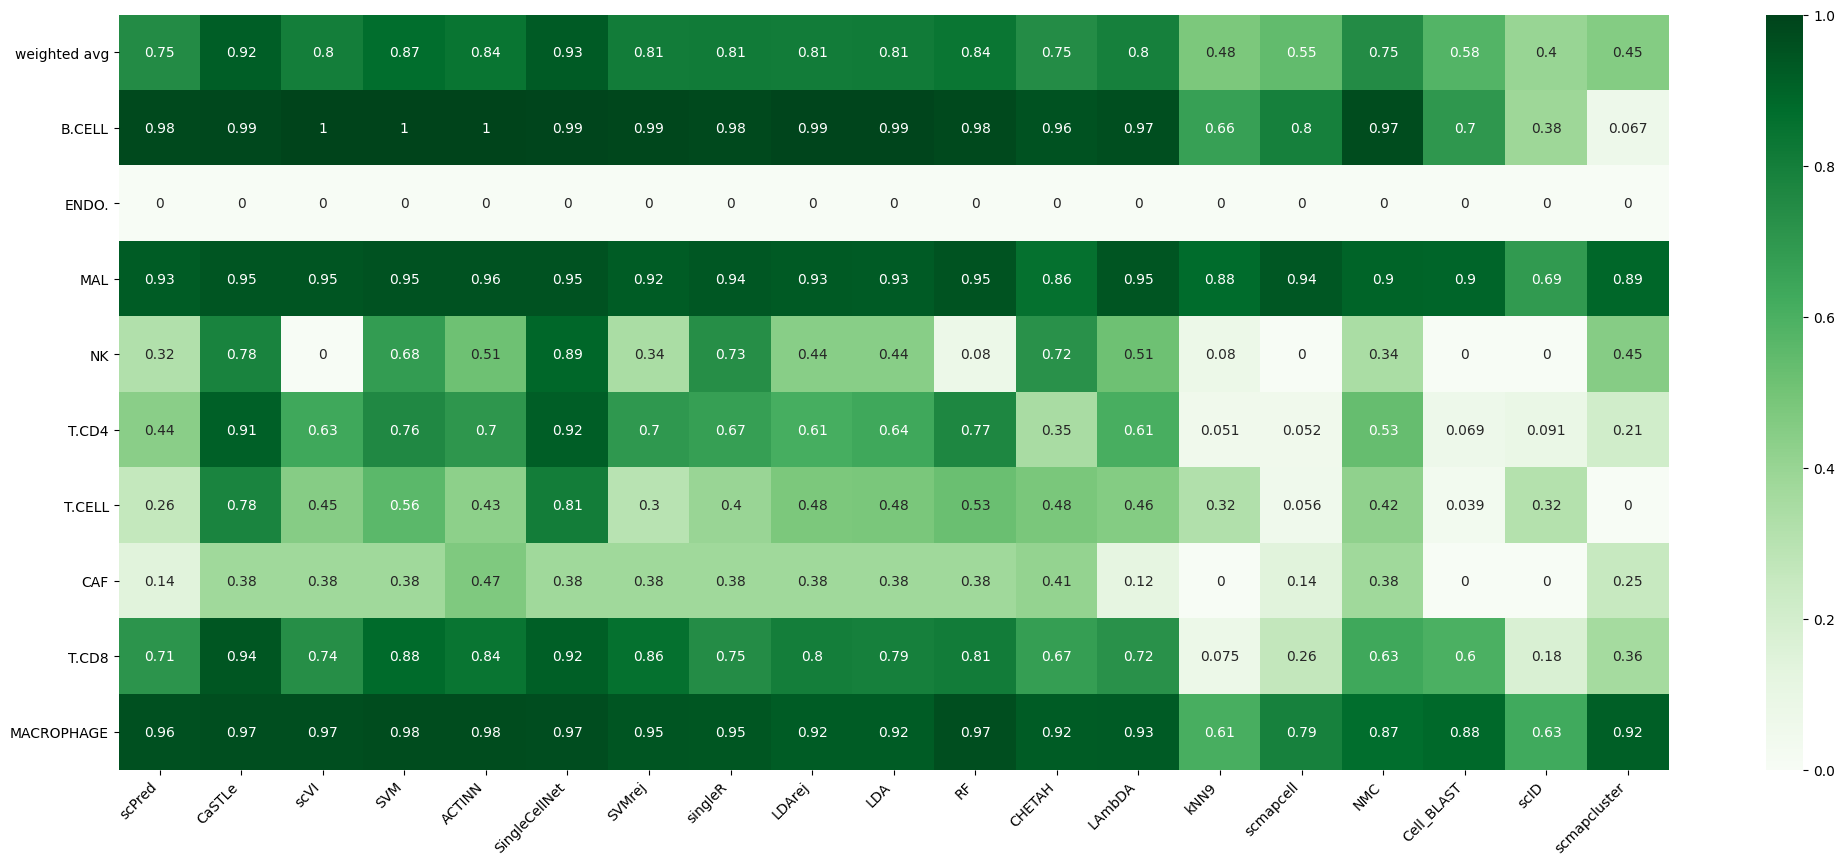

['Mel103', 'Mel478', 'Mel04.3', 'Mel53', 'Mel80', 'Mel126', 'Mel89']
(1552, 21)


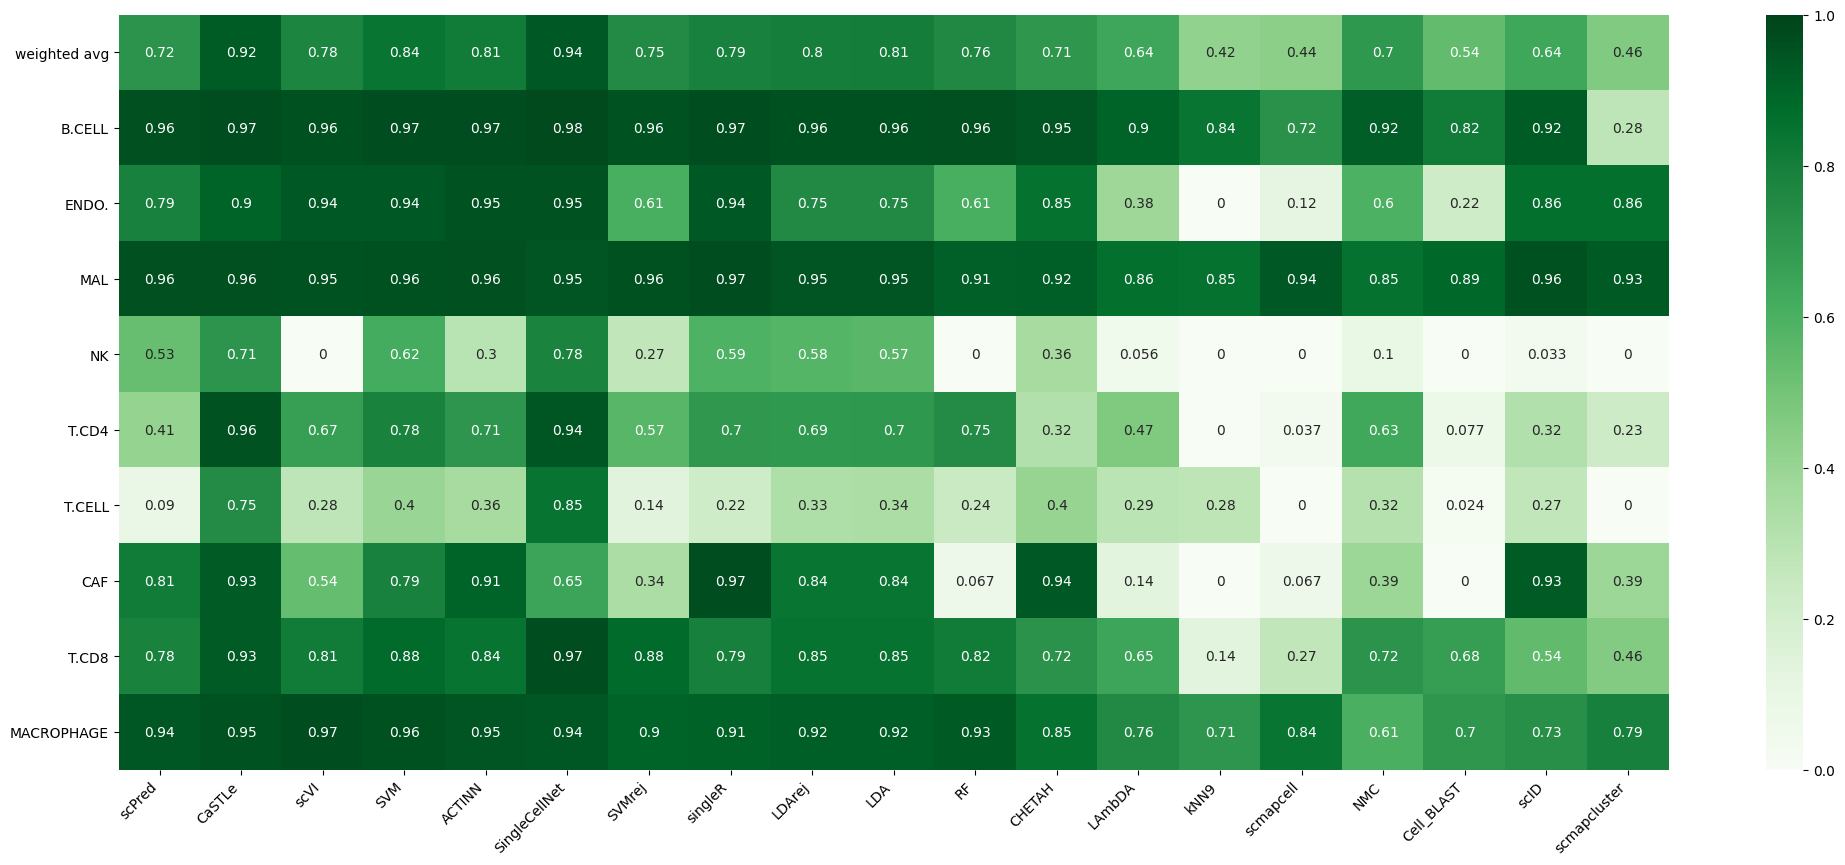

['Mel75', 'Mel72', 'Mel88', 'Mel194', 'Mel98', 'Mel74']
(1639, 21)


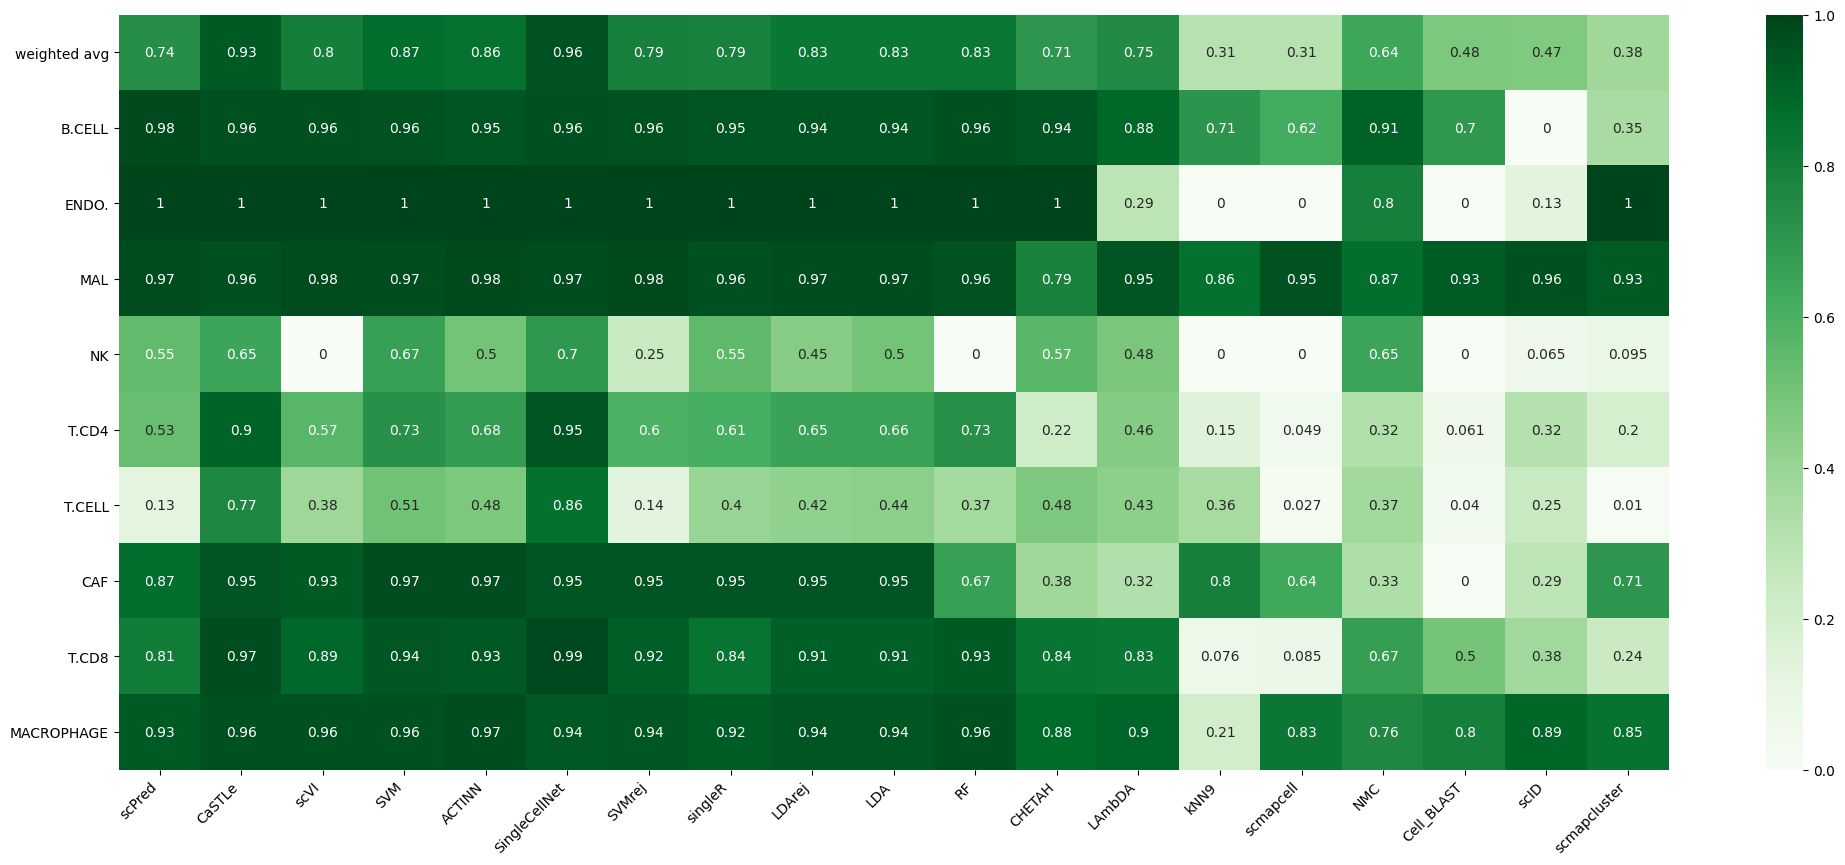

['Mel129pa', 'Mel102', 'Mel84', 'Mel79', 'Mel105', 'Mel106']
(1907, 21)


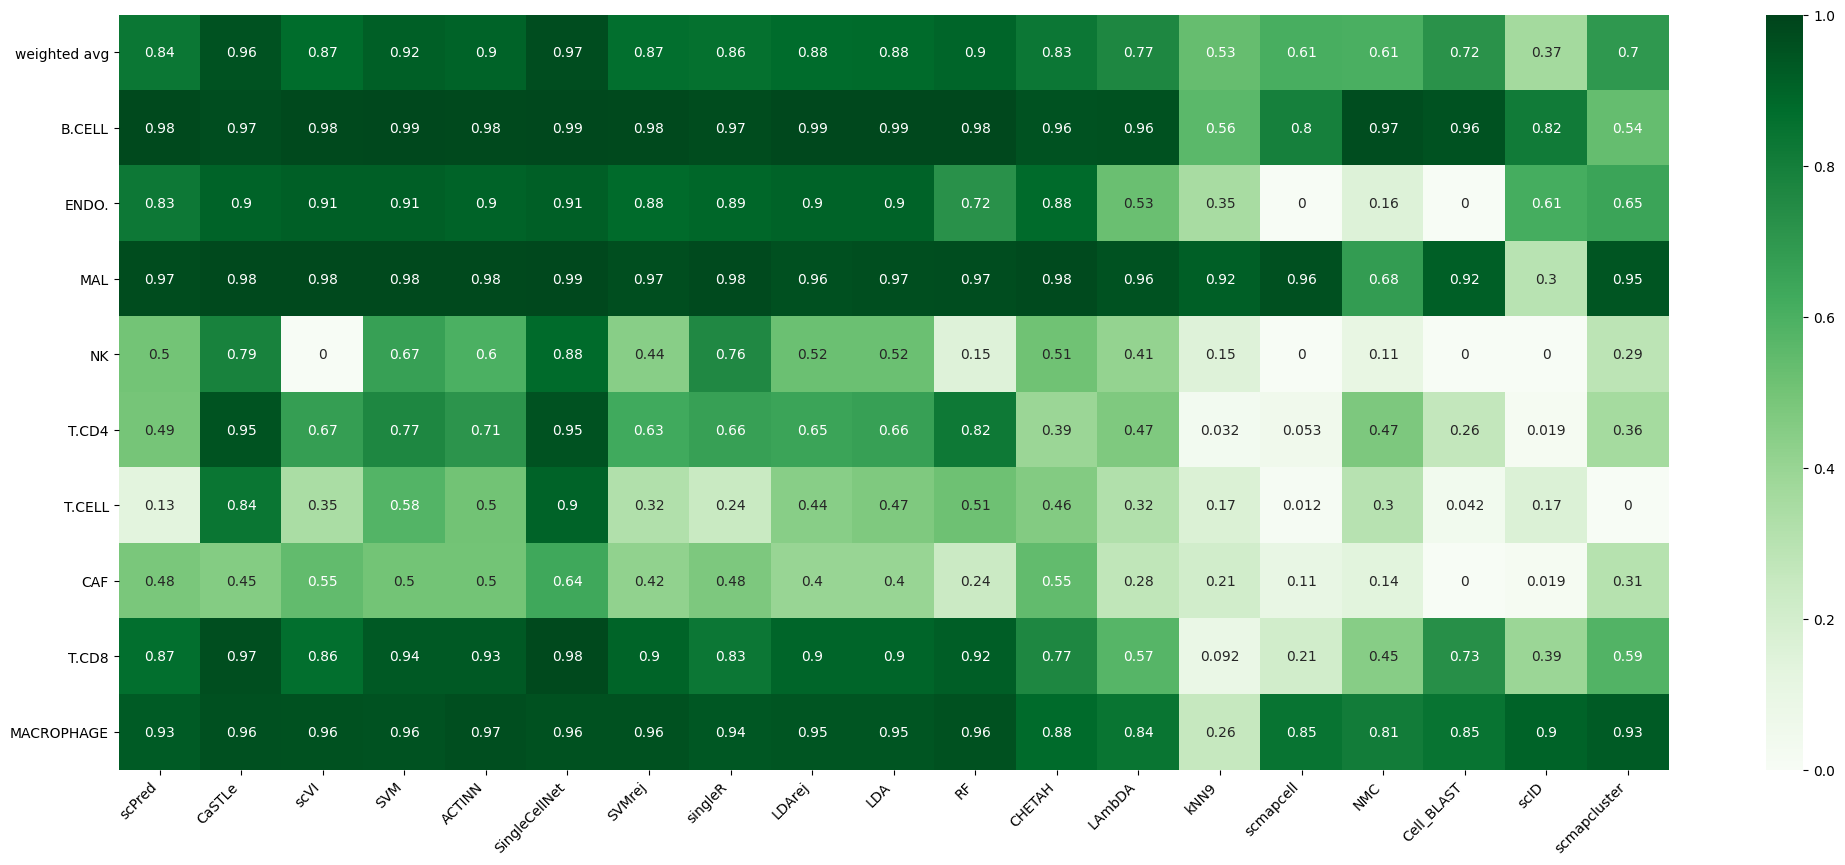

['Mel94', 'Mel71', 'Mel58', 'Mel116', 'Mel78', 'Mel81']
(894, 21)


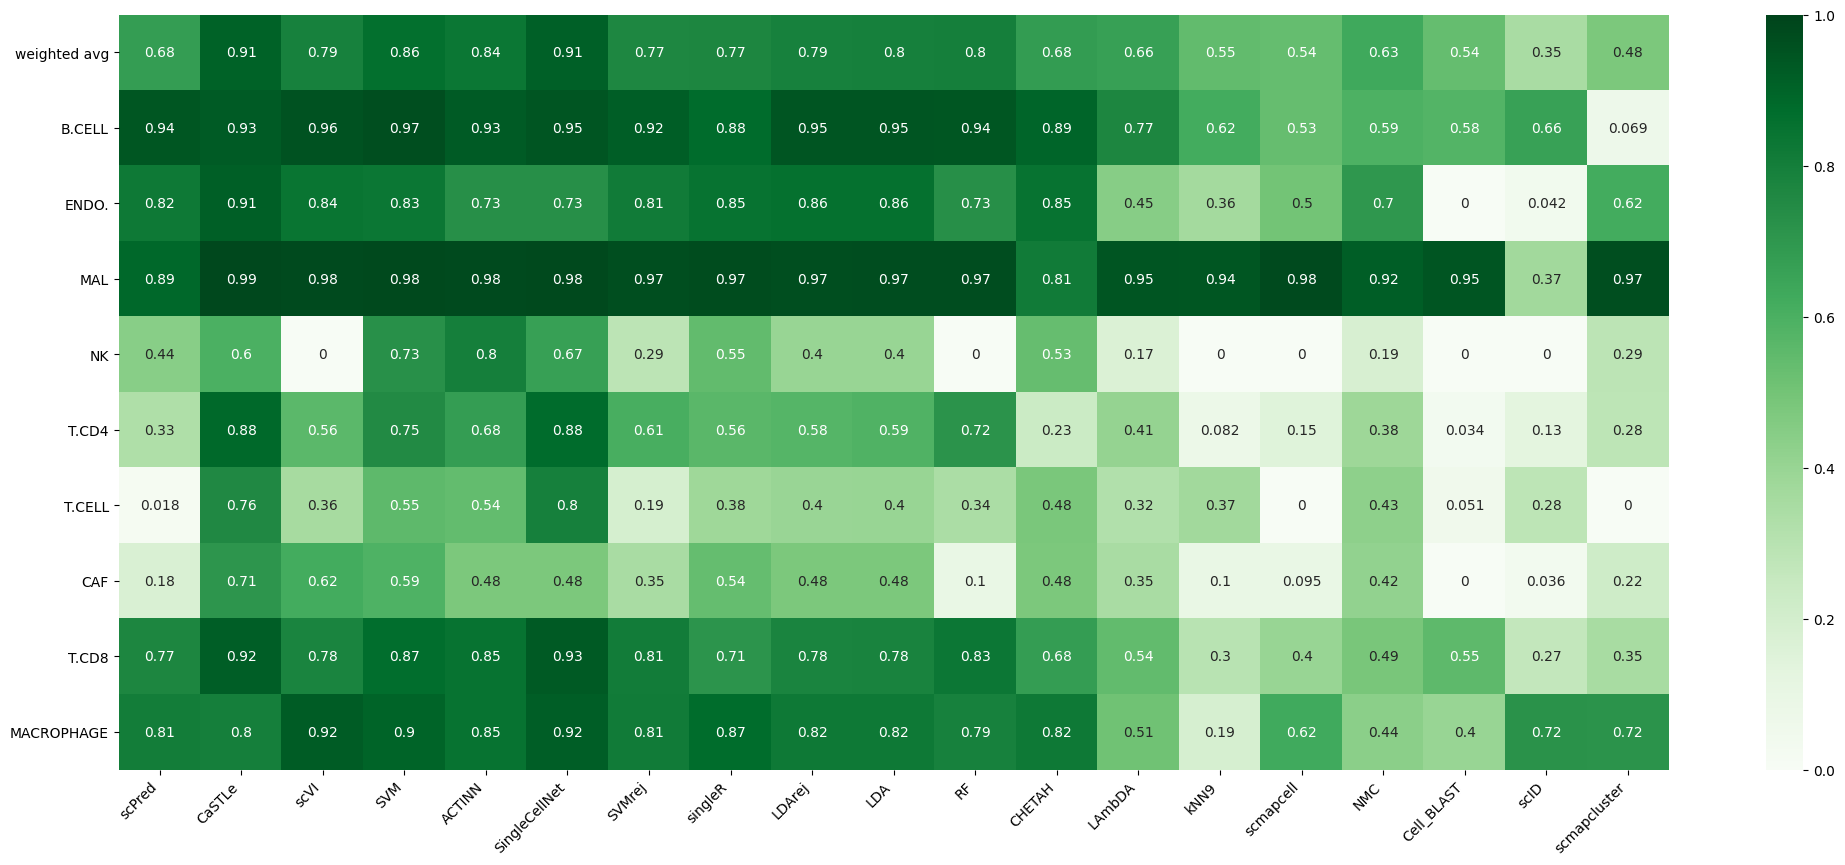

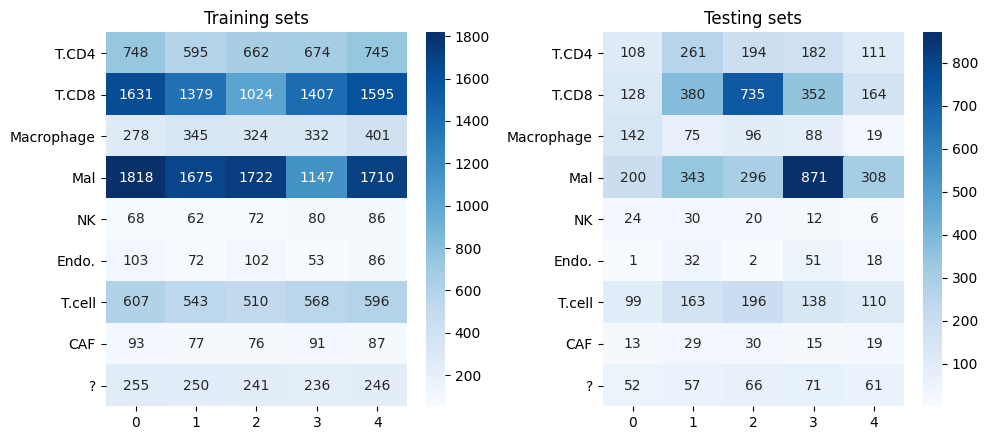

In [7]:
f = open('melanoma/JA_patient_test.tsv')
lines = f.readlines()
groups = [line.strip('[]\n').replace("'",'').replace(' ','').split(',')\
          for line in lines]
hmdf,diff = analyse('melanoma/JA_Melanoma.tsv',
        '../../predictions/jam_predictions.tsv',
        remap={'TUMOR':"MAL",'TCELL':'T.CELL','BCELL':"B.CELL"},
        test_groups = groups, 
        patients = '../melanoma/melanoma_patients.tsv'
       )

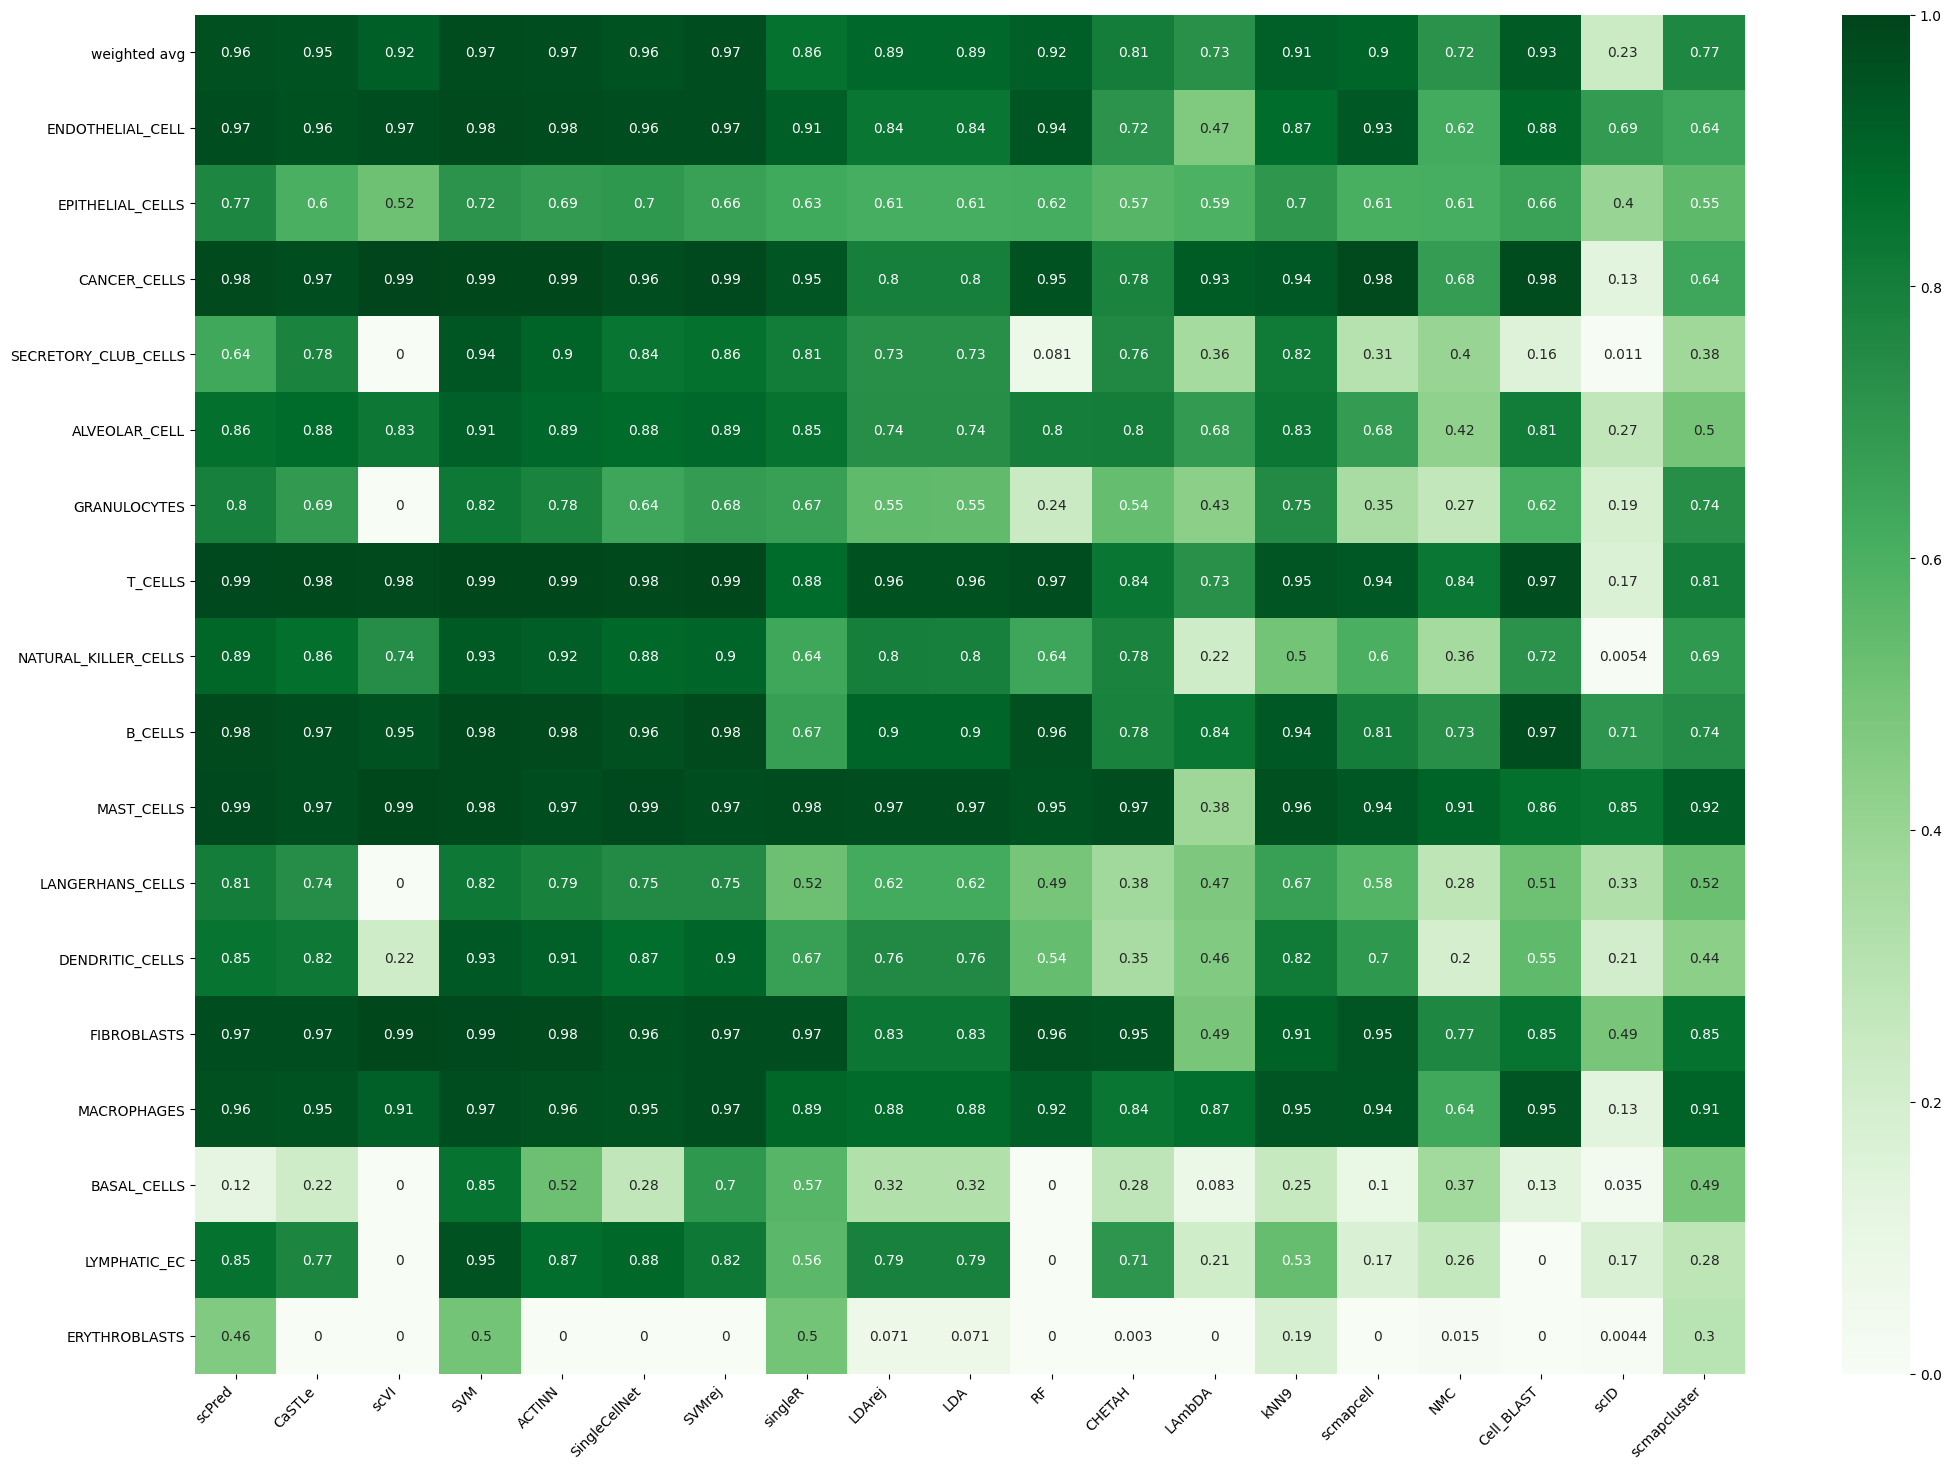

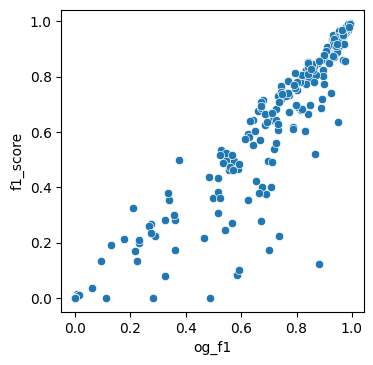

Red Cells have higher performance when training and testing on the same data.


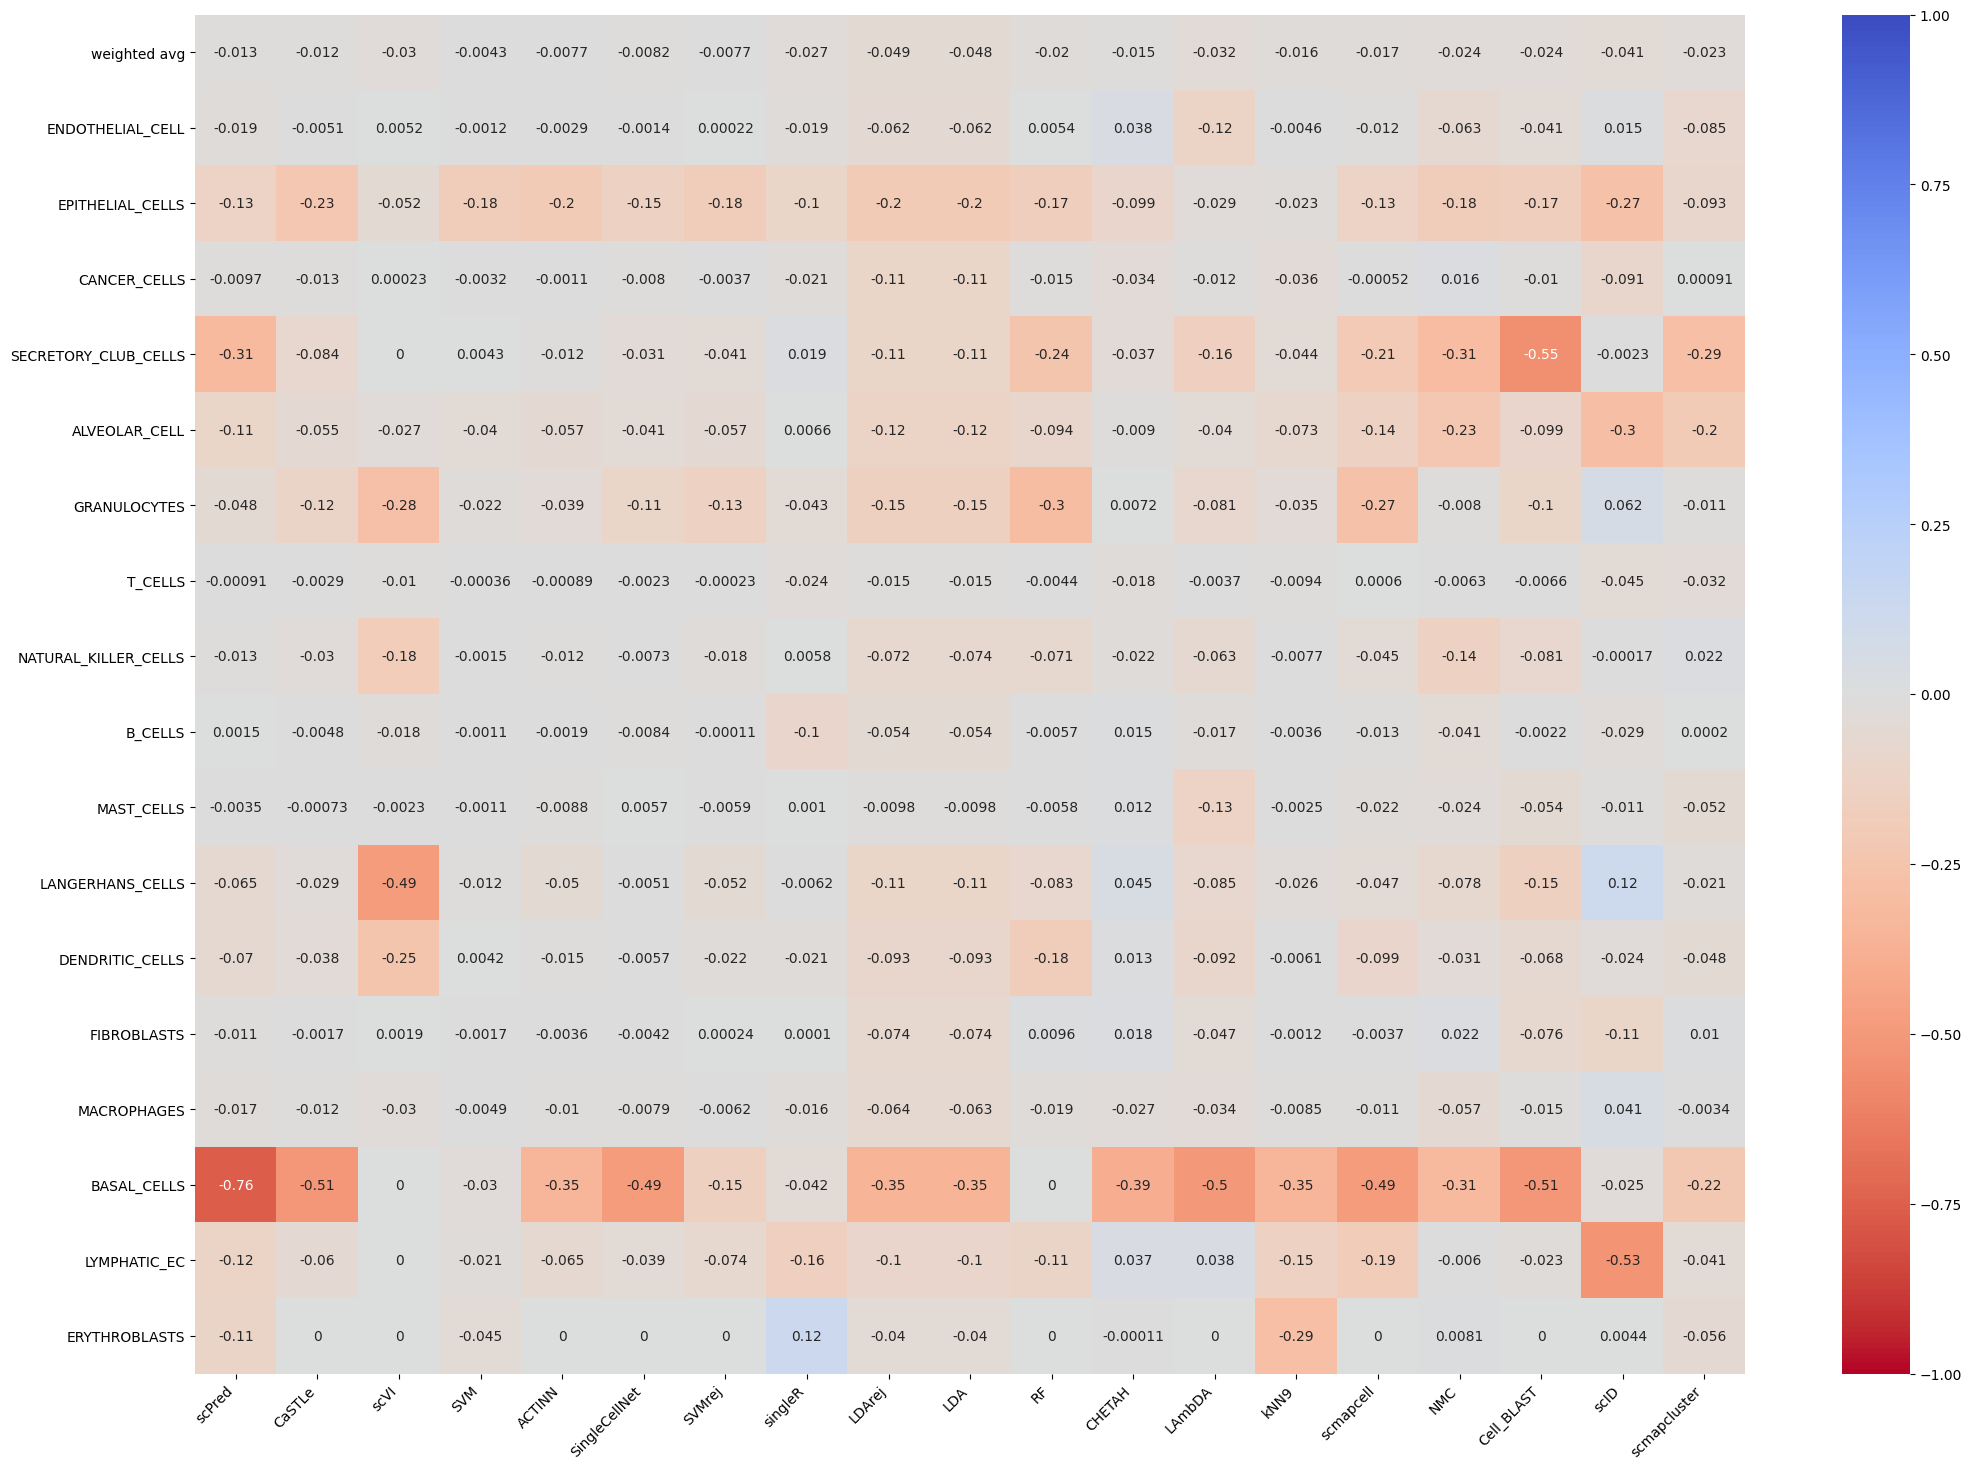

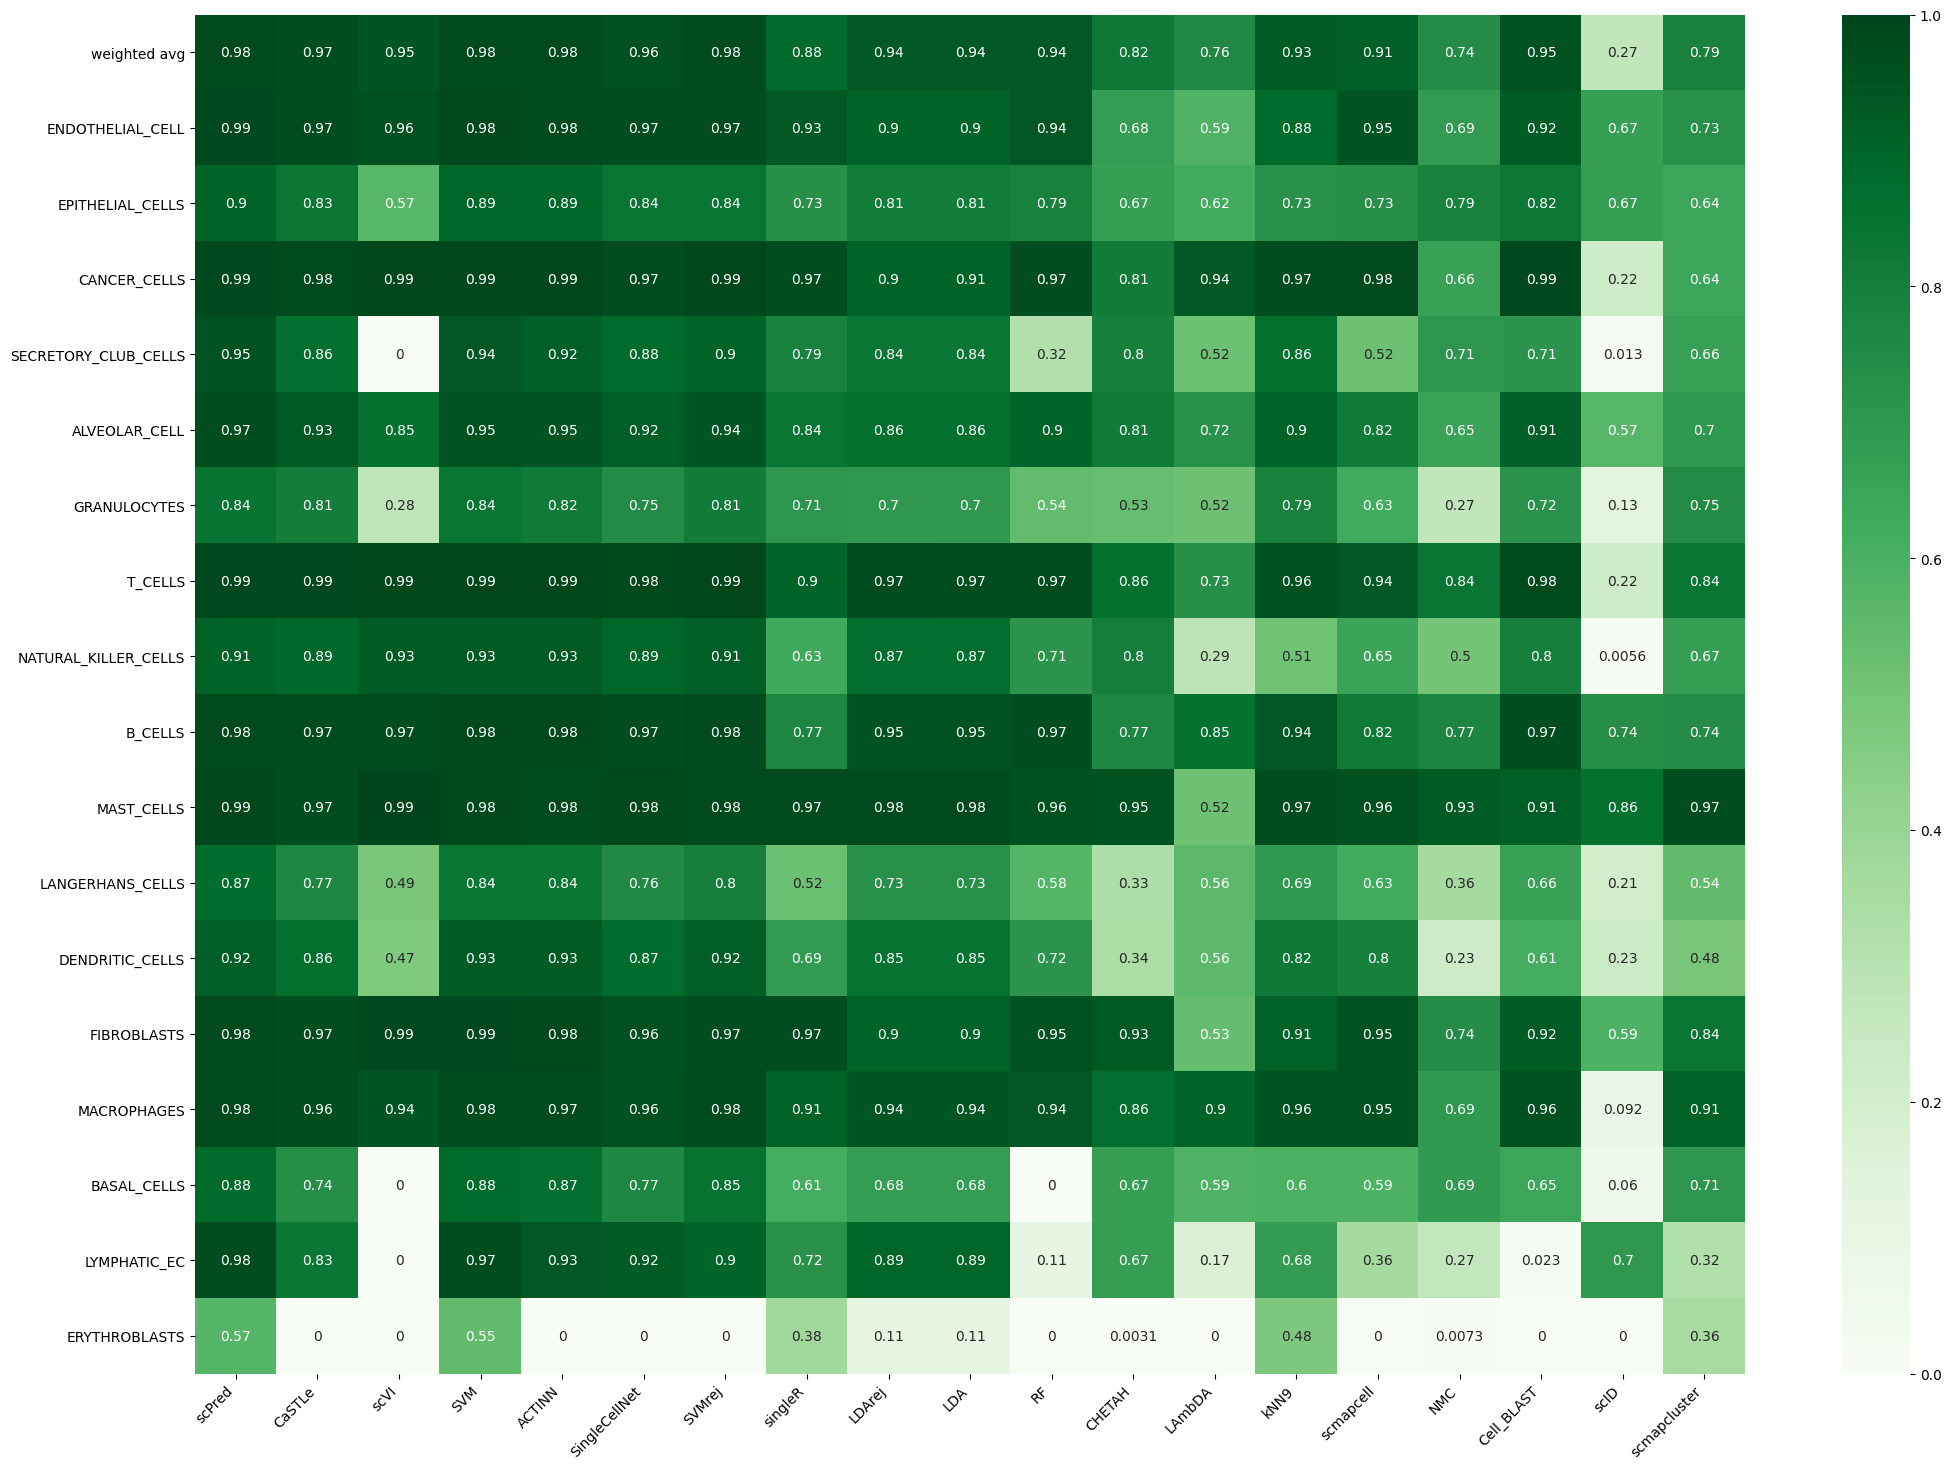

['4d', '3b', '4b']
(9776, 21)


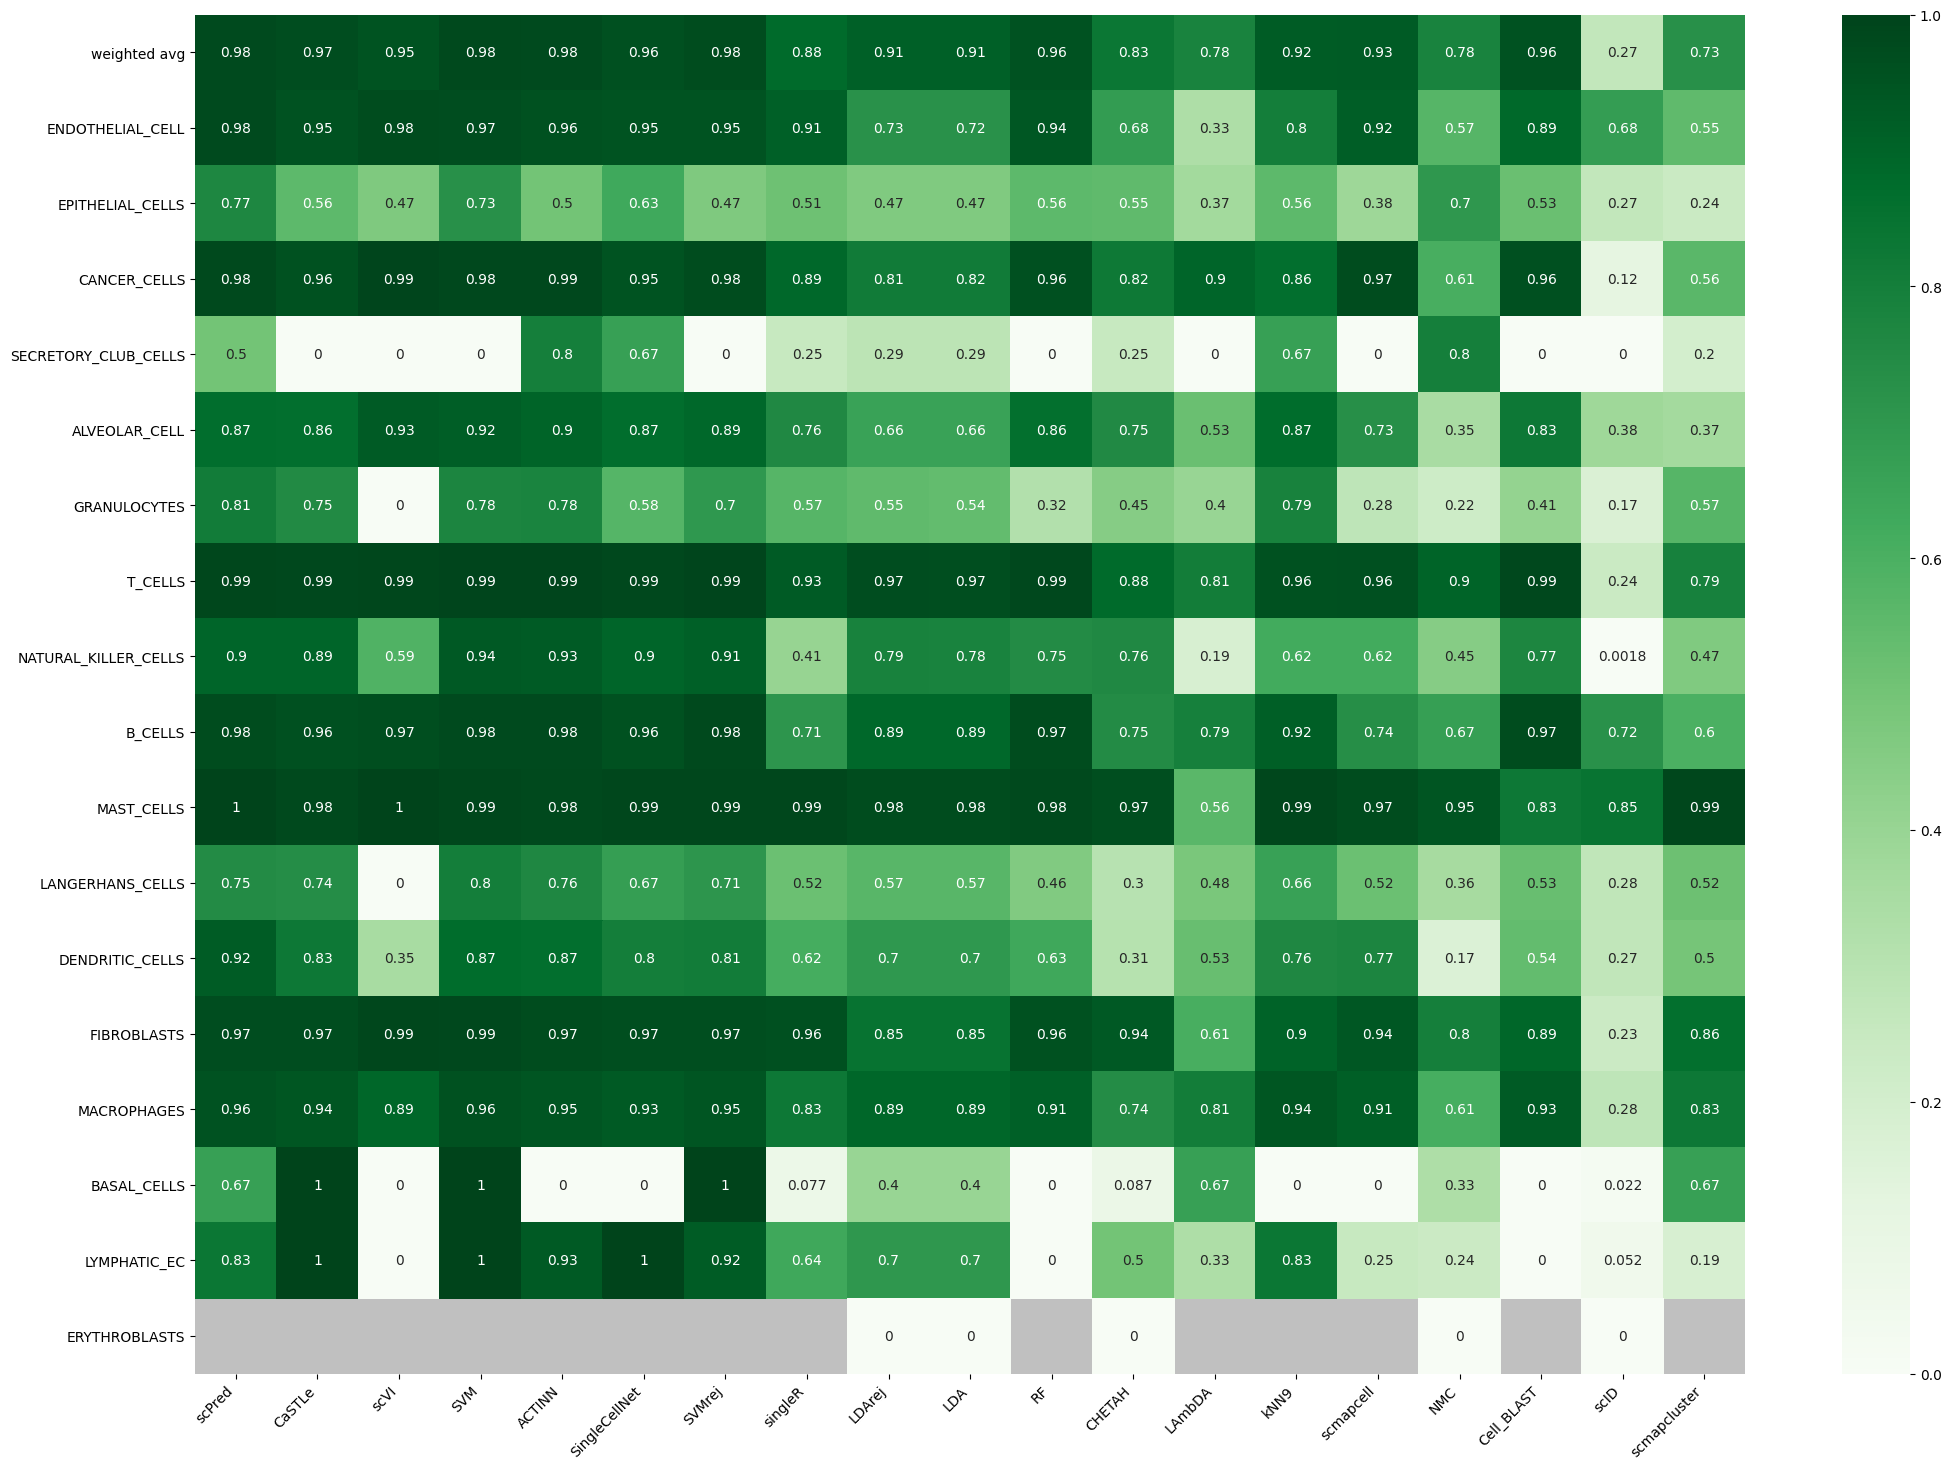

['5a', '4c', '3c']
(8811, 21)


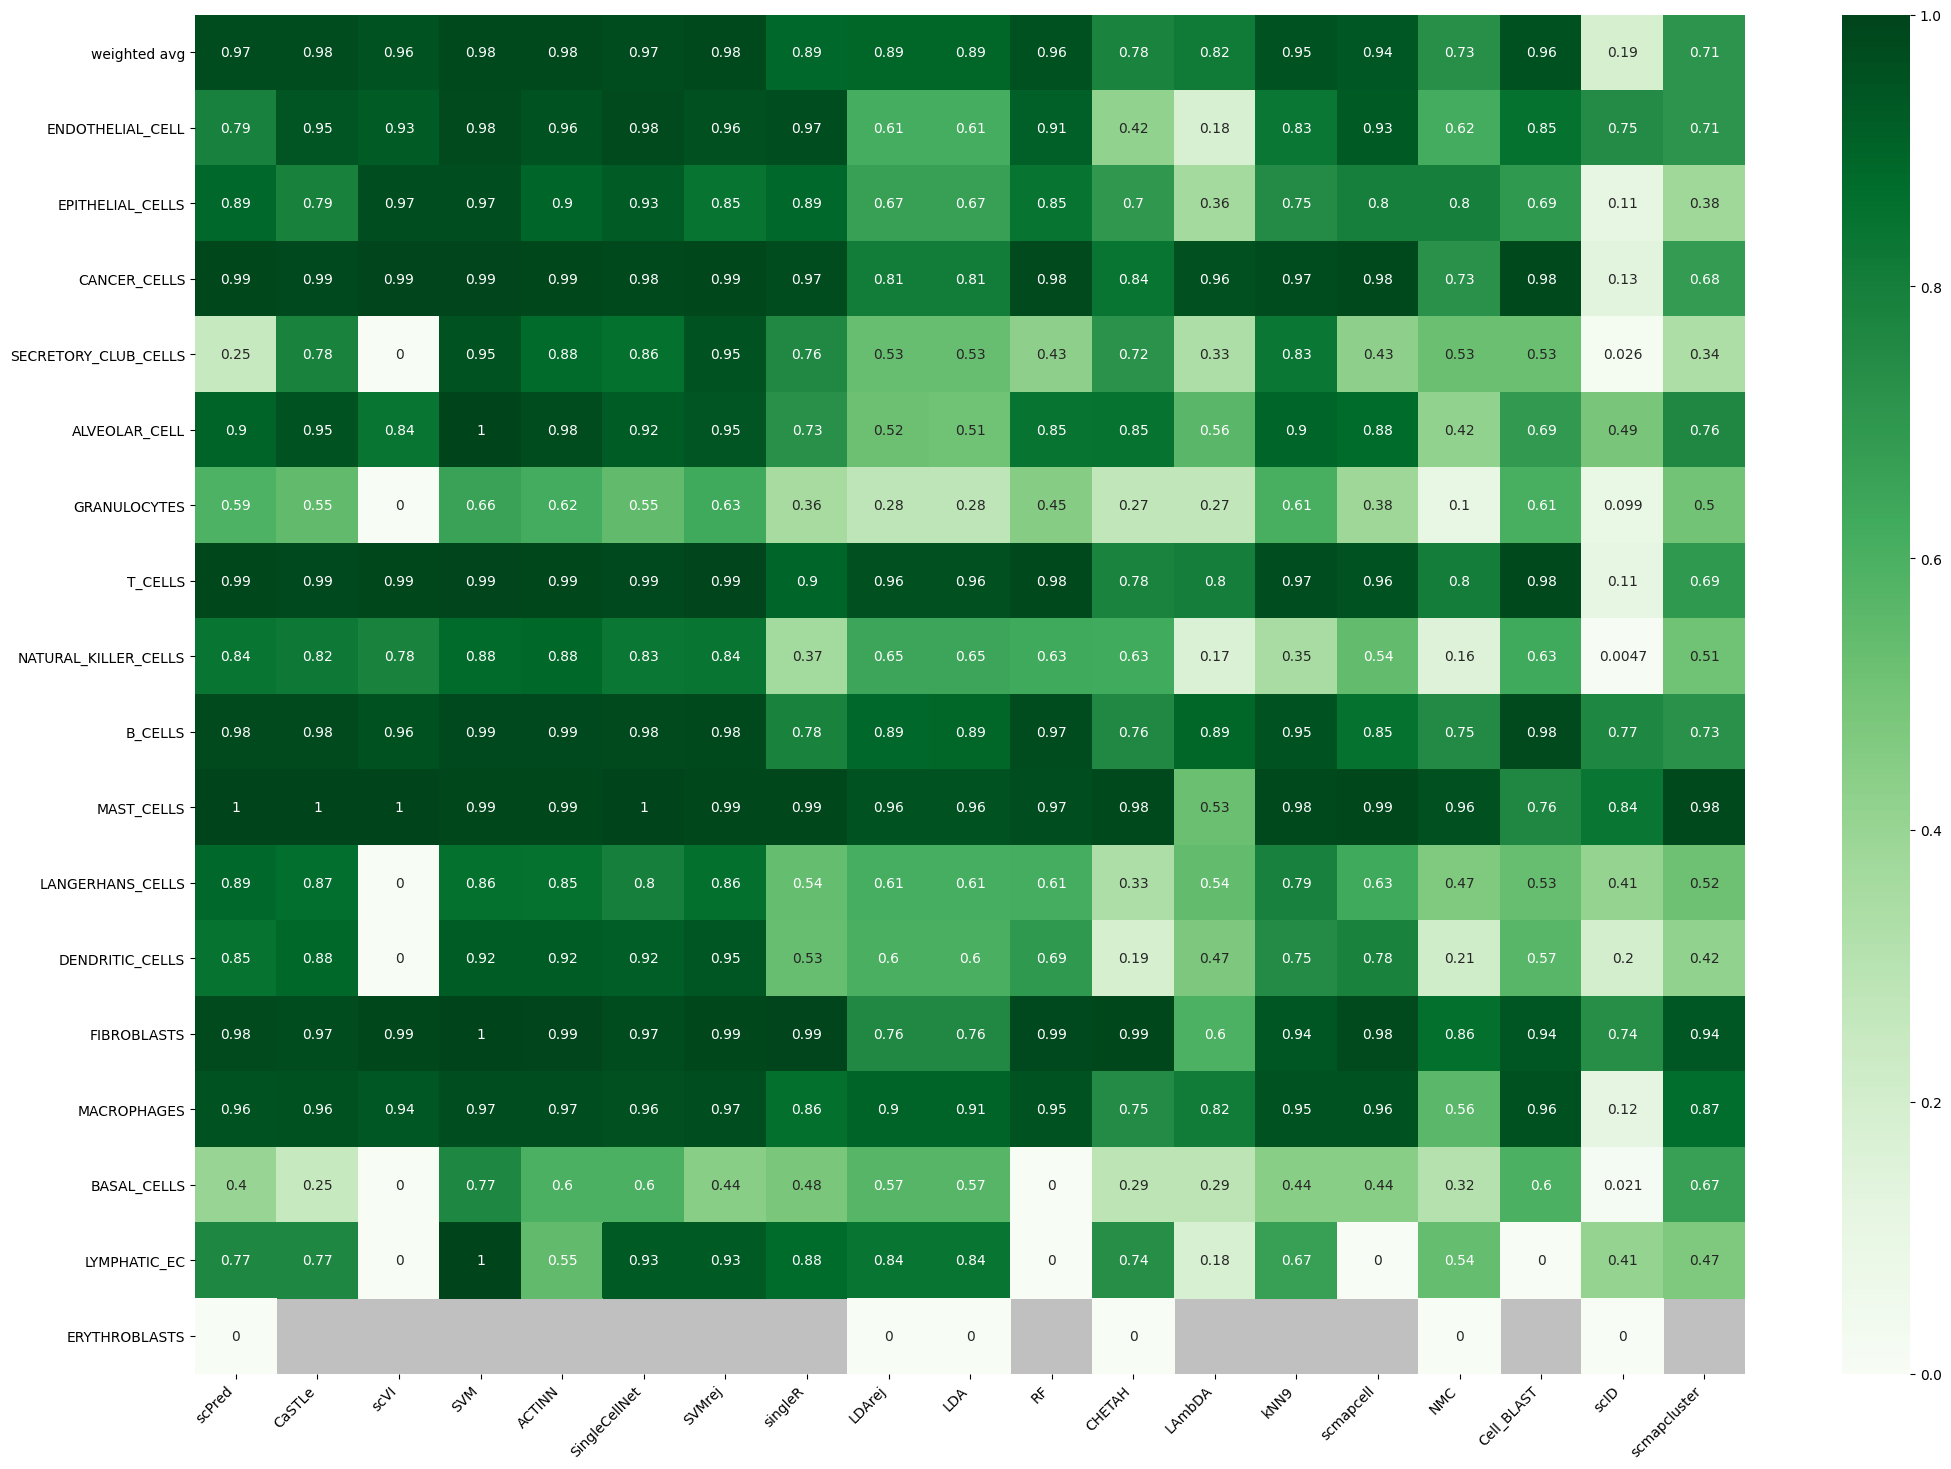

['5d', '5c']
(8892, 21)


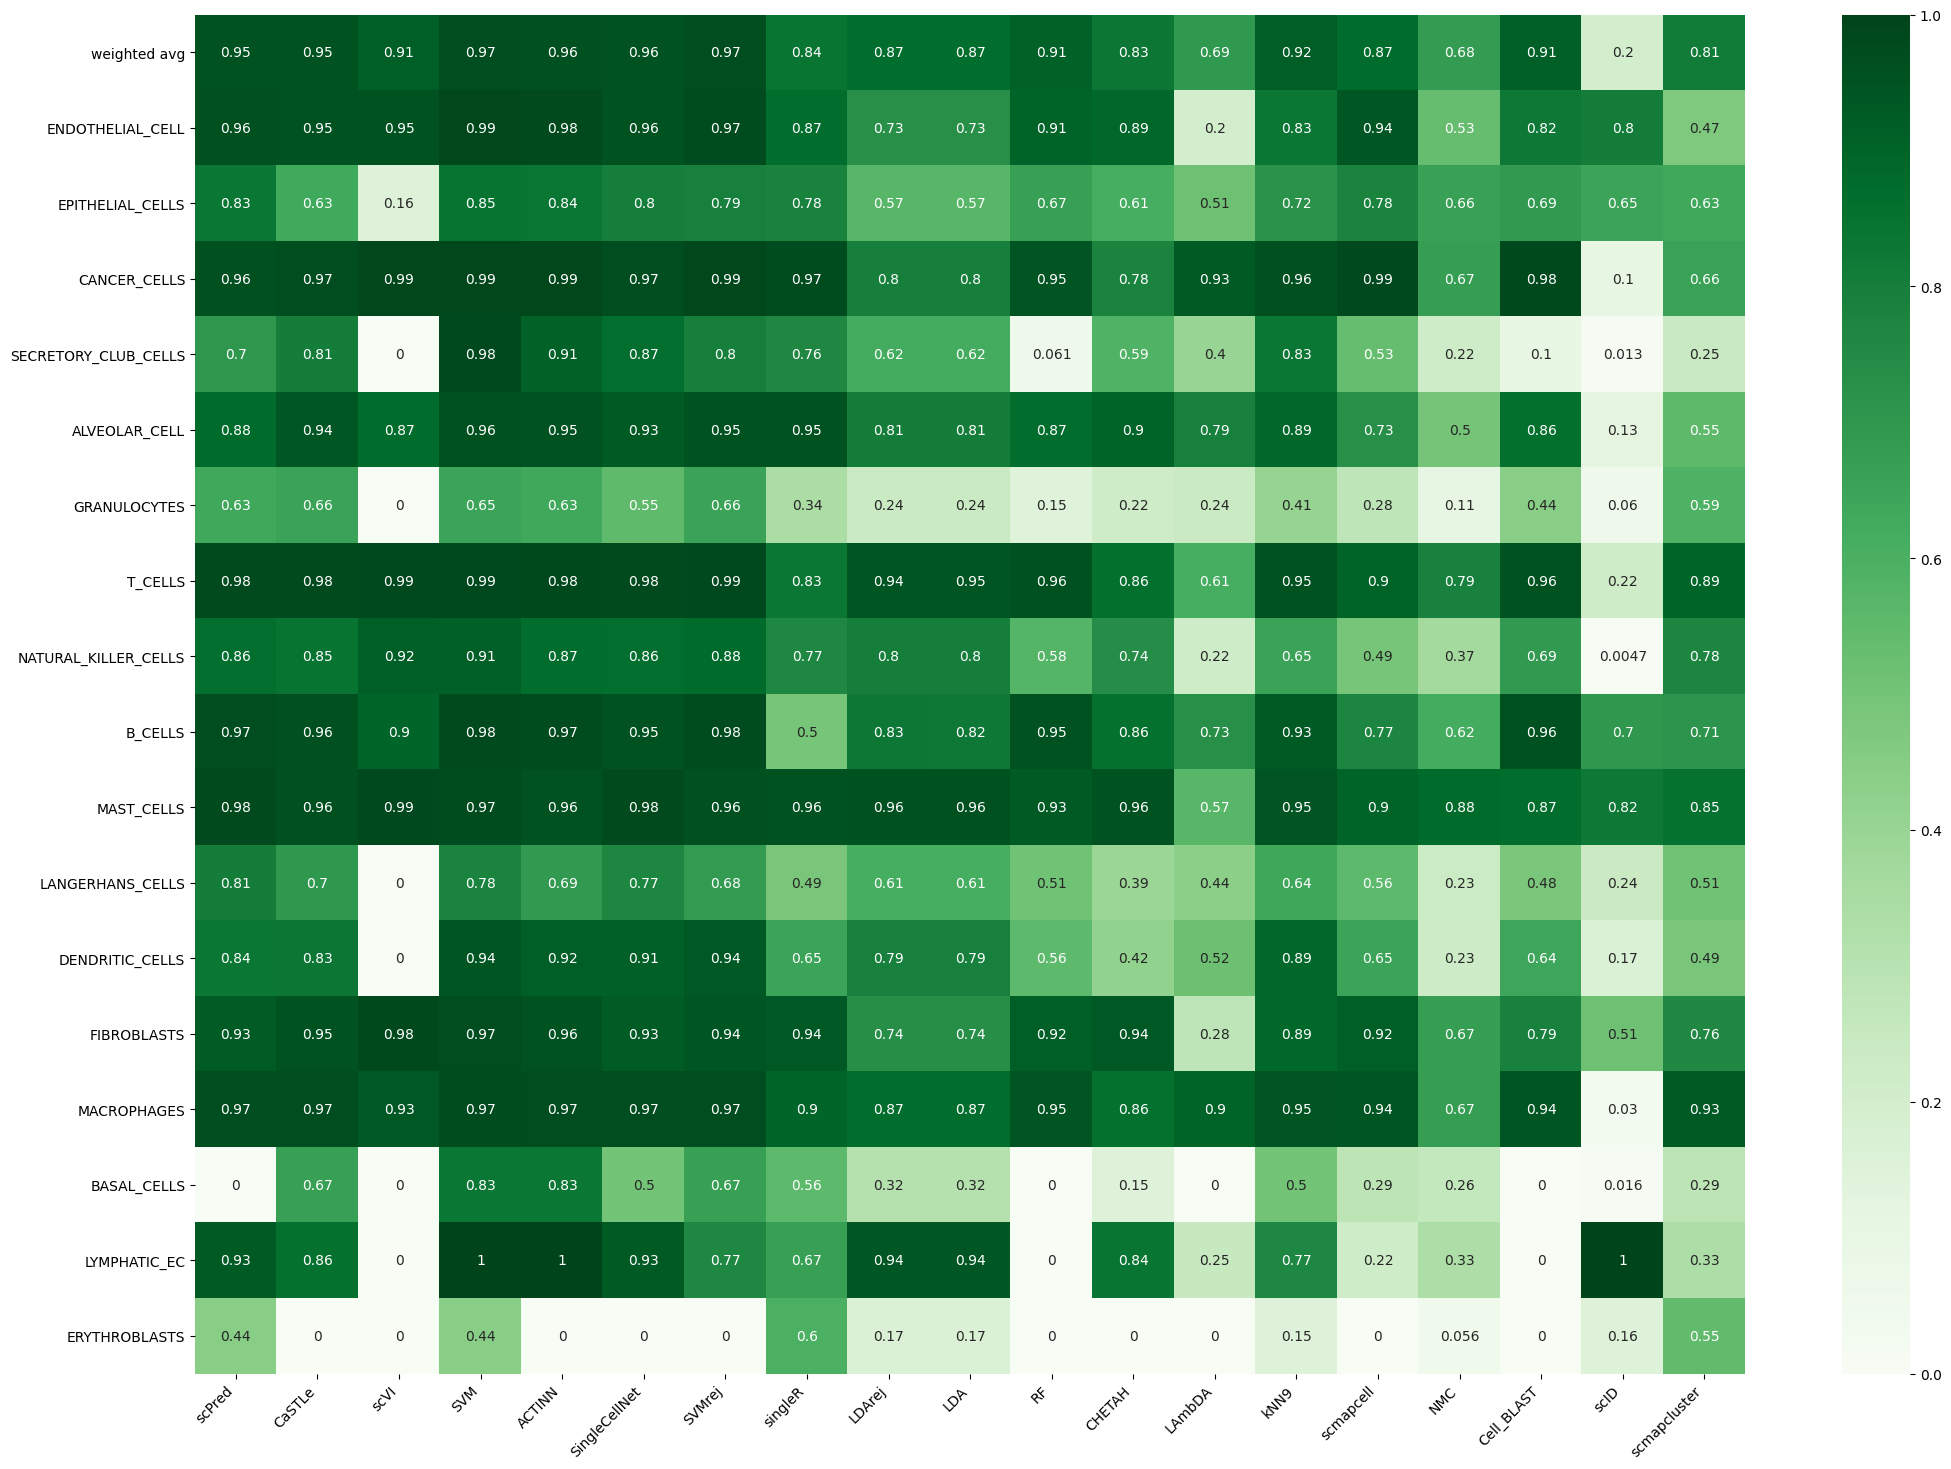

['3d', '3a']
(6348, 21)


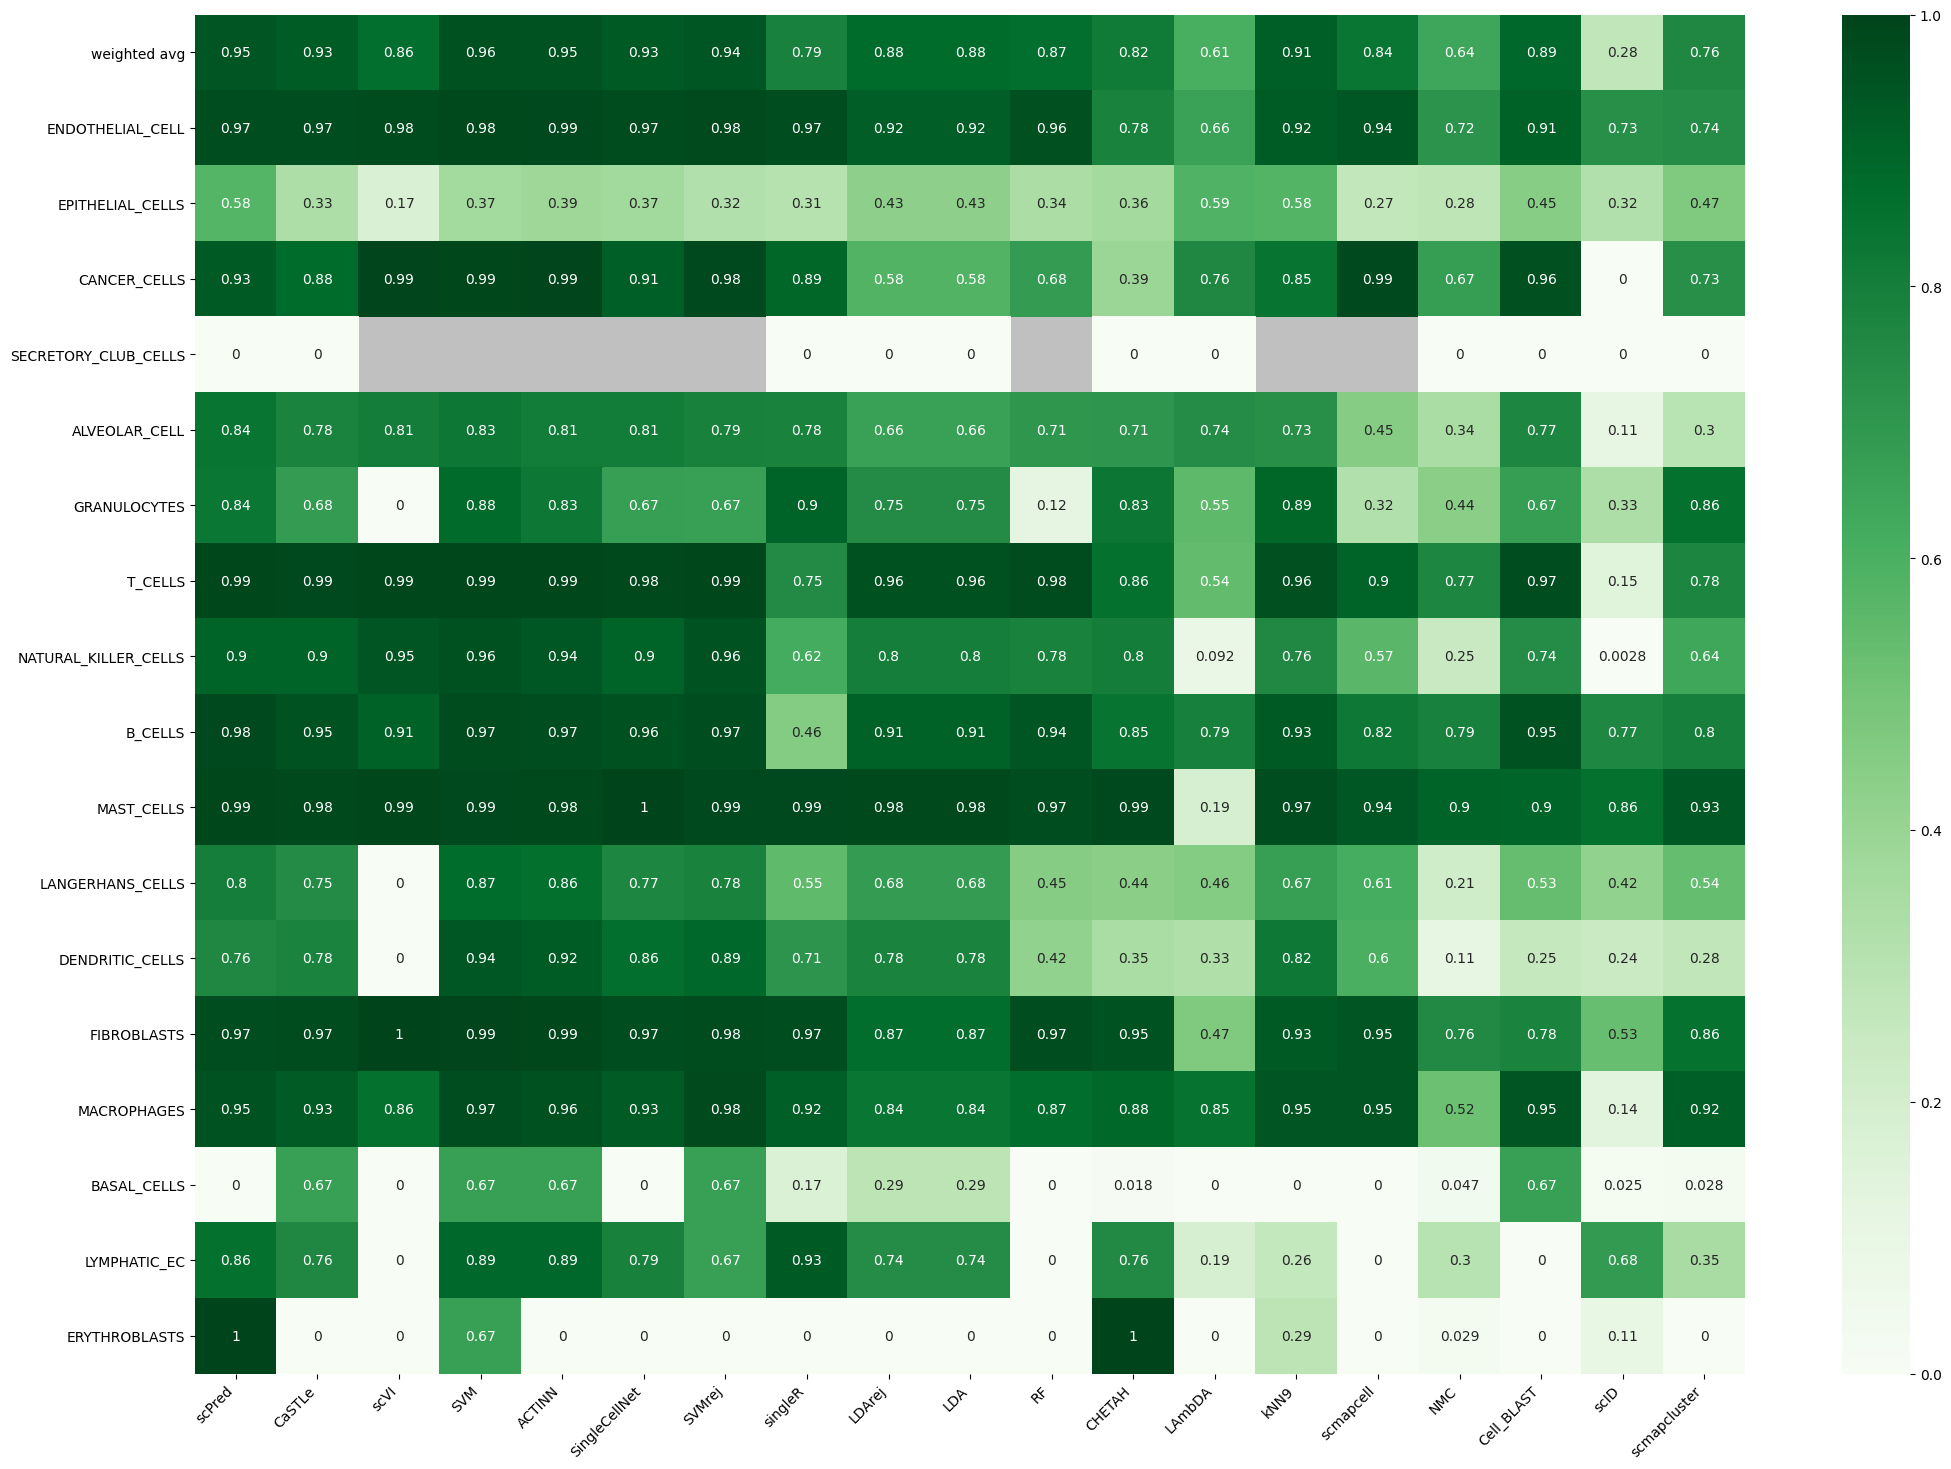

['4a', '5b']
(6042, 21)


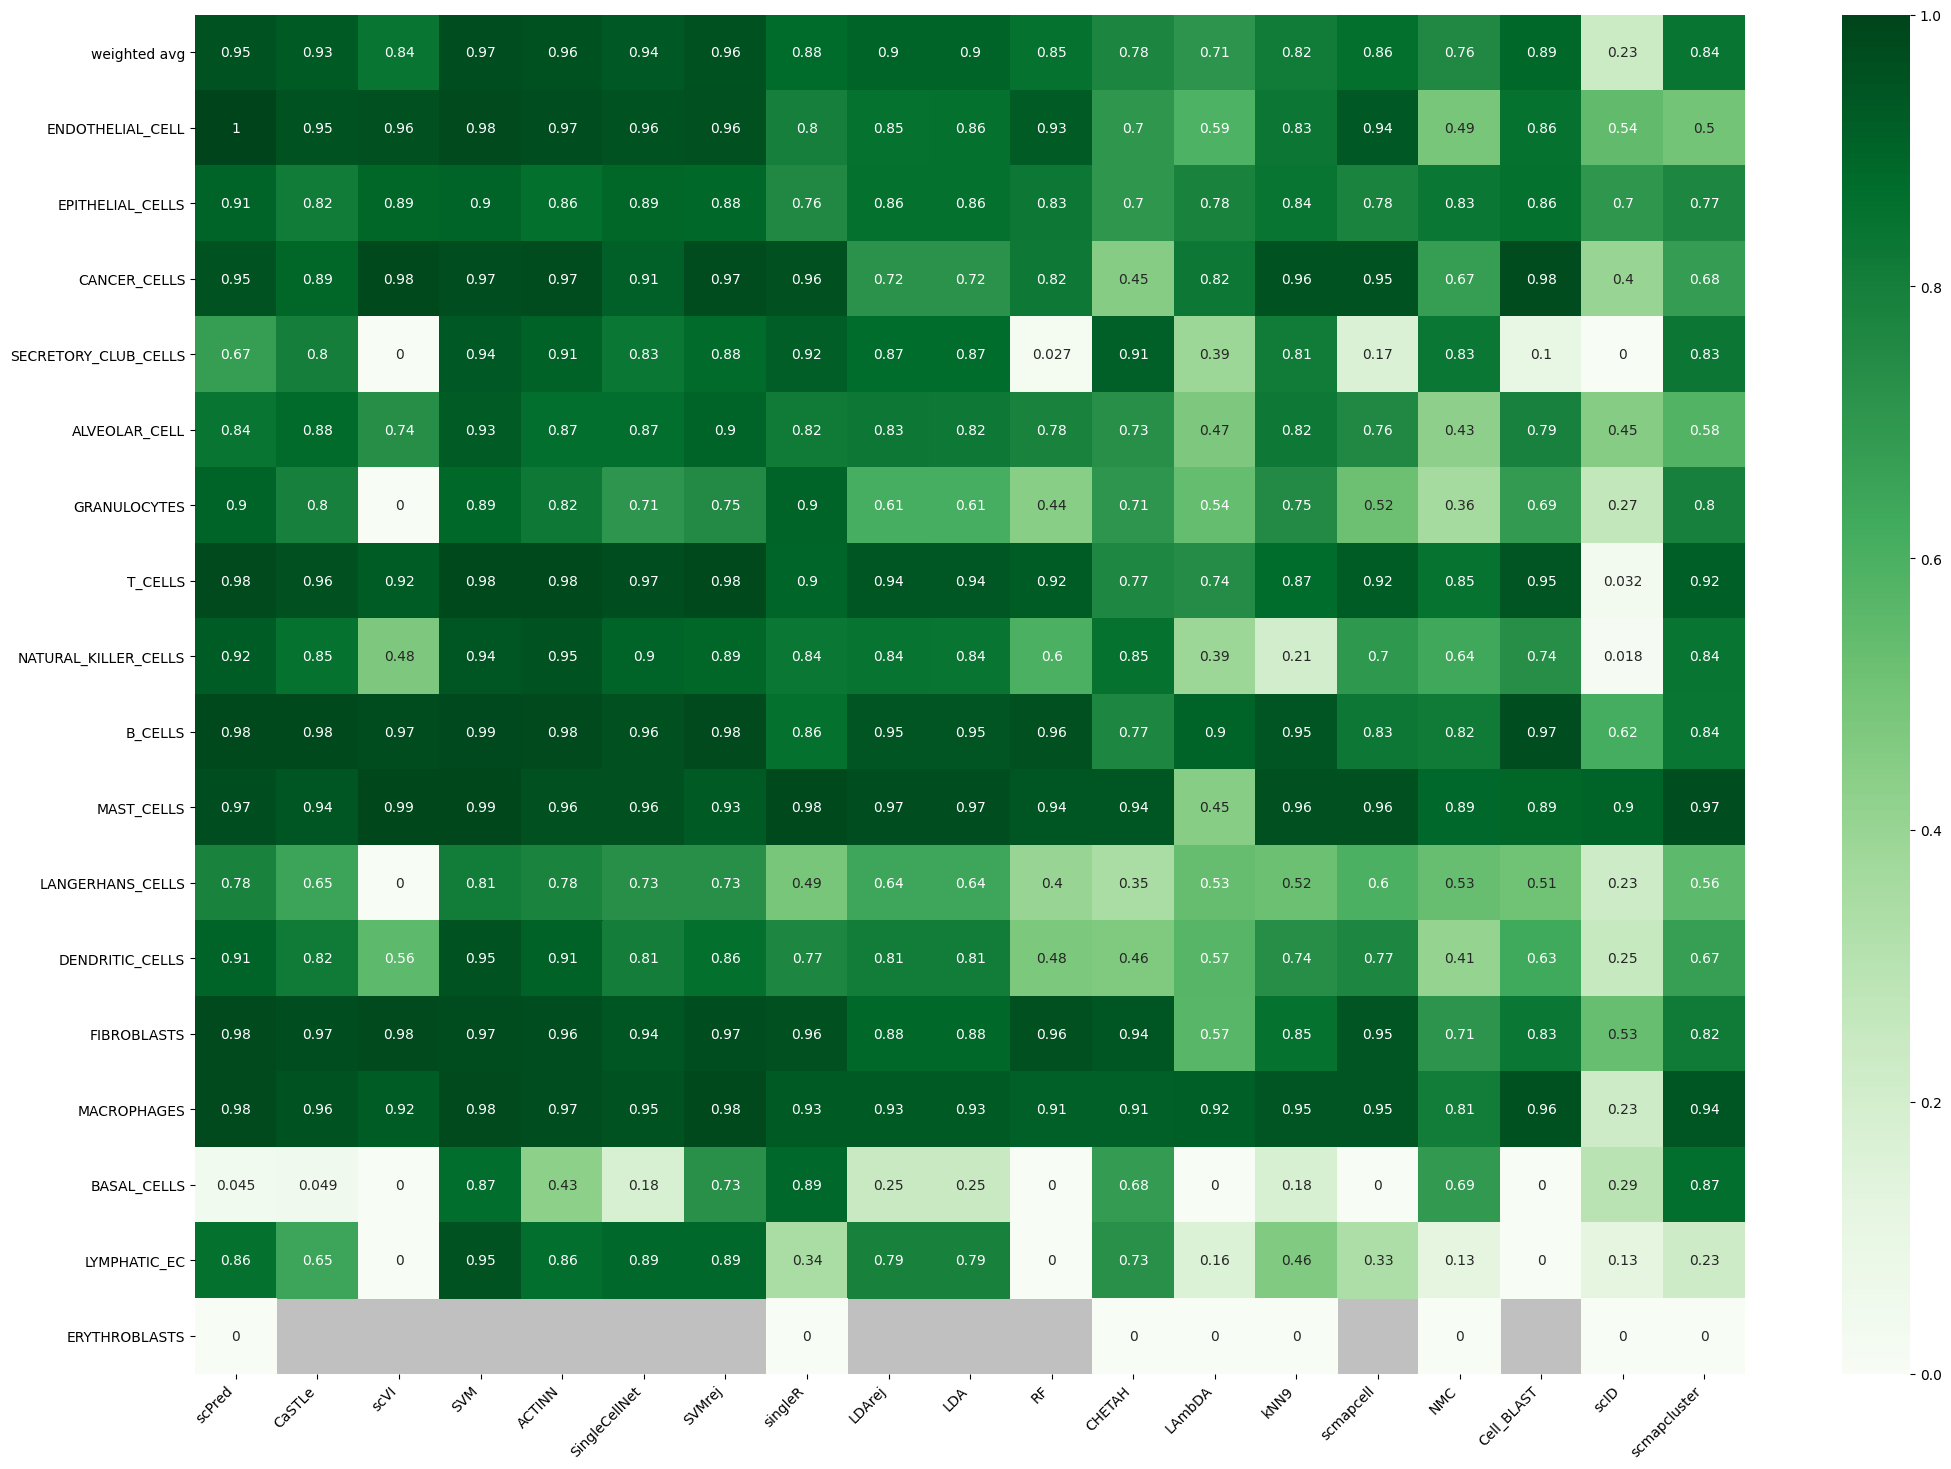

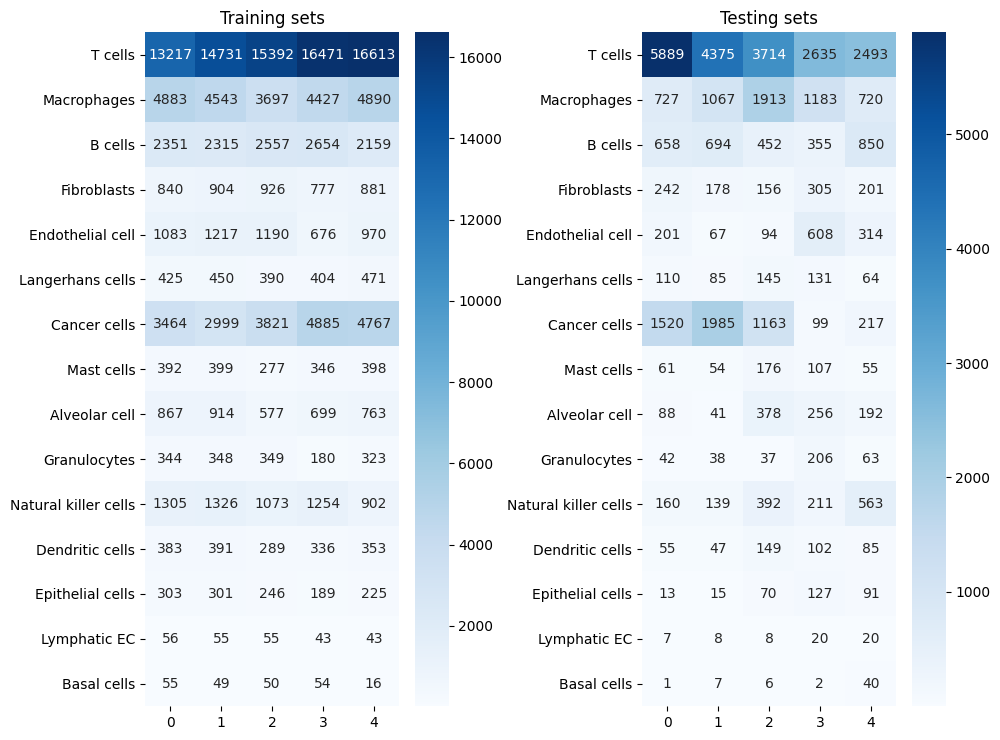

In [8]:
f = open('lung/patient_test.tsv')
lines = f.readlines()
groups = [line.strip('[]\n').replace("'",'').replace(' ','').split(',')\
          for line in lines]
hmdf,diff = analyse('lung/Lambrechts_LC.tsv',
        '../../predictions/llc_predictions.tsv',
        remap={},
        test_groups = groups, 
        patients = '../lung/lung_patients_unique.tsv'
       )

# Lets summarise

In [9]:
perf_files = ['./aml/vanGalan_AML_performance.tsv', 
              './melanoma/JA_Melanoma_performance.tsv',
              './metastatic_melanoma/Tirosh_metastatic_melanoma_performance.tsv',
              './pancreatic/Peng_PC_performance.tsv',
              './lung/Lambrechts_LC_performance.tsv' 
             ]
dataset_map = {'aml':'AML','pancreatic':'Pancreatic','melanoma':'Melanoma',
               'metastatic_melanoma':'Metastatic Melanoma','lung':'Lung'
              }
perf_df = pd.DataFrame()
for file in perf_files:
    df = pd.read_csv(file,sep='\t')
    df['dataset'] = file.split('/')[1]
    if file.split('/')[1] == 'pancreatic':
        df = df[~df['method'].isin(['LDArej','LDA'])]
    perf_df = perf_df.append(df,ignore_index=True)
    
perf_df = perf_df[~perf_df['class'].isin(
    ['UNLABELED','UNAVAILABLE','weighted avg'])]
perf_df['delta_f1'] = perf_df['f1_score']-perf_df['og_f1']
perf_df['dataset']=perf_df.apply(lambda row: dataset_map[row['dataset']],axis=1)

display(perf_df)
print(set(perf_df['class']))

method                 class  support  f1_score     og_f1 dataset  \
0            SVM                   GMP    918.0  0.544088  0.708029     AML   
1            SVM              GMP_LIKE   3055.0  0.564854  0.755911     AML   
2            SVM              HSC_PROG   3418.0  0.827423  0.883436     AML   
3            SVM         HSC_PROG_LIKE   6417.0  0.829659  0.880456     AML   
4            SVM               MYELOID   3904.0  0.715513  0.891728     AML   
...          ...                   ...      ...       ...       ...     ...   
1036  Cell_BLAST           MACROPHAGES   5610.0  0.947238  0.962519    Lung   
1037  Cell_BLAST            MAST_CELLS    453.0  0.860636  0.914634    Lung   
1038  Cell_BLAST  NATURAL_KILLER_CELLS   1465.0  0.719101  0.800000    Lung   
1039  Cell_BLAST  SECRETORY_CLUB_CELLS    119.0  0.158273  0.712329    Lung   
1040  Cell_BLAST               T_CELLS  19106.0  0.972019  0.978601    Lung   

      delta_f1  
0    -0.163941  
1    -0.191057  
2    -0.056012  
3    -0.050797  
4    -0.176215  
...        ...  
1036 -0.015281  
1037 -0.053998  
1038 -0.080899  
1039 -0.554055  
1040 -0.006582  

[911 rows x 7 columns]

{'GMP_LIKE', 'ENDOTHELIAL_CELL', 'B.CELL', 'EPITHELIAL_CELLS', 'CANCER_CELLS', 'SECRETORY_CLUB_CELLS', 'ALVEOLAR_CELL', 'NK', 'STELLATE_CELL', 'T.CELL', 'ENDOCRINE_CELL', 'MACROPHAGE', 'GRANULOCYTES', 'T_CELLS', 'B_CELL', 'ENDO.', 'NATURAL_KILLER_CELLS', 'TCELL', 'BCELL', 'B_CELLS', 'ENDOTHELIAL', 'DUCTAL_CELL_TYPE_1', 'MAST_CELLS', 'MYELOID', 'LANGERHANS_CELLS', 'FIBROBLAST', 'DENDRITIC_CELLS', 'MAL', 'FIBROBLASTS', 'T_CELL', 'T.CD4', 'HSC_PROG', 'MACROPHAGES', 'ACINAR_CELL', 'BASAL_CELLS', 'MYELOID_LIKE', 'HSC_PROG_LIKE', 'LYMPHATIC_EC', 'MELANOMA', 'GMP', 'ERYTHROBLASTS', 'DUCTAL_CELL_TYPE_2', 'CAF', 'T.CD8'}


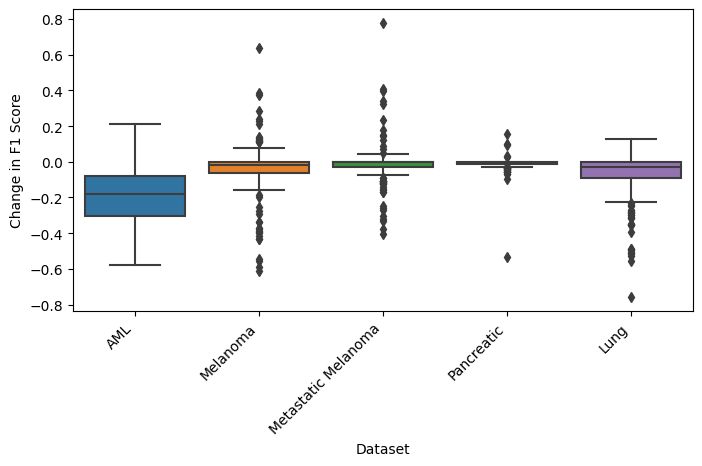

In [10]:
fig, ax = plt.subplots(1,1,dpi=100)
bxplt = sns.boxplot(x='dataset',y='delta_f1',data=perf_df,ax=ax)
bxplt.set_xticklabels(bxplt.get_xticklabels(),rotation=45,
                      horizontalalignment='right')
bxplt.set_ylabel('Change in F1 Score')
bxplt.set_xlabel('Dataset')
fig.set_figwidth(8)
plt.savefig('../../plots/Figure_6/dataset_f1_patients.png',bbox_inches='tight')

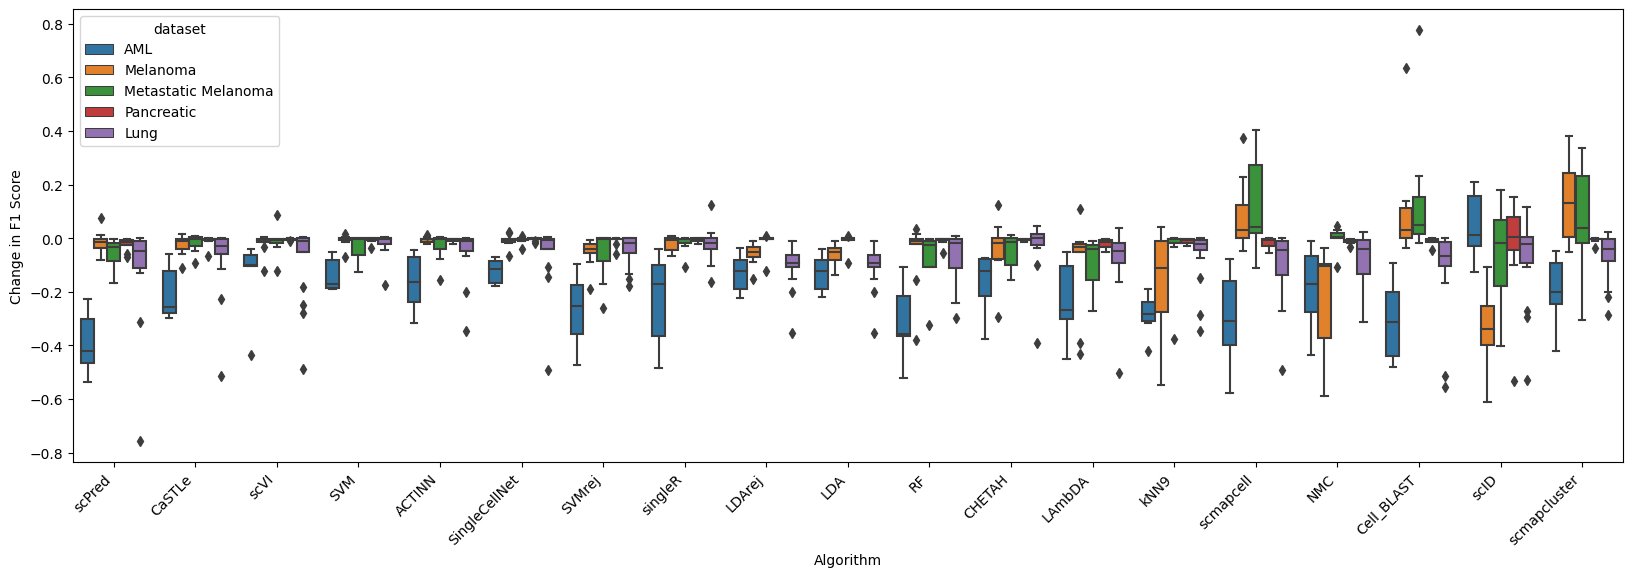

In [11]:
fig, ax = plt.subplots(1,1,dpi=100)
bxplt = sns.boxplot(x='method',y='delta_f1',hue='dataset',data=perf_df,ax=ax,
                      order = ['scPred','CaSTLe','scVI','SVM','ACTINN',
                               'SingleCellNet','SVMrej','singleR','LDArej',
                               'LDA','RF','CHETAH','LAmbDA','kNN9','scmapcell',
                               'NMC','Cell_BLAST','scID','scmapcluster', 
                              ],
                   )
bxplt.set_xticklabels(bxplt.get_xticklabels(),rotation=45,
                      horizontalalignment='right')
bxplt.set_ylabel('Change in F1 Score')
bxplt.set_xlabel('Algorithm')
#plt.legend(bbox_to_anchor=(1.01, 1),
#           borderaxespad=0)
#ax.get_legend().set_bbox_to_anchor(bbox=(1.01,1))
fig.set_figwidth(20)
fig.set_figheight(6)
plt.savefig('../../plots/Figure_6/algorithm_f1_patients.png',
            bbox_inches='tight')

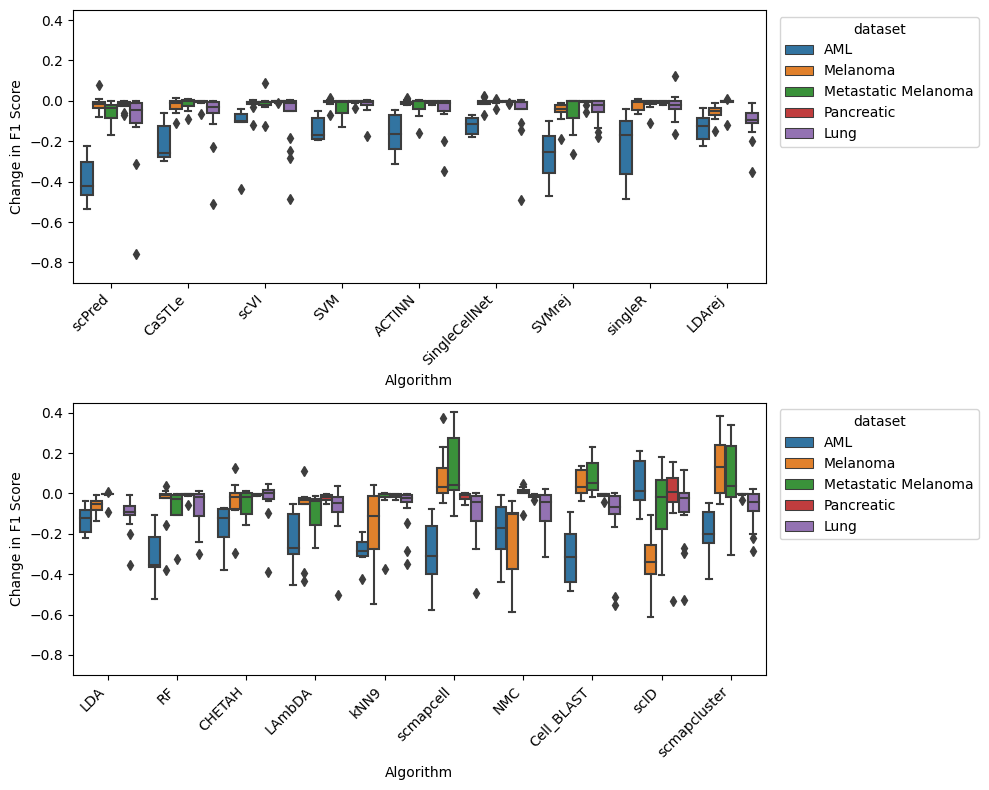

In [12]:
#make the same figure, but split in half for slide shows
fig, (ax1,ax2) = plt.subplots(2,1,dpi=100)
bxplt = sns.boxplot(x='method',y='delta_f1',hue='dataset',data=perf_df,ax=ax1,
                      order = ['scPred','CaSTLe','scVI','SVM','ACTINN',
                               'SingleCellNet','SVMrej','singleR','LDArej',
                              ],
                   )
bxplt.set_ylabel('Change in F1 Score')
bxplt.set_xlabel('Algorithm')
bxplt.set_ylim(-0.9,0.45)

bxplt.set_xticklabels(bxplt.get_xticklabels(),rotation=45,
                      horizontalalignment='right')
ax1.get_legend().set_bbox_to_anchor(bbox=(1.01,1))
bxplt = sns.boxplot(x='method',y='delta_f1',hue='dataset',data=perf_df,ax=ax2,
                      order = [
                               'LDA','RF','CHETAH','LAmbDA','kNN9','scmapcell',
                               'NMC','Cell_BLAST','scID','scmapcluster', 
                              ],
                   )
bxplt.set_ylabel('Change in F1 Score')
bxplt.set_xlabel('Algorithm')
bxplt.set_ylim(-0.9,0.45)
bxplt.set_xticklabels(bxplt.get_xticklabels(),rotation=45,
                      horizontalalignment='right')
ax2.get_legend().set_bbox_to_anchor(bbox=(1.01,1))
fig.set_figwidth(10)
fig.set_figheight(8)
fig.tight_layout()